In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Analisi descrittive - Temporali

## Pre-processing
In questa fase si è andato a strutturare il dataframe per le analisi che seguiranno.

In [ ]:
import pandas as pd

def drop_column(input_file, output_file, colonne_da_rimuovere, chunk_size = 100000):

  # Usa pd.read_csv con chunksize
  chunk_iter = pd.read_csv(input_file, chunksize=chunk_size)


  for i, chunk in enumerate(chunk_iter):
      # Droppa le colonne indesiderate
      chunk = chunk.drop(columns=colonne_da_rimuovere)

      # Scrive il chunk nel file di output
      if i == 0:
          chunk.to_csv(output_file, index=False)  # Scrivi l'header solo nel primo chunk
      else:
          chunk.to_csv(output_file, mode='a', header=False, index=False)  # Append senza header

In [ ]:
drop_column(dataset, "/content/drive/MyDrive/dataset_solo_sostanze.csv",
            colonne_da_rimuovere= ['Unnamed: 0.1', 'Unnamed: 0', 'VWS (m/s)'])

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import cm
from sklearn.linear_model import LinearRegression
import plotly.express as px
import os

dataset = "/content/drive/MyDrive/dataset_solo_sostanze.csv"

df = pd.read_csv(dataset)
colors1 = ['blue', 'green', 'red']
colors2 = ['orange', 'purple', 'brown']
colors3 = ['magenta', 'yellow']

# Preprocessing del dataset
df['From Date'] = pd.to_datetime(df['From Date'])  # Converte 'From Date' in formato datetime
df['Year'] = df['From Date'].dt.year  # Estrae l'anno
df['Month'] = df['From Date'].dt.month  # Estrae il mese
pollutants1 = ['SO2 (ug/m3)', 'Ozone (ug/m3)']
pollutants2 = [ 'PM10 (ug/m3)', 'PM2.5 (ug/m3)']
pollutants3 = ['NO (ug/m3)', 'NO2 (ug/m3)']
pollutants4 = ['CO (mg/m3)']

#Normalizza i valori
def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

## Andamento temporale
In questa sezione si sono graficati gli andamenti temporali dei vari inquinanti, in particolare, le sostanze sono raggruppate in base agli ordini di grandezza e alla loro "affinità" così da redendere ogni grafico il più leggibile possibile

In [ ]:
#Andamento temporale
def time_analysis(data, colors, title, xlabel, ylabel):
  plt.figure(figsize=(12, 6))
  for i, pollutant in enumerate(data):
        monthly_avg = df.groupby(['Year', 'Month'])[data].mean().reset_index()
        plt.plot(
            pd.to_datetime(monthly_avg[['Year', 'Month']].assign(Day=1)),
            monthly_avg[pollutant],
            label=pollutant,
            marker=".",
            color=colors[i]
        )
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.legend()
  plt.show()

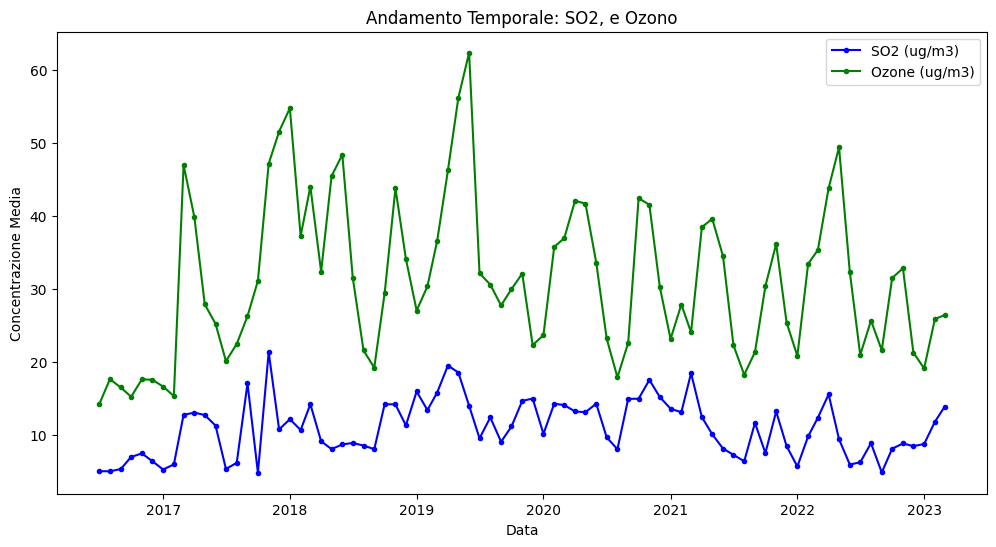

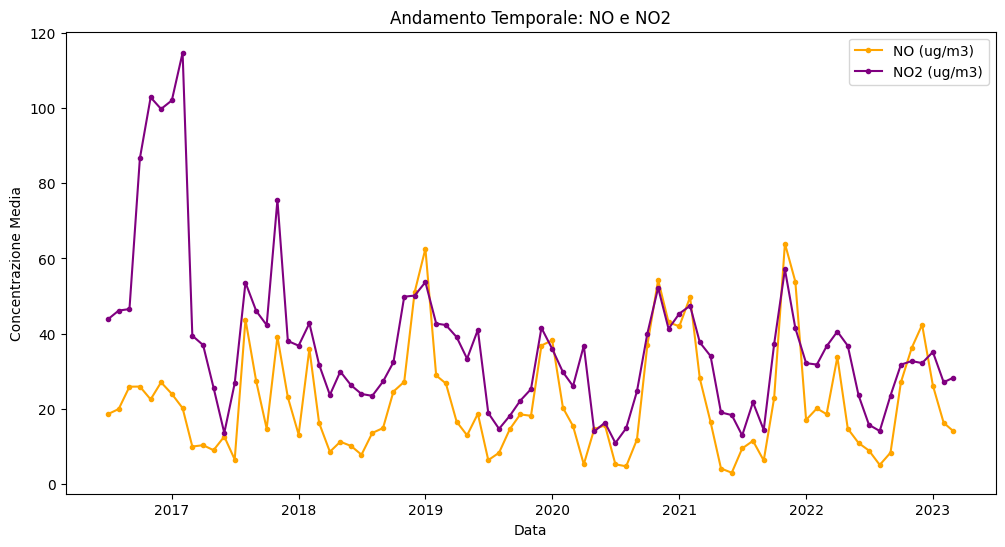

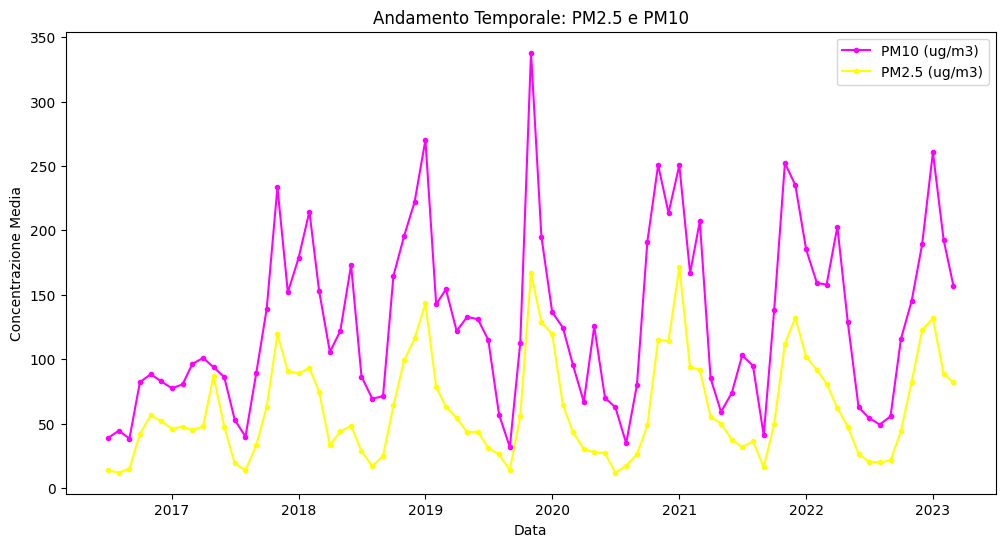

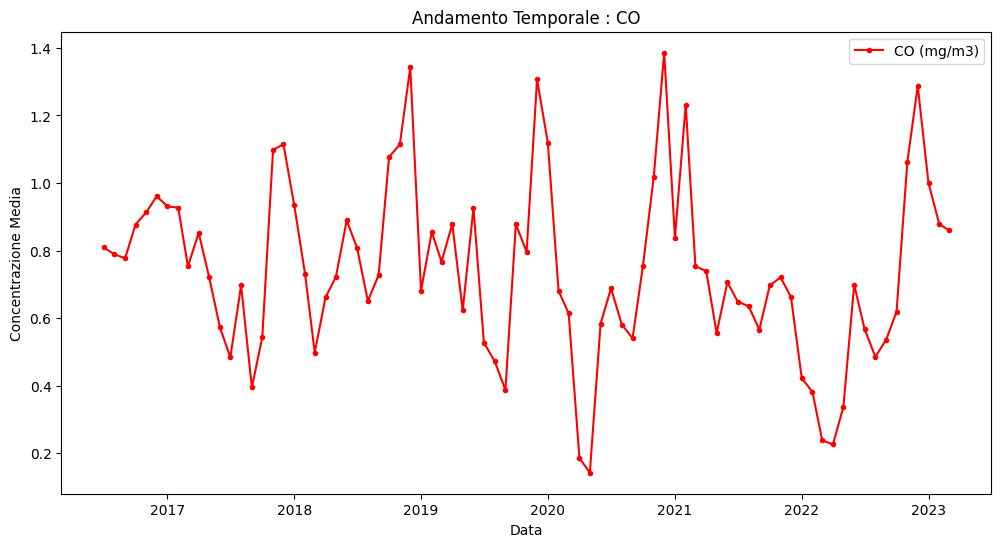

In [ ]:
time_analysis(pollutants1, colors1, 'Andamento Temporale: SO2, e Ozono', 'Data', 'Concentrazione Media')
time_analysis(pollutants3, colors2, 'Andamento Temporale: NO e NO2', 'Data', 'Concentrazione Media')
time_analysis(pollutants2, colors3, 'Andamento Temporale: PM2.5 e PM10', 'Data', 'Concentrazione Media')
time_analysis(pollutants4, 'red', 'Andamento Temporale : CO', 'Data', 'Concentrazione Media')

## Strip Plot
Questa tipologia di grafico serve a vedere la concentrazione delle varie sostanze negli anni. Anche qui gli inquinanti sono stati divisi per una maggiore leggibilità

In [ ]:
def striplot_sampled(data, colors, id_vars, var_name, value_name, title, sample_size=500000):
    plt.figure(figsize=(12, 6))
    df_melted1 = df.melt(id_vars=id_vars, value_vars=data, var_name=var_name, value_name=value_name)
    # Campiona i dati
    if len(df_melted1) > sample_size:
        df_melted1 = df_melted1.sample(n=sample_size, random_state=42)
    sns.stripplot(x=id_vars, y=value_name, hue=var_name, data=df_melted1, dodge=True, jitter=True, palette=colors)
    plt.title(title)
    plt.show()

<ipython-input-7-04dc8f3a663d>:7: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.stripplot(x=id_vars, y=value_name, hue=var_name, data=df_melted1, dodge=True, jitter=True, palette=colors)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


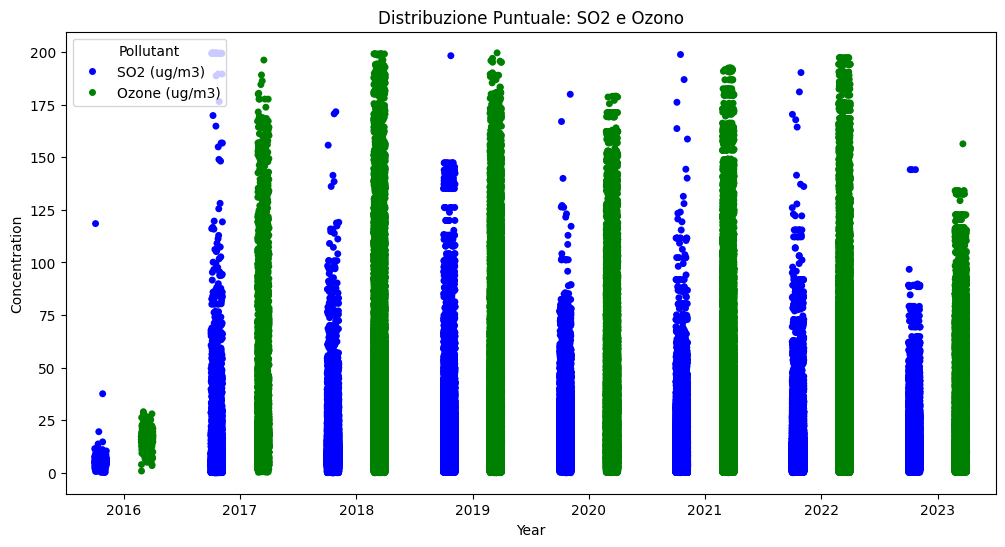

<ipython-input-7-04dc8f3a663d>:7: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.stripplot(x=id_vars, y=value_name, hue=var_name, data=df_melted1, dodge=True, jitter=True, palette=colors)


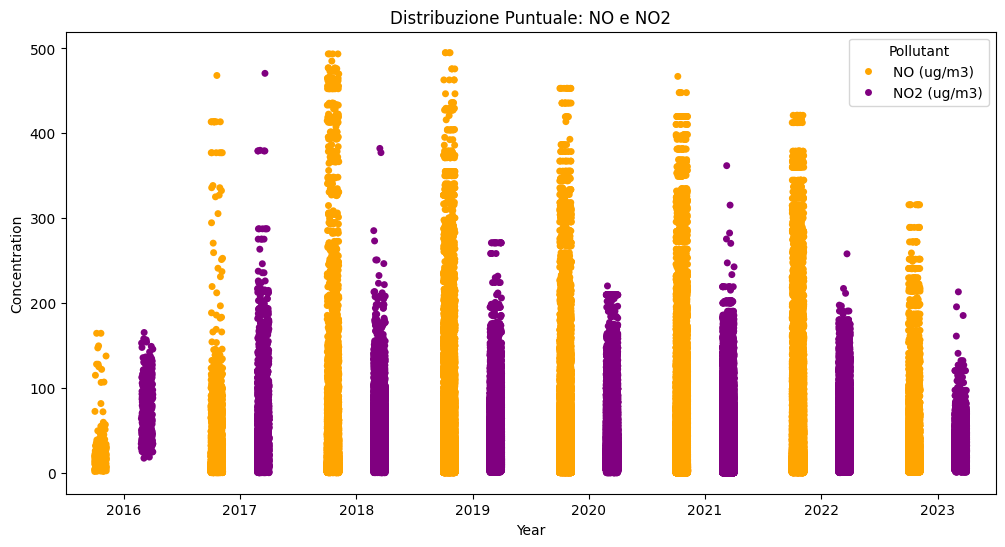

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


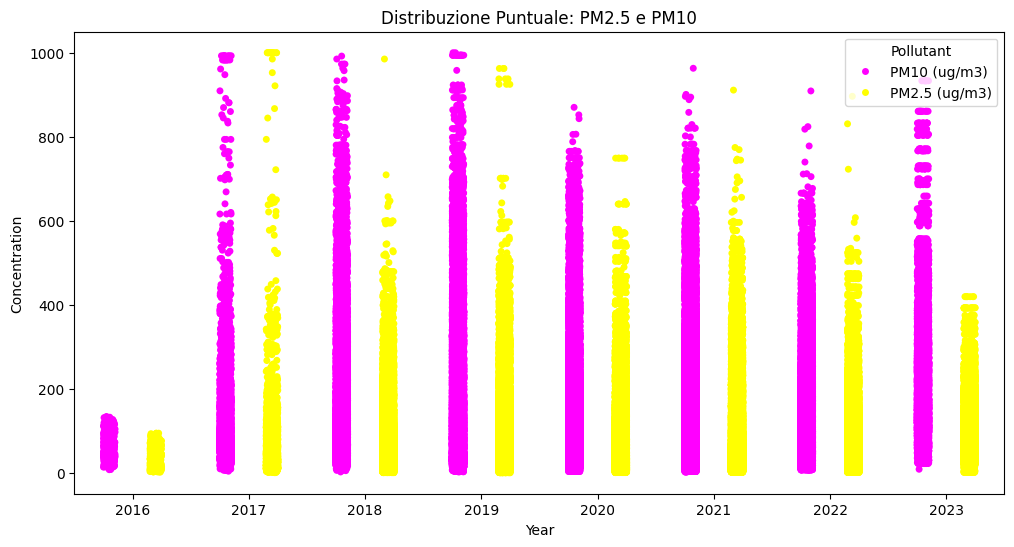

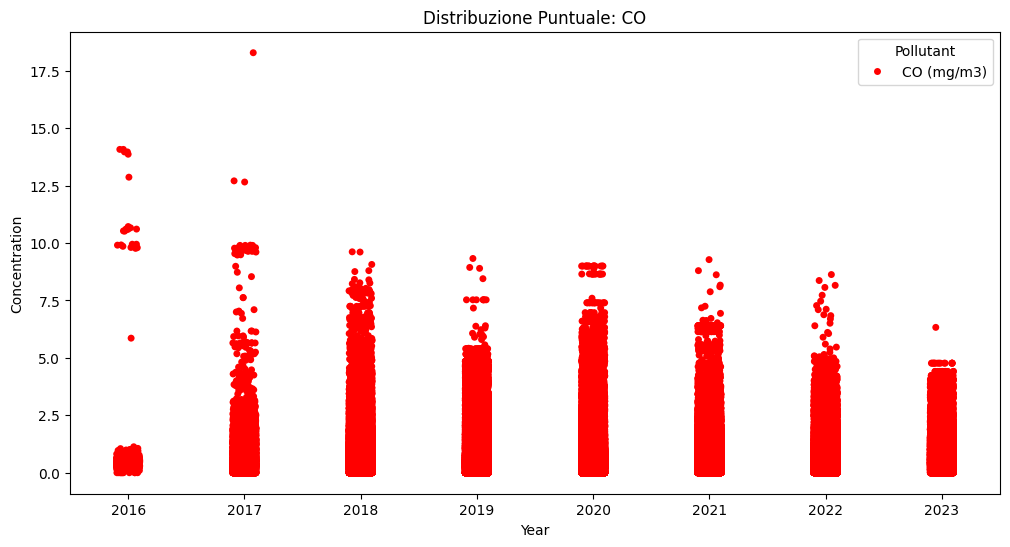

In [ ]:
striplot_sampled(pollutants1, colors1, 'Year', 'Pollutant', 'Concentration', 'Distribuzione Puntuale: SO2 e Ozono')
striplot_sampled(pollutants3, colors2, 'Year', 'Pollutant', 'Concentration', 'Distribuzione Puntuale: NO e NO2')
striplot_sampled(pollutants2, colors3, 'Year', 'Pollutant', 'Concentration', 'Distribuzione Puntuale: PM2.5 e PM10')
colors4 = ['red']
striplot_sampled(pollutants4, colors4, 'Year', 'Pollutant', 'Concentration', 'Distribuzione Puntuale: CO')

## Analisi Trend temporale
Quest'analisi ci serve per capire, ad alto livello, quale potrebbe essere il trend delle sostanze negli anni. Ogni sostanza viene mostrata singolarmente e ogni punto si riferisce a dei campioni medi presi a Luglio e Dicembre di ogni anno. Nonostante l'andamento potrebbe essere interessato anche da delle stagionalità o altri trend, che con questo campionamento vengono trascurati, il grafico ci permette già di intuire i trend delle sostanze nel corso degli anni.

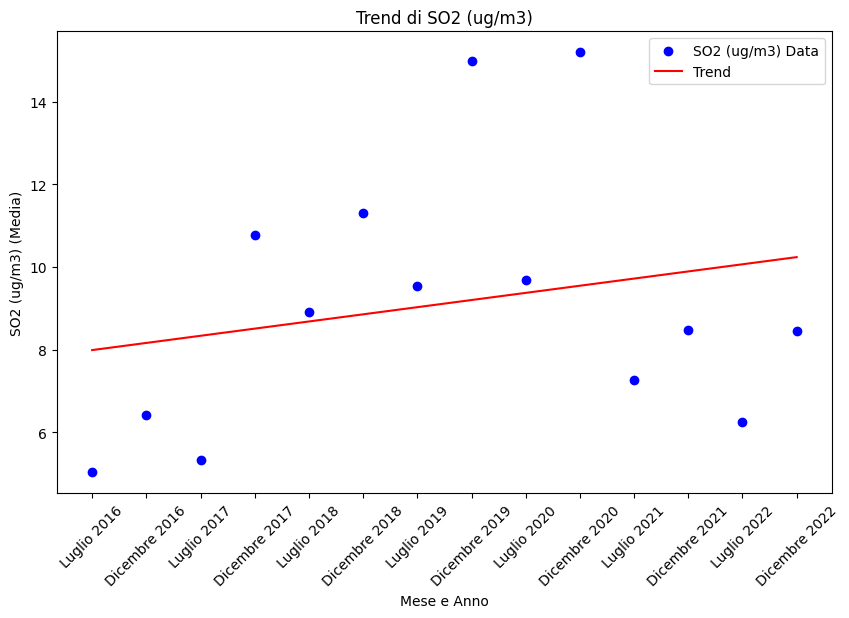

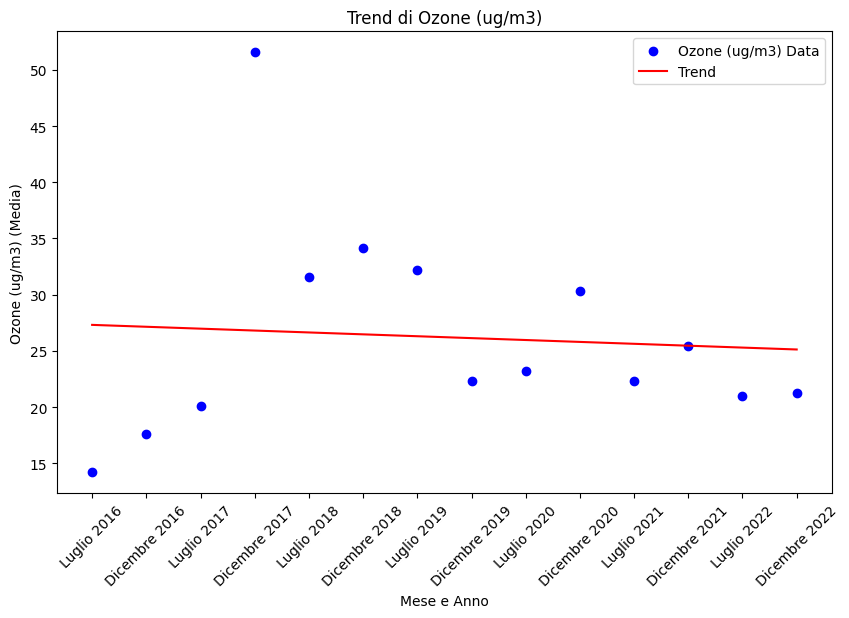

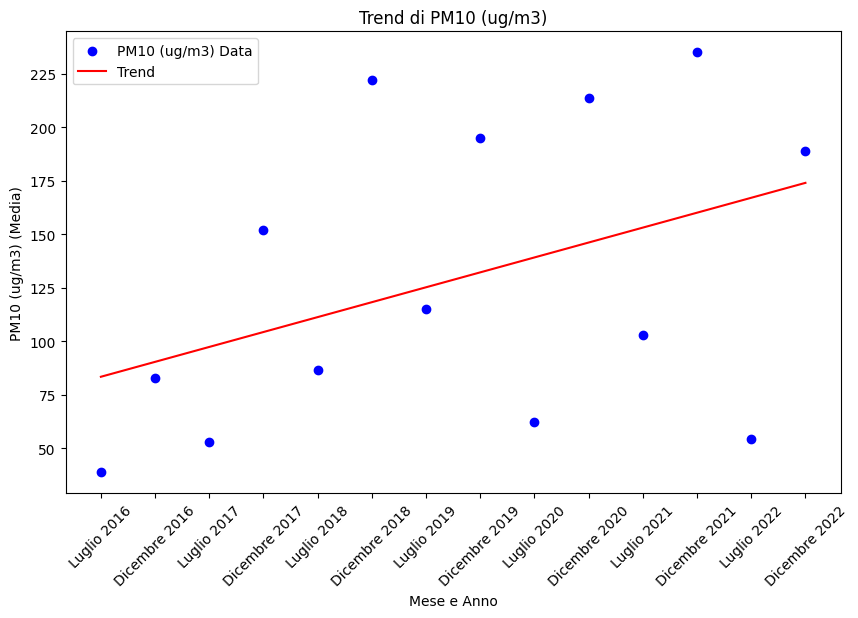

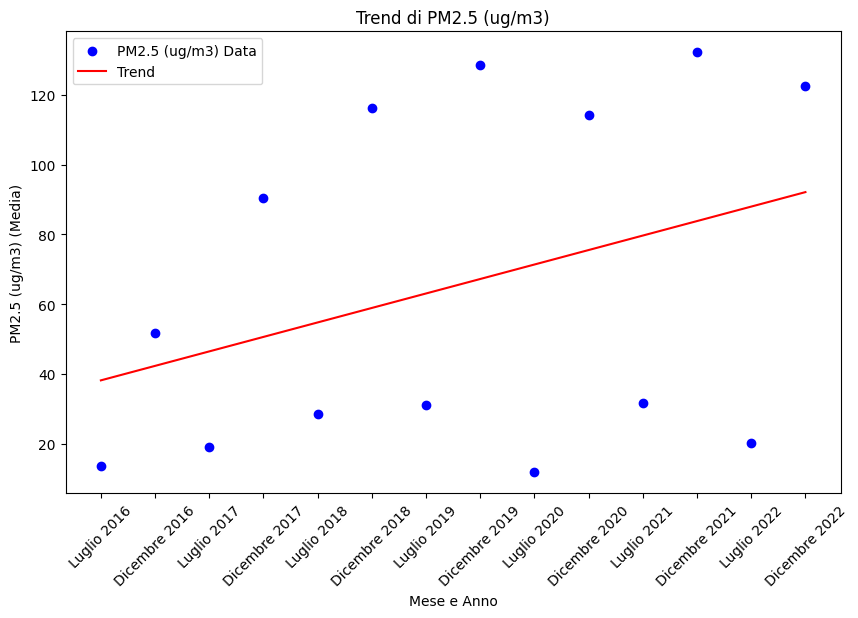

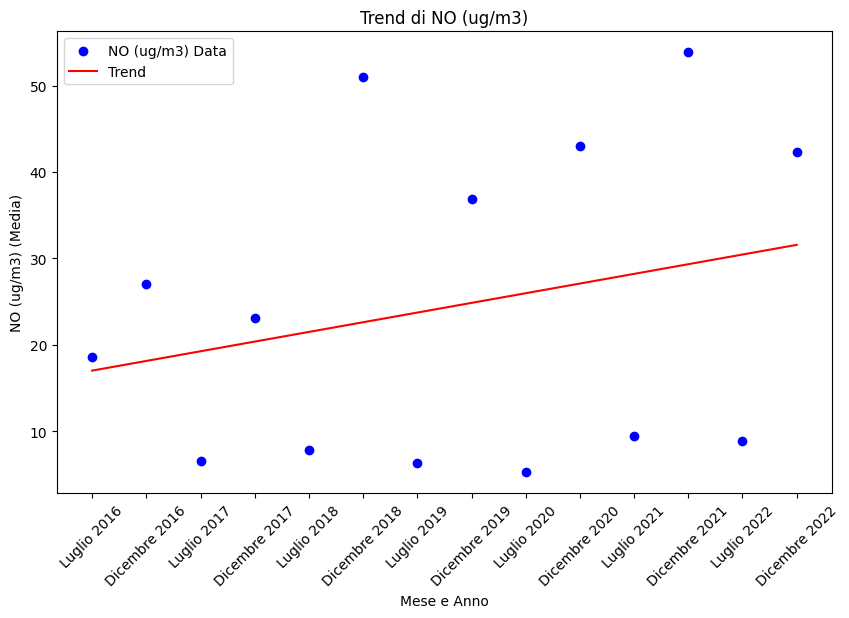

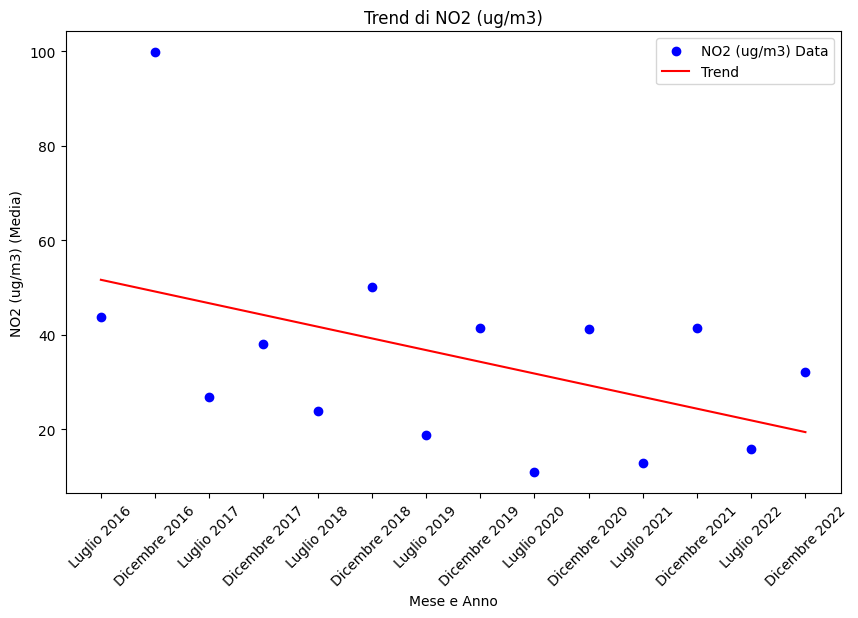

In [ ]:
def regression_lines():
  regression_pollutants = pollutants1 + pollutants2 + pollutants3
  months = [7, 12]
  month_labels = {7: 'Luglio', 12: 'Dicembre'}

  for pollutant in regression_pollutants:
      pollutant_data = df[df['Month'].isin(months)].groupby(['Year', 'Month'])[pollutant].mean().reset_index()
      pollutant_data['Month'] = pollutant_data['Month'].map(month_labels)
      X = pollutant_data[['Year', 'Month']].apply(lambda x: x['Year'] + (0.5 if x['Month'] == 'Dicembre' else 0), axis=1).values.reshape(-1, 1)
      y = pollutant_data[pollutant]
      reg = LinearRegression()
      reg.fit(X, y)
      trend = reg.predict(X)

      plt.figure(figsize=(10, 6))
      plt.scatter(X, y, color='blue', label=f'{pollutant} Data')
      plt.plot(X, trend, color='red', label='Trend')
      plt.xticks(X.flatten(), pollutant_data[['Year', 'Month']].apply(lambda x: f"{x['Month']} {int(x['Year'])}", axis=1), rotation=45)
      plt.title(f'Trend di {pollutant}')
      plt.xlabel('Mese e Anno')
      plt.ylabel(f'{pollutant} (Media)')
      plt.legend()
      plt.show()

regression_lines()

## Radar plot
Questo grafico ci permette di controllare per ogni anno i livelli di inquinamento delle sostanze. Il punto di forza di questo grafico è che, normalizzando i valori, ci permette di mettere a confronto i livelli di inquinamento delle varie sostanze tra loro, permettendoci di avere un'idea generale e complessiva dell'inquinamento dell'aria.

In [ ]:
def radar_plot():
  total_pollutants = pollutants1 + pollutants2 + pollutants3
  for year in df['Year'].unique():
    normalized_data=[]
    index=[]
    for i, pollutant in enumerate(total_pollutants):
      yearly_data = df[df['Year'] == year][pollutant]
      normalized_data.append(normalize(yearly_data).mean())
      index.append(pollutant)
    normalized_data =pd.Series(normalized_data, index=index)
    fig = px.line_polar(
          r=normalized_data,
          theta=normalized_data.index,
          line_close=True,
          markers=True,
          title=f'Concentrazione Media normalizzata degli Inquinanti - {year}',
      )
    fig.show()

radar_plot()


## Heatmap trimestrale
Questo grafico ci permette di visualizzare in maniera rapida i livelli di inquinamento nei vari anni. In questo caso, sono stati campionati i trimestri di ogni anno, e attraverso una mappa di calore si sono visualizzati i valori, comunicando i picchi massimi e minimi di ogni anno.

In [ ]:
def create_quarterly_heatmap(df, pollutant):
    """
    Crea una heatmap trimestrale per l'inquinante specificato

    Parametri:
    df : DataFrame con i dati
    pollutant : str, nome della colonna dell'inquinante
    """
    # Aggiunge colonna per il trimestre
    df['Quarter'] = df['From Date'].dt.quarter

    # Calcola la media trimestrale
    quarterly_data = df.groupby(['Year', 'Quarter'])[pollutant].mean().reset_index()

    # Crea una pivot table per la heatmap
    heatmap_data = quarterly_data.pivot(index='Year',
                                      columns='Quarter',
                                      values=pollutant)

    # Crea un DataFrame con tutti gli anni e trimestri possibili
    years = df['Year'].unique()
    quarters = range(1, 5)
    full_index = pd.MultiIndex.from_product([years, quarters],
                                          names=['Year', 'Quarter'])

    # Crea un DataFrame completo con tutti i possibili anni/trimestri
    complete_data = pd.DataFrame(index=full_index).reset_index()

    # Unisce con i dati esistenti
    complete_data = complete_data.merge(quarterly_data,
                                      on=['Year', 'Quarter'],
                                      how='left')

    # Converte di nuovo in pivot table
    heatmap_data = complete_data.pivot(index='Year',
                                     columns='Quarter',
                                     values=pollutant)

    # Riempi i valori NaN con 0 -- non serve visto l'ETL già eseguito ma si lascia per sicurezza
    heatmap_data = heatmap_data.fillna(0)

    # Dizionario per mappare i numeri dei trimestri con le etichette descrittive
    quarter_labels = {
        1: 'Gennaio-Marzo',
        2: 'Aprile-Giugno',
        3: 'Luglio-Settembre',
        4: 'Ottobre-Dicembre'
    }


    plt.figure(figsize=(12, 8))

    # Crea la heatmap
    sns.heatmap(heatmap_data,
                cmap='YlOrRd',
                annot=True,
                fmt='.1f',
                cbar_kws={'label': pollutant})

    plt.title(f'Heatmap Trimestrale: {pollutant}')
    plt.xlabel('Trimestre')
    plt.ylabel('Anno')

    # Aggiorna le etichette dell'asse x con i nomi dei trimestri
    plt.xticks(np.arange(4) + 0.5, [quarter_labels[i] for i in range(1, 5)], rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

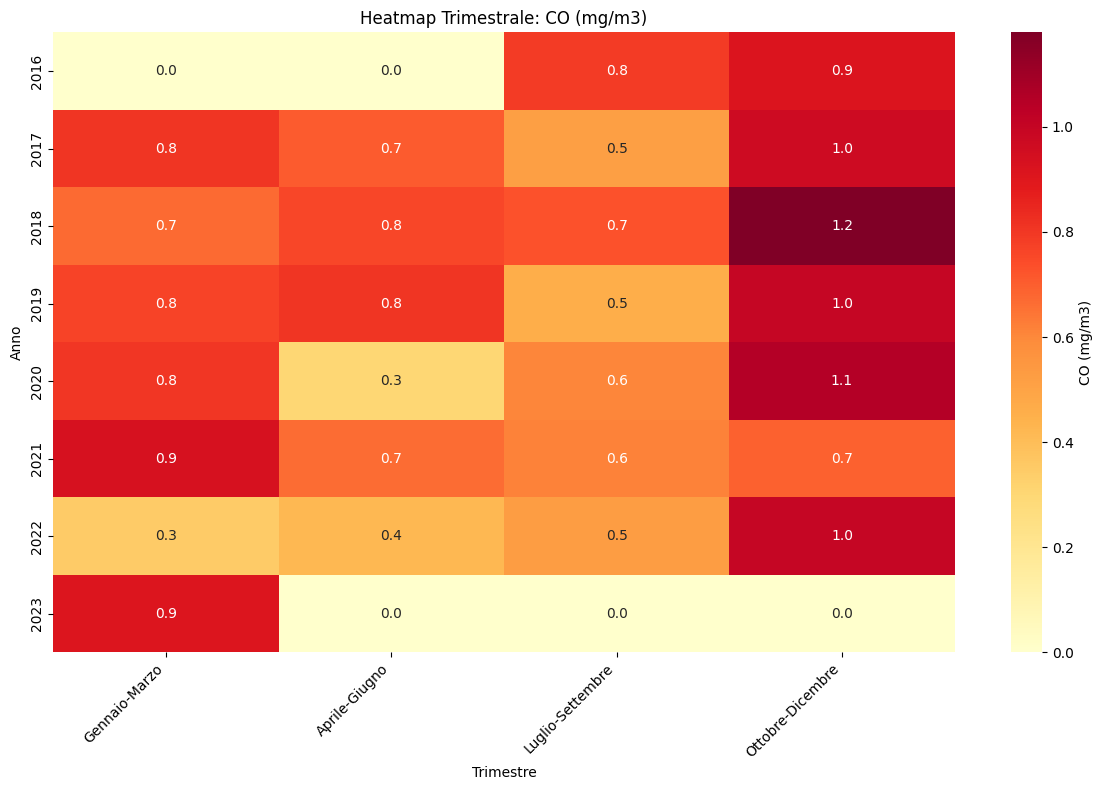

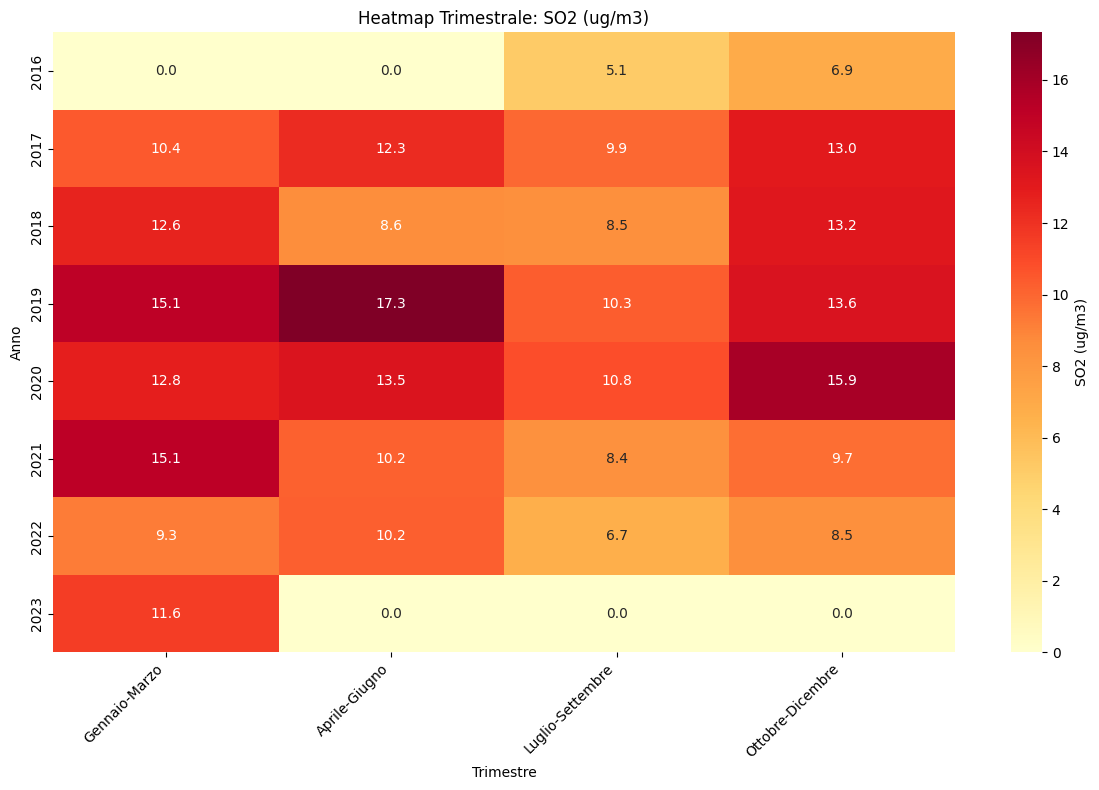

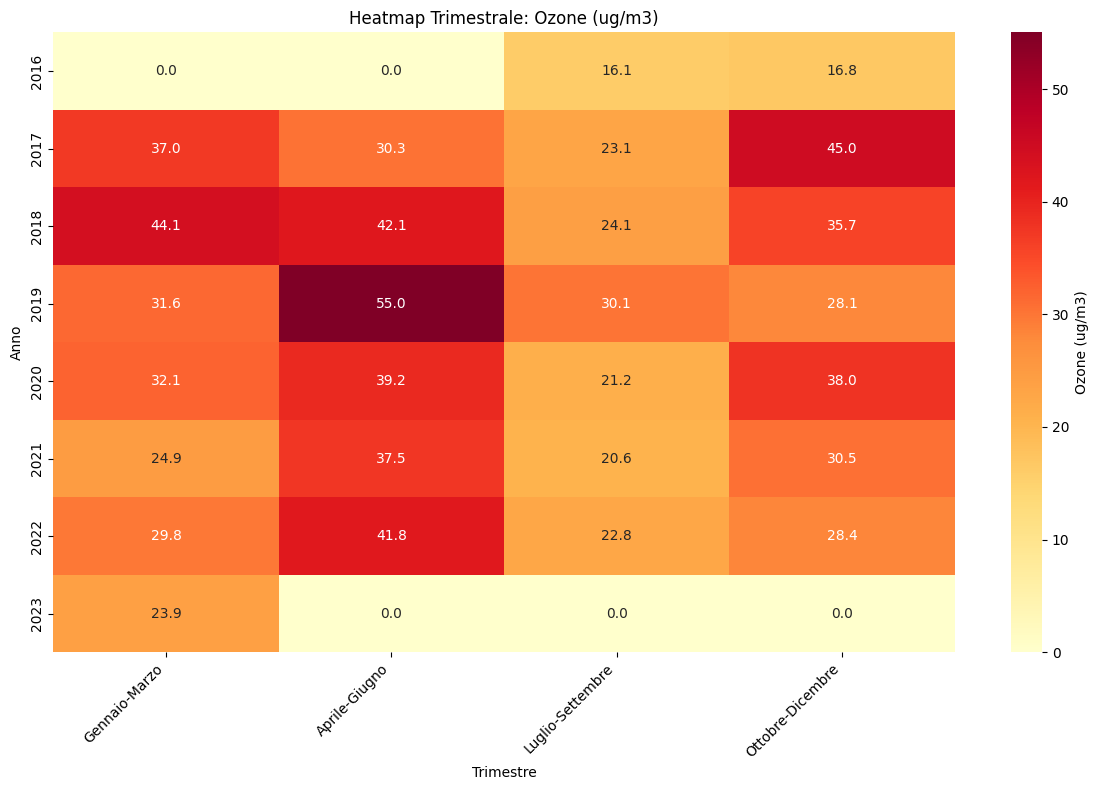

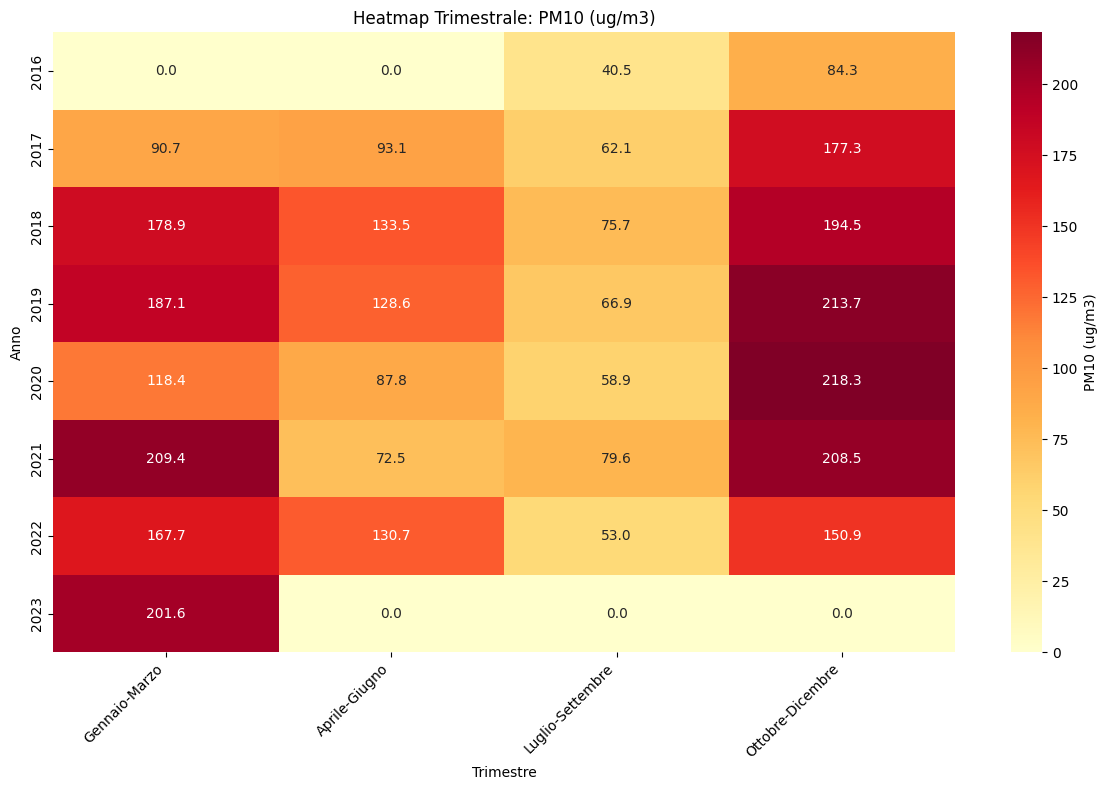

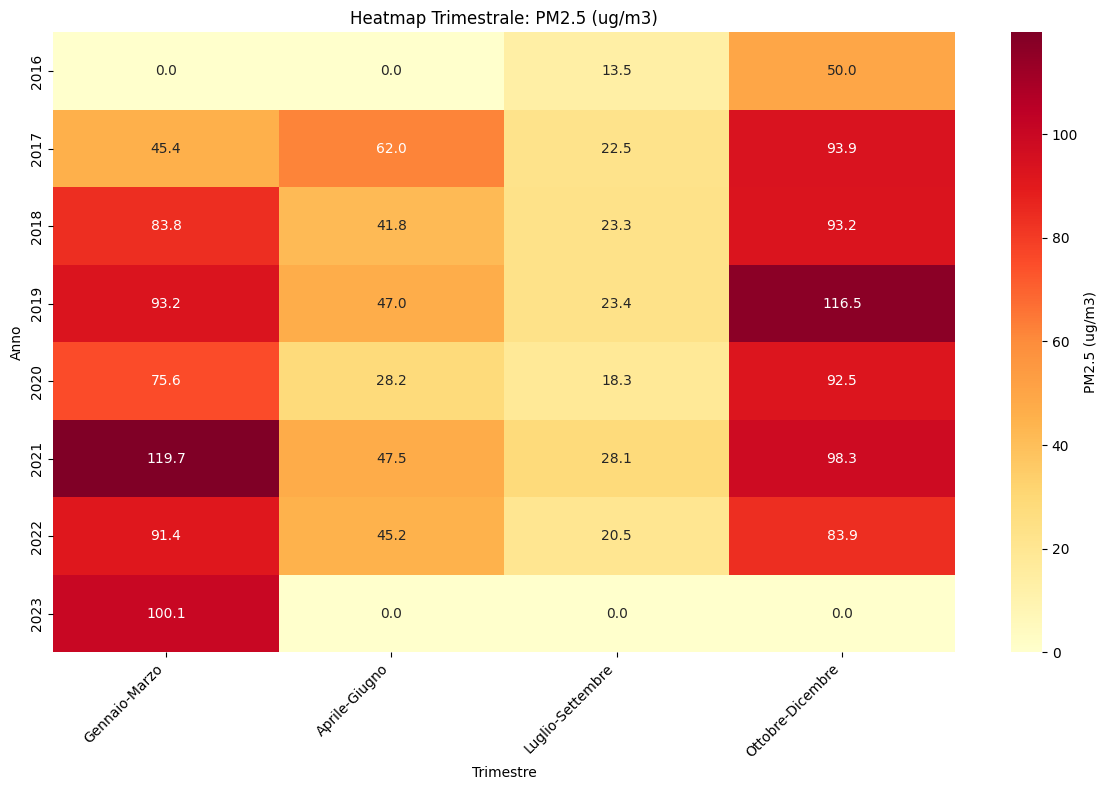

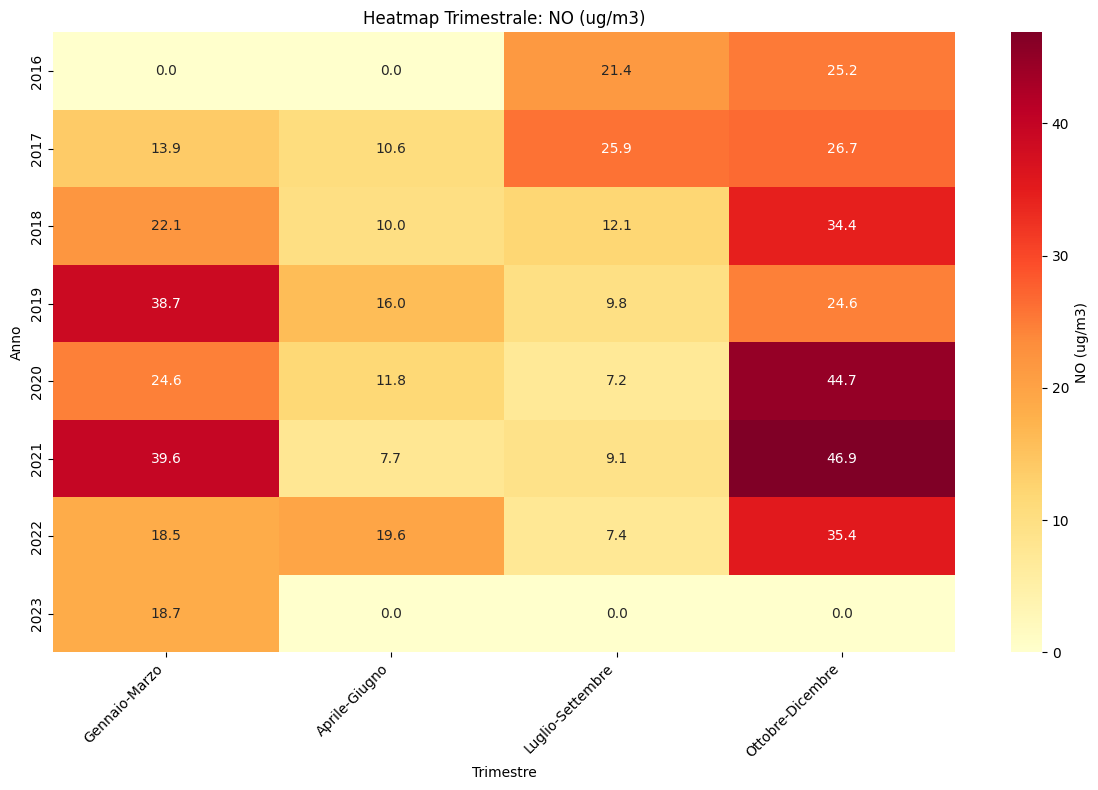

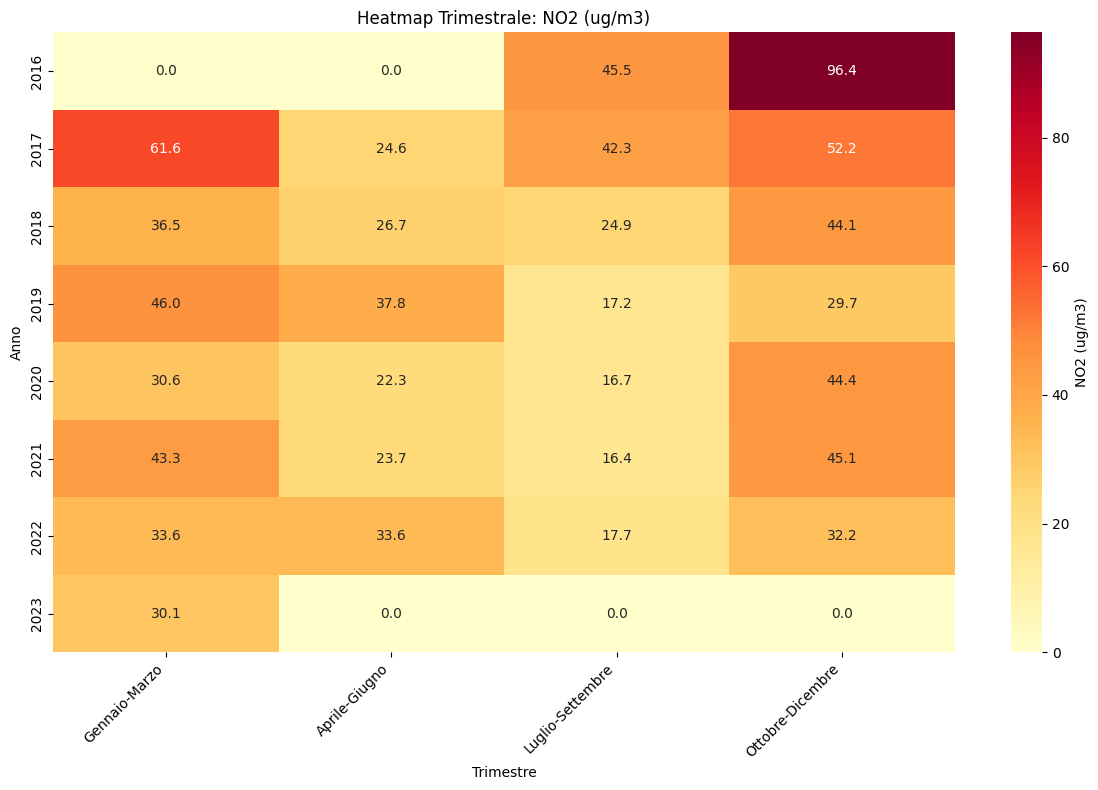

In [ ]:
for pollutant in (pollutants1+pollutants2+pollutants3):
  create_quarterly_heatmap(df, pollutant)

# Analisi descrittiva - Analisi delle sostanza con soglie
In questa sezione si creeranno delle tabelle colorate sulla base dei valori delle sostanze inquinanti rispetto a delle soglie stabilite dall'Organizzazione Mondiale della Sanità. Il grafico colorerà di rosso i mesi con un tasso di inquinamento medio molto alto e invece di giallo chiaro o verde i mesi con inquinamento basso o nullo.

In [ ]:
def create_pollution_level_table(df, pollutant):
    """
    Crea una tabella mensile che mostra i livelli di inquinamento basati su soglie predefinite

    Parametri:
    df : DataFrame con i dati
    pollutant : str, nome della colonna dell'inquinante
    """
    # Definizione delle soglie per ogni inquinante
    thresholds = {
        'CO (mg/m3)': {
            'nullo': 0.03,    # < 0.03
            'basso': 0.04,    # 0.03 - 0.04
            'medio': 0.05,    # 0.04 - 0.05
            'alto': float('inf')  # > 0.05
        },
        'SO2 (ug/m3)': {
            'nullo': 1,     # < 1
            'basso': 2,     # 1 - 2
            'medio': 5,    # 2 - 5
            'alto': float('inf')  # > 5
        },
        'Ozone (ug/m3)': {
            'nullo': 12.5,     # < 12.5
            'basso': 13.75,    # 12.5 - 13.75
            'medio': 17,    # 13.75 - 17
            'alto': float('inf')  # > 17
        },
        'PM10 (ug/m3)': {
            'nullo': 20,     # < 20
            'basso': 35,     # 20 - 35
            'medio': 75,     # 35 - 75
            'alto': float('inf')  # > 75
        },
        'PM2.5 (ug/m3)': {
            'nullo': 10,     # < 10
            'basso': 25,     # 10 - 25
            'medio': 35,     # 25 - 35
            'alto': float('inf')  # > 35
        },
        'NO (ug/m3)': {
            'nullo': 10,     # < 10
            'basso': 30,    # 10 - 30
            'medio': 50,    # 30 - 50
            'alto': float('inf')  # > 50
        },
        'NO2 (ug/m3)': {
            'nullo': 40,     # < 40
            'basso': 50,     # 40 - 50
            'medio': 60,     # 50 - 60
            'alto': float('inf')  # > 60
        }
    }

    # Calcola la media mensile
    monthly_data = df.groupby(['Year', df['From Date'].dt.month])[pollutant].mean().reset_index()
    monthly_data.columns = ['Year', 'Month', 'Value']


    table_data = monthly_data.pivot(index='Year', columns='Month', values='Value')

    table_data = table_data.reindex(columns=range(1, 13))

    # Funzione per determinare il colore basato sul valore
    def get_color(val, poll_thresholds):
        if pd.isna(val):
            return 'white'
        elif val < poll_thresholds['nullo']:
            return '#90EE90'  # verde chiaro
        elif val < poll_thresholds['basso']:
            return '#FFFFE0'  # giallo chiaro
        elif val < poll_thresholds['medio']:
            return '#FFA500'  # arancione
        else:
            return '#FF4040'  # rosso

    fig, ax = plt.subplots(figsize=(15, len(table_data) * 0.5 + 3))

    # Nasconde gli assi
    ax.axis('tight')
    ax.axis('off')

    # Nomi dei mesi per le colonne
    month_names = ['Gennaio', 'Febbraio', 'Marzo', 'Aprile', 'Maggio', 'Giugno',
                  'Luglio', 'Agosto', 'Settembre', 'Ottobre', 'Novembre', 'Dicembre']

    # Crea la tabella
    table = ax.table(cellText=np.round(table_data.values, 1),
                    rowLabels=table_data.index,
                    colLabels=month_names,
                    loc='center',
                    cellLoc='center')

    # Formatta la tabella
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)

    # Colora le celle basate sui valori
    for i in range(len(table_data)):
        for j in range(12):
            cell = table[(i + 1, j)]
            val = table_data.iloc[i, j]
            if not pd.isna(val):
                cell.set_facecolor(get_color(val, thresholds[pollutant]))


    plt.title(f'Livelli di inquinamento mensili: {pollutant}', pad=20)

    # Aggiunge legenda
    legend_elements = [
        plt.Rectangle((0,0),1,1, facecolor='#90EE90',
                     label=f'Nullo (< {thresholds[pollutant]["nullo"]})'),
        plt.Rectangle((0,0),1,1, facecolor='#FFFFE0',
                     label=f'Basso ({thresholds[pollutant]["nullo"]} - {thresholds[pollutant]["basso"]})'),
        plt.Rectangle((0,0),1,1, facecolor='#FFA500',
                     label=f'Medio ({thresholds[pollutant]["basso"]} - {thresholds[pollutant]["medio"]})'),
        plt.Rectangle((0,0),1,1, facecolor='#FF4040',
                     label=f'Alto (> {thresholds[pollutant]["medio"]})')
    ]

    plt.legend(handles=legend_elements,
              bbox_to_anchor=(1.3, 1),
              loc='upper right')

    plt.tight_layout()
    plt.show()




Come si potrà notare molto spesso le celle saranno colorate di rosso, confermando gli alti tassi di inquinamento dell'aria in india

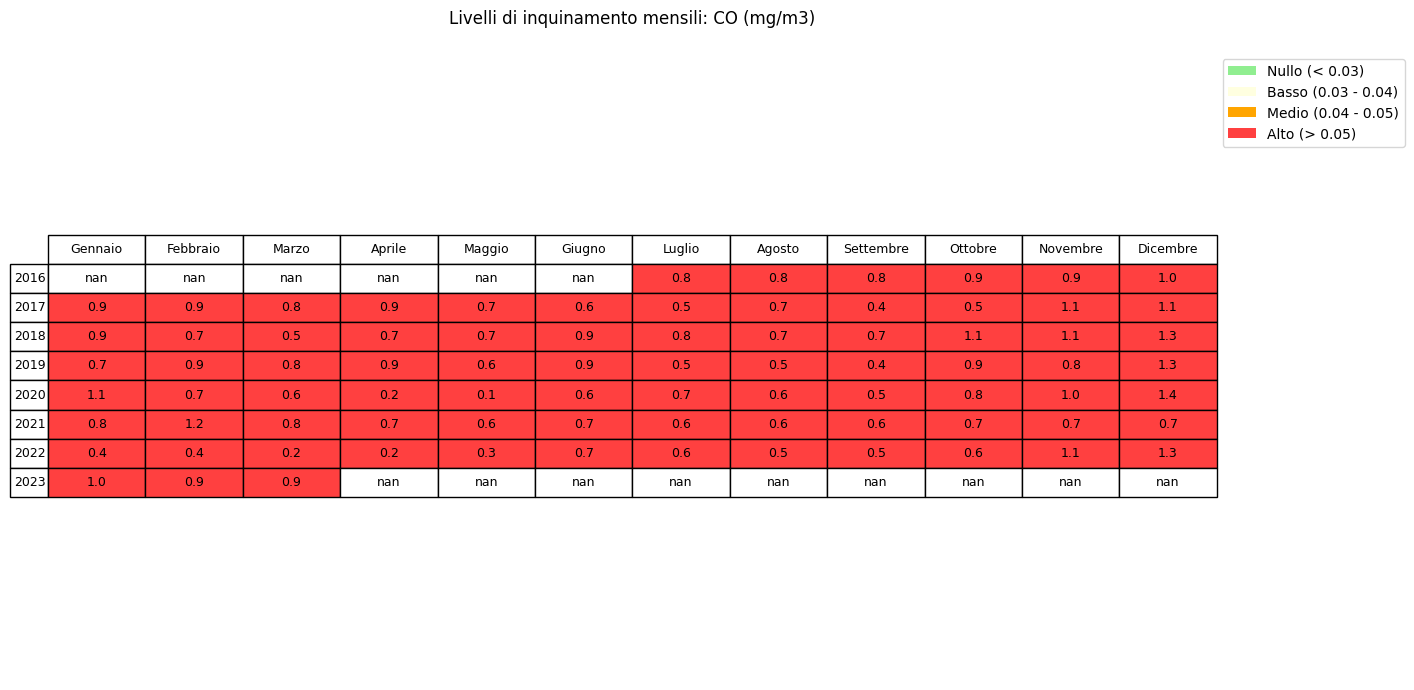

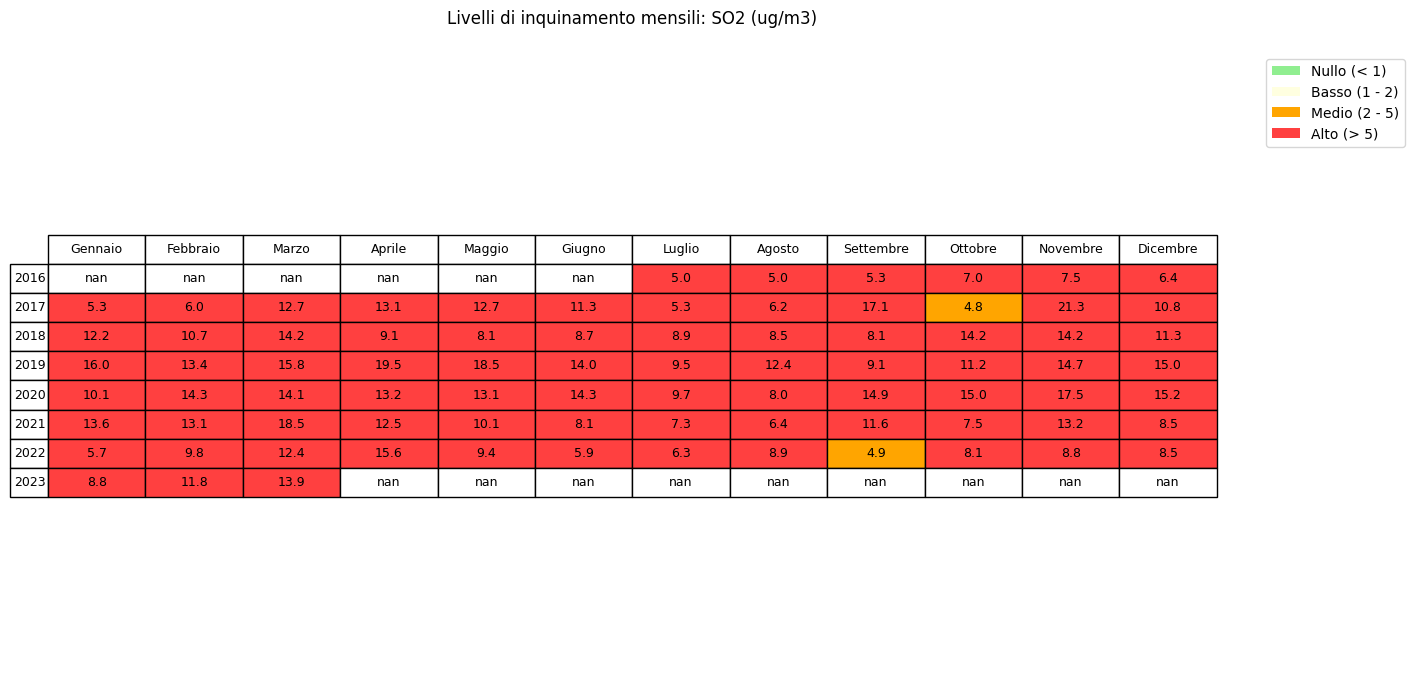

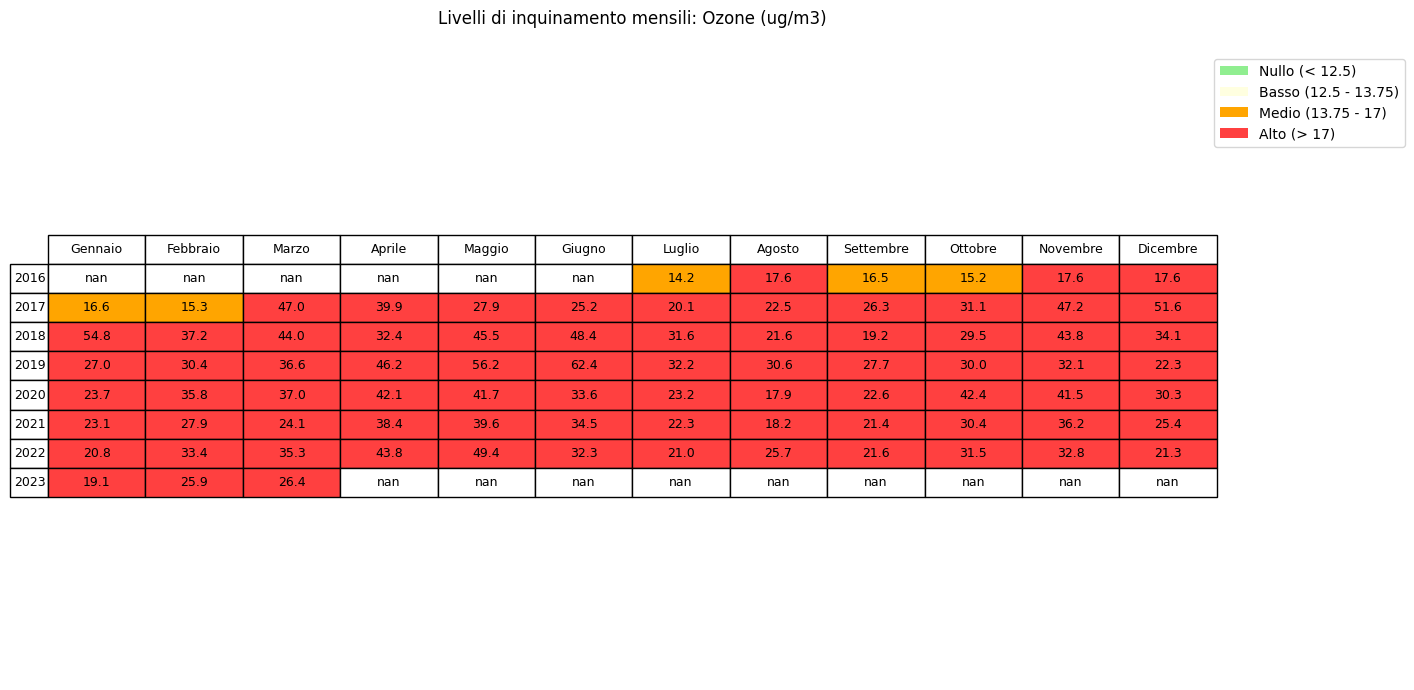

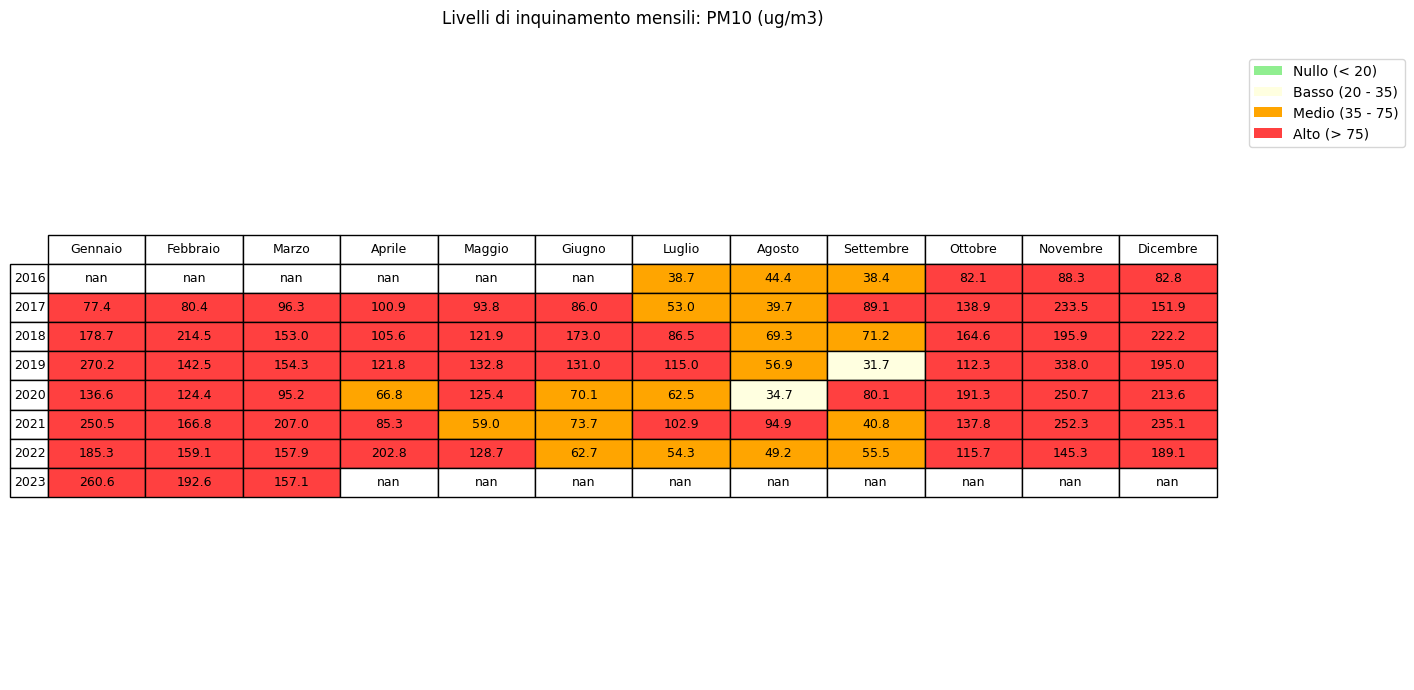

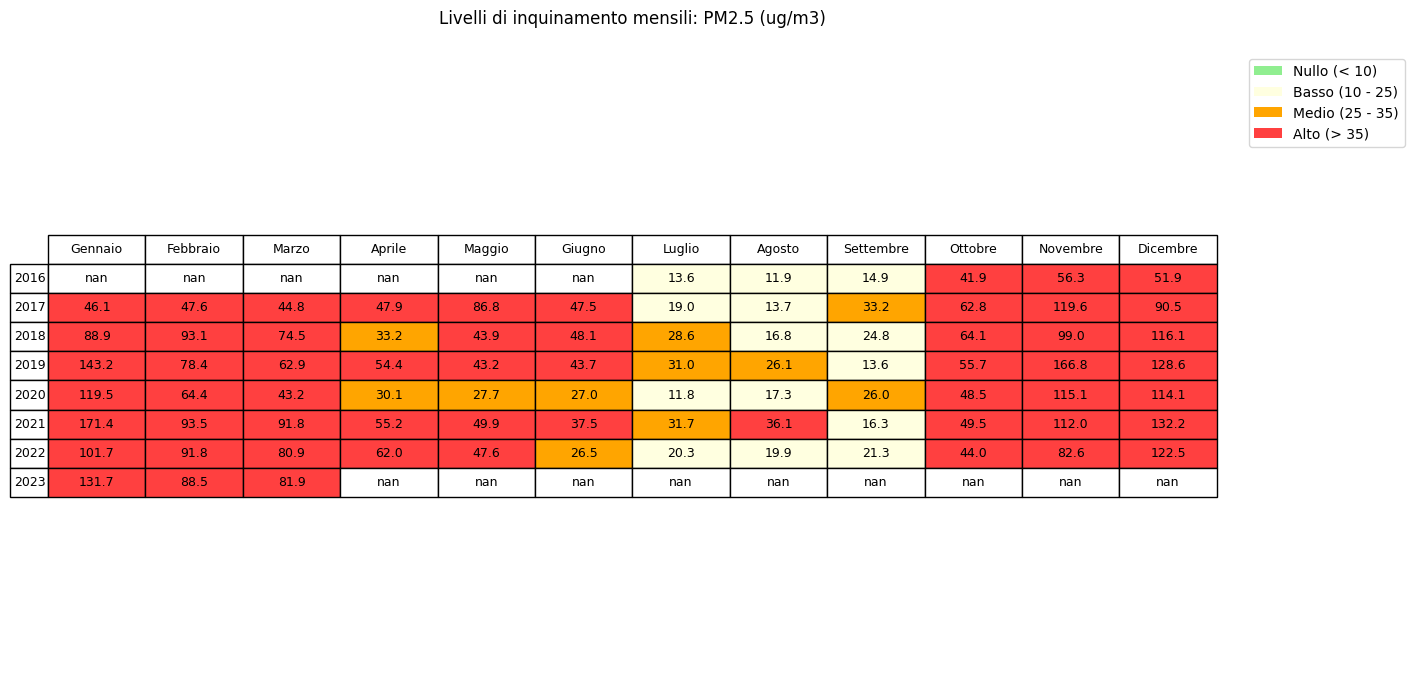

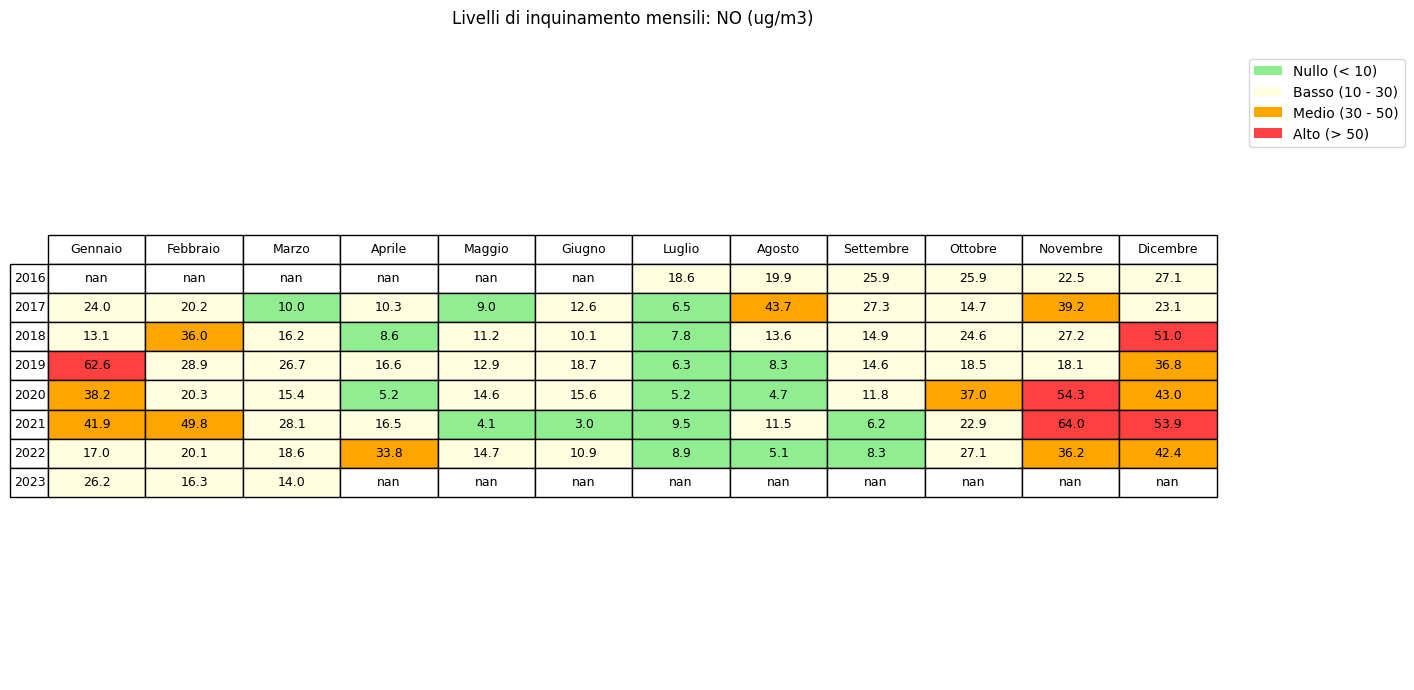

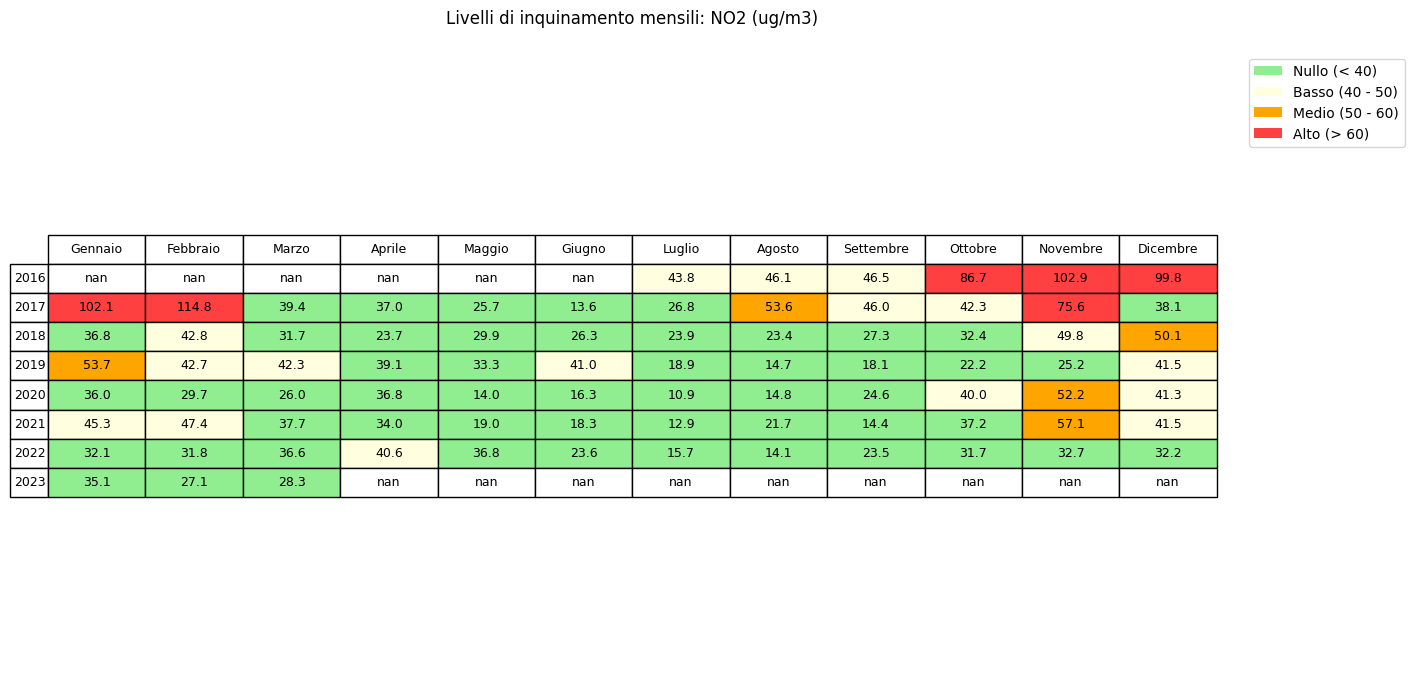

In [ ]:
pollutants1 = ['SO2 (ug/m3)', 'Ozone (ug/m3)']
pollutants2 = [ 'PM10 (ug/m3)', 'PM2.5 (ug/m3)']
pollutants3 = ['NO (ug/m3)', 'NO2 (ug/m3)']
pollutants4 = ['CO (mg/m3)']
for pollutant in (pollutants1+pollutants2+pollutants3+pollutants4):
    create_pollution_level_table(df, pollutant)

# CLASSIFICAZIONE

## Preparazione del dataset
In questa fase si prepara il dataset ad essere utilizzato, in particolare, seguendo anche ciò che si è descritto nell'analisi delle correlazioni, i passi fondamentali sono due:

1.   L'utilizzo del solo file csv DL023
2.   L'aggragazione dei dati orari in dati giornalieri



In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif, SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

dataset = '/content/drive/MyDrive/dataset_delhi_con_cond_atmosferiche.csv'
df = pd.read_csv(dataset)
df['Date'] = pd.to_datetime(df['From Date'])
df['From Date'] = pd.to_datetime(df['From Date'])

df.set_index('From Date', inplace=True)

#Uso solo DL023 e droppo la colonna
df_DL023_raw = df[df['file_name'] == 'DL023']
df_DL023_raw.drop('file_name', axis=1, inplace=True)

# Aggregazione con diverse funzioni
aggregazioni = {
    'Ozone (ug/m3)': 'mean',    # Media
    'NO (ug/m3)': 'mean',       # Media
    'NO2 (ug/m3)': 'mean',      # Media
    'CO (mg/m3)': 'mean',       # Media
    'PM2.5 (ug/m3)': 'mean',    # Media
    'PM10 (ug/m3)': 'mean',     # Media
    'SO2 (ug/m3)': 'mean',      # Media
    'AT (degree C)': 'mean',    # Media
    'BP (mmHg)': 'mean',        # Media
    'RH (%)': 'mean',           # Media
    'SR (W/mt2)': 'mean',       # Media
    'WD (deg)': 'mean',         # Media
    'WS (m/s)': 'mean',         # Media
    'RF (mm)': 'sum',           # Somma
    'Date': 'min',
}

#Downsampling giornaliero con aggregazione
df_delhi_aggregato = df.resample('D').agg(aggregazioni)
#df_delhi_aggregato.where(df_delhi_aggregato['file_name'] == 'DL023', inplace=True)
print(df_delhi_aggregato.iloc[0])


<ipython-input-3-8f17a0c657c0>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_DL023_raw.drop('file_name', axis=1, inplace=True)


Ozone (ug/m3)              34.790954
NO (ug/m3)                 92.922074
NO2 (ug/m3)                62.941743
CO (mg/m3)                  1.086622
PM2.5 (ug/m3)             221.501376
PM10 (ug/m3)              389.139546
SO2 (ug/m3)                17.900942
AT (degree C)              13.038937
BP (mmHg)                 995.494958
RH (%)                       68.1695
SR (W/mt2)                 86.394561
WD (deg)                  186.455885
WS (m/s)                    0.896112
RF (mm)                    25.389474
Date             2019-01-01 00:00:00
Name: 2019-01-01 00:00:00, dtype: object


Questa è una sezione fonamentale, sulla base della sostanza inquinante scelta, viene creata una colonna che si riferisce ai volori di inquinamento riferiti al giorno successivo rispetto alla riga in esame.

Esempio. Nella riga riferita al giorno 12/10/2018, nella collonna "pollutant_giorno_succ" verrà riportato il valore della sostanza "pollutant" nel giorno 13/10/2018.

In [ ]:
def prepare_next_day_data(df, date_column, pollutant):
    """
    Create next day columns for specified pollutants and prepare dataset for analysis.

    Parameters:
    df: DataFrame with the data
    date_column: name of the column containing dates
    pollutant_columns: list of pollutant column names to shift

    Returns:
    DataFrame with added next day columns and cleaned data
    """
    # Make sure the DataFrame is sorted by date
    df = df.sort_values(date_column)

    # Create a copy to avoid modifying the original DataFrame
    df_copia = df.copy()

    # Convert date column to datetime if it's not already
    df_copia[date_column] = pd.to_datetime(df_copia[date_column])

    # Create next day columns for each pollutant
    next_day_column = f"{pollutant}_giorno_succ"
    df_copia[next_day_column] = df_copia[pollutant].shift(-1)
    return df_copia




Sulla base della colonna creata in precedenza, si vanno a creare due colonne categoriche, una per la classificazione binaria e un'altra per quella multi classe. In particolare, sulla base di soglie che sono state definite, vegnono create delle etichette categoriche su cui poi verrà eseguita la classificazione.
Verrà creato un df diverso per ogni sostanza, in cui quindi le etichette fanno riferimento ai volori dell'inquinante scelto.

N.B. visto che le soglie dell'OMS erano troppo basse per i valori dell'India (vedi tabelle con soglie) si è deciso di creare delle soglie ad hoc che peremettesero di definire un'inquinamento da "Nullo" ad "Alto" sulla base dello storico dei valori nazionali.

In [ ]:
thresholds = {
    'CO (mg/m3)': {
        'nullo': 0.45,
        'basso': 0.7,
        'medio': 0.9,
        'alto': float('inf')
    },
    'SO2 (ug/m3)': {
        'nullo': 8,
        'basso': 12,
        'medio': 16,
        'alto': float('inf')
    },
    'Ozone (ug/m3)': {
        'nullo': 23,
        'basso': 30,
        'medio': 40,
        'alto': float('inf')
    },
    'PM10 (ug/m3)': {
        'nullo': 70,
        'basso': 125,
        'medio': 200,
        'alto': float('inf')
    },
    'PM2.5 (ug/m3)': {
        'nullo': 30,
        'basso': 55,
        'medio': 100,
        'alto': float('inf')
    },
    'NO (ug/m3)': {
        'nullo': 7,
        'basso': 14,
        'medio': 28,
        'alto': float('inf')
    },
    'NO2 (ug/m3)': {
        'nullo': 20,
        'basso': 30,
        'medio': 45,
        'alto': float('inf')
    }
}


def create_pollution_labels(df, pollutant, thresholds, type):
    """
    Create binary and multiclass pollution labels

    Parameters:
    df: DataFrame with pollution data
    pollutant_col: column name for the pollutant
    thresholds: dict with keys 'low', 'medium', 'high' for classification boundaries
    type: number, 0 for binary labels or 1 for multi labels
    """
    df_copy = df.copy()
    df = prepare_next_day_data(df_copy, 'Date', pollutant)

    if type == 0:

      df[f'{pollutant}_binary_label'] = np.where(
            df[f'{pollutant}_giorno_succ'] > thresholds[pollutant]['basso'],
            'Inquinato',
            'Non Inquinato'
        )
    else:

      conditions = [
            (df[f'{pollutant}_giorno_succ'] <= thresholds[pollutant]['nullo']),
            (df[f'{pollutant}_giorno_succ'] <= thresholds[pollutant]['basso']),
            (df[f'{pollutant}_giorno_succ'] <= thresholds[pollutant]['medio']),
            (df[f'{pollutant}_giorno_succ'] > thresholds[pollutant]['medio'])
        ]
      choices = ['Nullo', 'Basso', 'Medio', 'Alto']
      df[f'{pollutant}_multi_label'] = np.select(conditions, choices)

    #Elimina l'ultima riga del df che rimane senza label
    df.drop(df.index[-1], inplace = True)
    df.drop([f'{pollutant}_giorno_succ','Date'], axis=1, inplace=True)
    return df


Creazione dei df binari (si creano specificando il parametro "type" uguale a 0 nella funzione)

In [ ]:
#Creazione df binari
polls = ['Ozone (ug/m3)', 'CO (mg/m3)', 'SO2 (ug/m3)', 'PM10 (ug/m3)', 'PM2.5 (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)']
df_binary_label = {}
for poll in polls:
  df_binary_label[poll] = create_pollution_labels(df_delhi_aggregato, poll, thresholds, 0)


## Classe FeatureSelector
Contiene metodi per scegliere le feature migliori con cui effettuare/basare la classificazione.
Utilizza tre metodi:

**Correlazione**: è una particolare correlazione (non Pearson), utilizza il "correlation ratio", che ci permette di misurare la correlazione fra label categoriche (il o i labels) e continue (i valori delle altre colonne)
*   **Mutual_information**: calcola quanto sapere il valore di una feature riduce l'incertezza sulla variabile target (e viceversa). Inolre, non assume nessuna relazione lineare tra le variabili perciò si usa anche nelle categoriche
*   **ANOVA**: Si usa molto nei casi in cui si vogliono usare target categorici e feature numeriche (nostro caso) Si basa sul confronto (rapporto) tra:
      * Varianza tra i gruppi (quanto la media dei gruppi differisce dalla media generale).
      * Varianza interna ai gruppi (quanto i dati all'interno di un gruppo sono sparsi rispetto alla media del gruppo).
Se il valore del rapporto è alto significa che la feature è fortemente legata al target.
*   **Random_forest**: usando un random forest classifier, segna quale feature sono più importanti nel creare gli alberi decisionali di classificazione e gli assegna un punteggio

Ci sono poi anche metodi per fare il plot degli output dei sistemi sopra.

Il metodo "eval_feature_sets" permette di valutare, nell'ambito della classificazione scelta (type = 0 binaria, type = 1 multi-classe), le performance di diversi modelli di classificazione utilizzando le feature estratte con i diversi metodi.
In questa maniera, considerando 4 metodi di estrazione di feature e 6 classificatori predefiniti, si potranno confrontare le performance di 24 configurazioni diverse. Viene anche data la possibilità di scegliere solo alcuni classificatori dalla lista predefinita. Inoltre, per evitare lookahead, si è scelto di utilizzare il metodo hold-out per dividere tra training e test.

I parametri n_jobs del metodo e n_features della classe permettono rispettivamente di parallelizzare (sulla base delle cpu core disponibili) e di definire il numero di feature da estrarre e utilizzare nelle classificazioni. Sono due parametri inseriti per permettere di regolare la complessità computazionale sulla base di diverse disèonibilità hardoware e diverse esigenze.





In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import make_scorer, roc_auc_score, precision_score, recall_score, f1_score
from joblib import Parallel, delayed

class FeatureSelector:
    def __init__(self, df, target_col, n_features=3, classifier_names=None):
        """
        Inizializza la classe FeatureSelector.

        Args:
            df (pd.DataFrame): Il dataset.
            target_col (str): Il nome della colonna target.
            n_features (int): Numero di feature da selezionare per ogni metodo.
            classifier_names (list): Elenco dei nomi dei classificatori da utilizzare (opzionale).
        """
        self.df = df
        self.target_col = target_col
        self.n_features = n_features
        self.feature_cols = [col for col in df.columns if col != target_col]

        # Encode target se è categorico
        self.le = LabelEncoder()
        if df[target_col].dtype == 'object':
            self.y = self.le.fit_transform(df[target_col])
        else:
            self.y = df[target_col].values

        self.X = df[self.feature_cols]

        # Classificatori predefiniti divisi tra binari e multipli
        self.binary_classifiers = {
            'Logistic Regression': LogisticRegression(max_iter=500, class_weight='balanced', n_jobs=-1),
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1),
            'Gradient Boosting': GradientBoostingClassifier(random_state=42, subsample=0.8),
            'SVC (linear)': SVC(kernel='linear', probability=True, random_state=42, class_weight='balanced'),
            'KNN': KNeighborsClassifier(n_jobs=-1),
            'Decision Tree': DecisionTreeClassifier(random_state=42, class_weight='balanced')
        }

        self.multi_class_classifiers = {
            'Logistic Regression': LogisticRegression(max_iter=10000, solver='saga', class_weight='balanced', n_jobs=-1),
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1),
            'HistGradientBoosting': HistGradientBoostingClassifier(random_state=42, max_leaf_nodes=25),
            'SVC (linear)': SVC(kernel='linear', probability=True, random_state=42, class_weight='balanced'),
            'Naive Bayes': GaussianNB(),
            'Decision Tree': DecisionTreeClassifier(random_state=42, class_weight='balanced', max_leaf_nodes=25)
        }

        # Salva i nomi specificati
        self.classifier_names = classifier_names

    def get_classifiers(self, type):
        """
        Ritorna i classificatori da utilizzare in base al tipo e ai nomi specificati.
        """
        classifiers = self.binary_classifiers if type == 0 else self.multi_class_classifiers

        if self.classifier_names:
            # Filtra i classificatori in base ai nomi specificati
            filtered_classifiers = {name: clf for name, clf in classifiers.items() if name in self.classifier_names}
            if len(filtered_classifiers) == 0:
                print("I nomi dei classificatori specificati non sono validi per il tipo selezionato. Uso i predefiniti.")
                return classifiers
            return filtered_classifiers
        else:
            # Usa i classificatori predefiniti
            return classifiers

    def correlation_selection(self):
        """Select features based on correlation ratio with target"""
        correlations = {}

        for feature in self.feature_cols:

            feature_values = self.df[feature]
            means_per_class = self.df.groupby(self.target_col)[feature].mean()
            overall_mean = feature_values.mean()

            # Calcola la varianza between-class
            n_samples_per_class = self.df.groupby(self.target_col)[feature].count()
            between_class_var = ((means_per_class - overall_mean) ** 2 * n_samples_per_class).sum() / len(feature_values)

            # Calcola la varianza totale
            total_var = feature_values.var()

            # Correlation ratio
            correlation_ratio = np.sqrt(between_class_var / total_var) if total_var != 0 else 0
            correlations[feature] = correlation_ratio

        return pd.Series(correlations).sort_values(ascending=False)[:self.n_features]

    def mutual_information_selection(self):
        """Select features based on mutual information"""
        mi_scores = mutual_info_classif(self.X, self.y)
        mi_series = pd.Series(mi_scores, index=self.feature_cols)
        return mi_series.sort_values(ascending=False)[:self.n_features]

    def anova_selection(self):
        """Select features based on ANOVA F-value"""
        selector = SelectKBest(score_func=f_classif, k=self.n_features)
        selector.fit(self.X, self.y)
        scores = pd.Series(selector.scores_, index=self.feature_cols)
        return scores.sort_values(ascending=False)[:self.n_features]

    def random_forest_selection(self):
        """Select features based on Random Forest importance"""
        rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=2)
        rf.fit(self.X, self.y)
        importance = pd.Series(rf.feature_importances_, index=self.feature_cols)
        return importance.sort_values(ascending=False)[:self.n_features]

    def plot_feature_importance(self, method_results):
        """Plot feature importance for each method"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle(f'Feature Importance by Different Methods for Target: {self.target_col}')

        for (method_name, scores), ax in zip(method_results.items(), axes.ravel()):
            scores.plot(kind='bar', ax=ax)
            ax.set_title(method_name)
            ax.tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()

    def compare_methods(self):
        """Compare all feature selection methods"""
        methods = {
            'Correlation': self.correlation_selection(),
            'Mutual Information': self.mutual_information_selection(),
            'ANOVA': self.anova_selection(),
            'Random Forest': self.random_forest_selection()
        }


        all_scores = pd.DataFrame(methods)

        # Calcola quante volte una feature compare nei 4 metodi
        feature_counts = pd.Series(
            [feature for method in methods.values() for feature in method.index]
        ).value_counts()

        print("Features that appear in multiple methods:")
        print(feature_counts[feature_counts > 1])

        self.plot_feature_importance(methods)

        return all_scores, feature_counts

    def evaluate_classifier(self, clf_name, clf, X_selected, y, type):
        """Valuta un singolo classificatore su un dataset selezionato utilizzando l'holdout (70/30)."""
        # Determina il punto di separazione per il 70/30 split
        split_index = int(len(X_selected) * 0.7)

        # Training e test ordinati temporalmente
        X_train, X_test = X_selected.iloc[:split_index], X_selected.iloc[split_index:]
        y_train, y_test = y[:split_index], y[split_index:]

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        # Calcola le metriche
        precision = precision_score(y_test, y_pred, average=None, labels=np.unique(y))
        recall = recall_score(y_test, y_pred, average=None, labels=np.unique(y))
        f1 = f1_score(y_test, y_pred, average=None, labels=np.unique(y))

        roc_auc = None
        if type == 0 and len(np.unique(y)) == 2:  # Calcola ROC AUC solo per classificazione binaria
            roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

        # Metriche globali
        metrics = {
            'Precision': np.mean(precision),
            'Recall': np.mean(recall),
            'F1 Score': np.mean(f1),
        }

        if roc_auc is not None:
            metrics['ROC AUC'] = roc_auc

        # Metriche per classe
        for idx, cls in enumerate(np.unique(y)):
            metrics[f'Class {cls}_Precision'] = precision[idx]
            metrics[f'Class {cls}_Recall'] = recall[idx]
            metrics[f'Class {cls}_F1 Score'] = f1[idx]

        return {**{'Classifier': clf_name}, **metrics}

    def evaluate_feature_method(self, method_name, features, classifiers, X, y, type, n_jobs):
        """Valuta un metodo di selezione delle feature con tutti i classificatori."""
        X_selected = X[features]

        results = Parallel(n_jobs=n_jobs)(
            delayed(self.evaluate_classifier)(clf_name, clf, X_selected, y, type)
            for clf_name, clf in classifiers.items()
        )
        for result in results:
            result['Method'] = method_name
        return results

    def eval_feature_sets(self, cv=3, type=0, n_jobs=-1):
        """Valuta tutte le combinazioni di metodi di selezione delle feature e classificatori."""
        methods = {
            'Correlation': self.correlation_selection().index,
            'Mutual Information': self.mutual_information_selection().index,
            'ANOVA': self.anova_selection().index,
            'Random Forest': self.random_forest_selection().index
        }

        classifiers = self.get_classifiers(type)

        results = Parallel(n_jobs=n_jobs)(
            delayed(self.evaluate_feature_method)(method_name, features, classifiers, self.X, self.y, type, n_jobs)
            for method_name, features in methods.items()
        )


        results_flattened = [item for sublist in results for item in sublist]
        results_df = pd.DataFrame(results_flattened)

        return results_df



In [ ]:
selector_binary = {}
for key, value in df_binary_label.items():
  selector_binary[f'{key}'] = FeatureSelector(value, f'{key}_binary_label')

  print(f'Valutazione sbilanciamento classi per dataframe con classi inquinamento su {key}')
  # Verifica distribuzione classi
  print("Distribuzione delle classi:")
  print(value[f'{key}_binary_label'].value_counts(normalize=True))


Valutazione sbilanciamento classi per dataframe con classi inquinamento su Ozone (ug/m3)
Distribuzione delle classi:
Ozone (ug/m3)_binary_label
Non Inquinato    0.527742
Inquinato        0.472258
Name: proportion, dtype: float64
Valutazione sbilanciamento classi per dataframe con classi inquinamento su CO (mg/m3)
Distribuzione delle classi:
CO (mg/m3)_binary_label
Non Inquinato    0.543226
Inquinato        0.456774
Name: proportion, dtype: float64
Valutazione sbilanciamento classi per dataframe con classi inquinamento su SO2 (ug/m3)
Distribuzione delle classi:
SO2 (ug/m3)_binary_label
Non Inquinato    0.578065
Inquinato        0.421935
Name: proportion, dtype: float64
Valutazione sbilanciamento classi per dataframe con classi inquinamento su PM10 (ug/m3)
Distribuzione delle classi:
PM10 (ug/m3)_binary_label
Non Inquinato    0.504516
Inquinato        0.495484
Name: proportion, dtype: float64
Valutazione sbilanciamento classi per dataframe con classi inquinamento su PM2.5 (ug/m3)
Distrib

Features that appear in multiple methods:
Ozone (ug/m3)    4
RH (%)           4
SR (W/mt2)       2
PM2.5 (ug/m3)    2
Name: count, dtype: int64


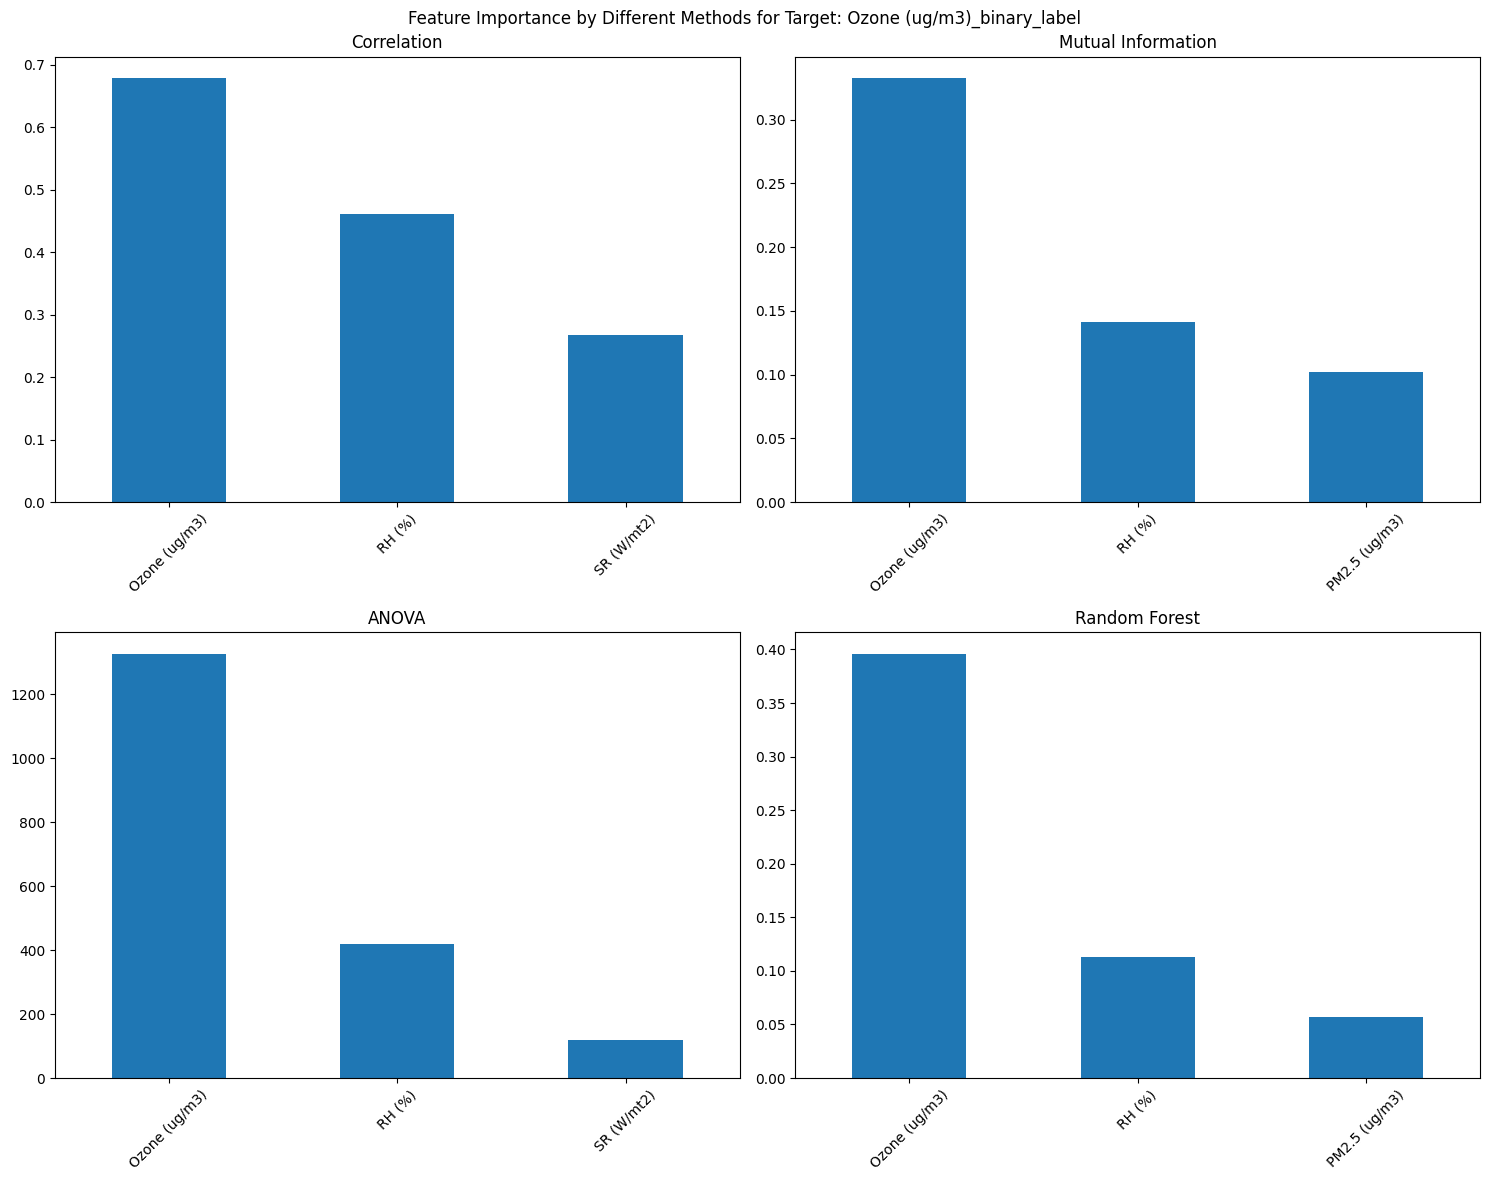

Features that appear in multiple methods:
CO (mg/m3)       4
SR (W/mt2)       4
PM2.5 (ug/m3)    3
Name: count, dtype: int64


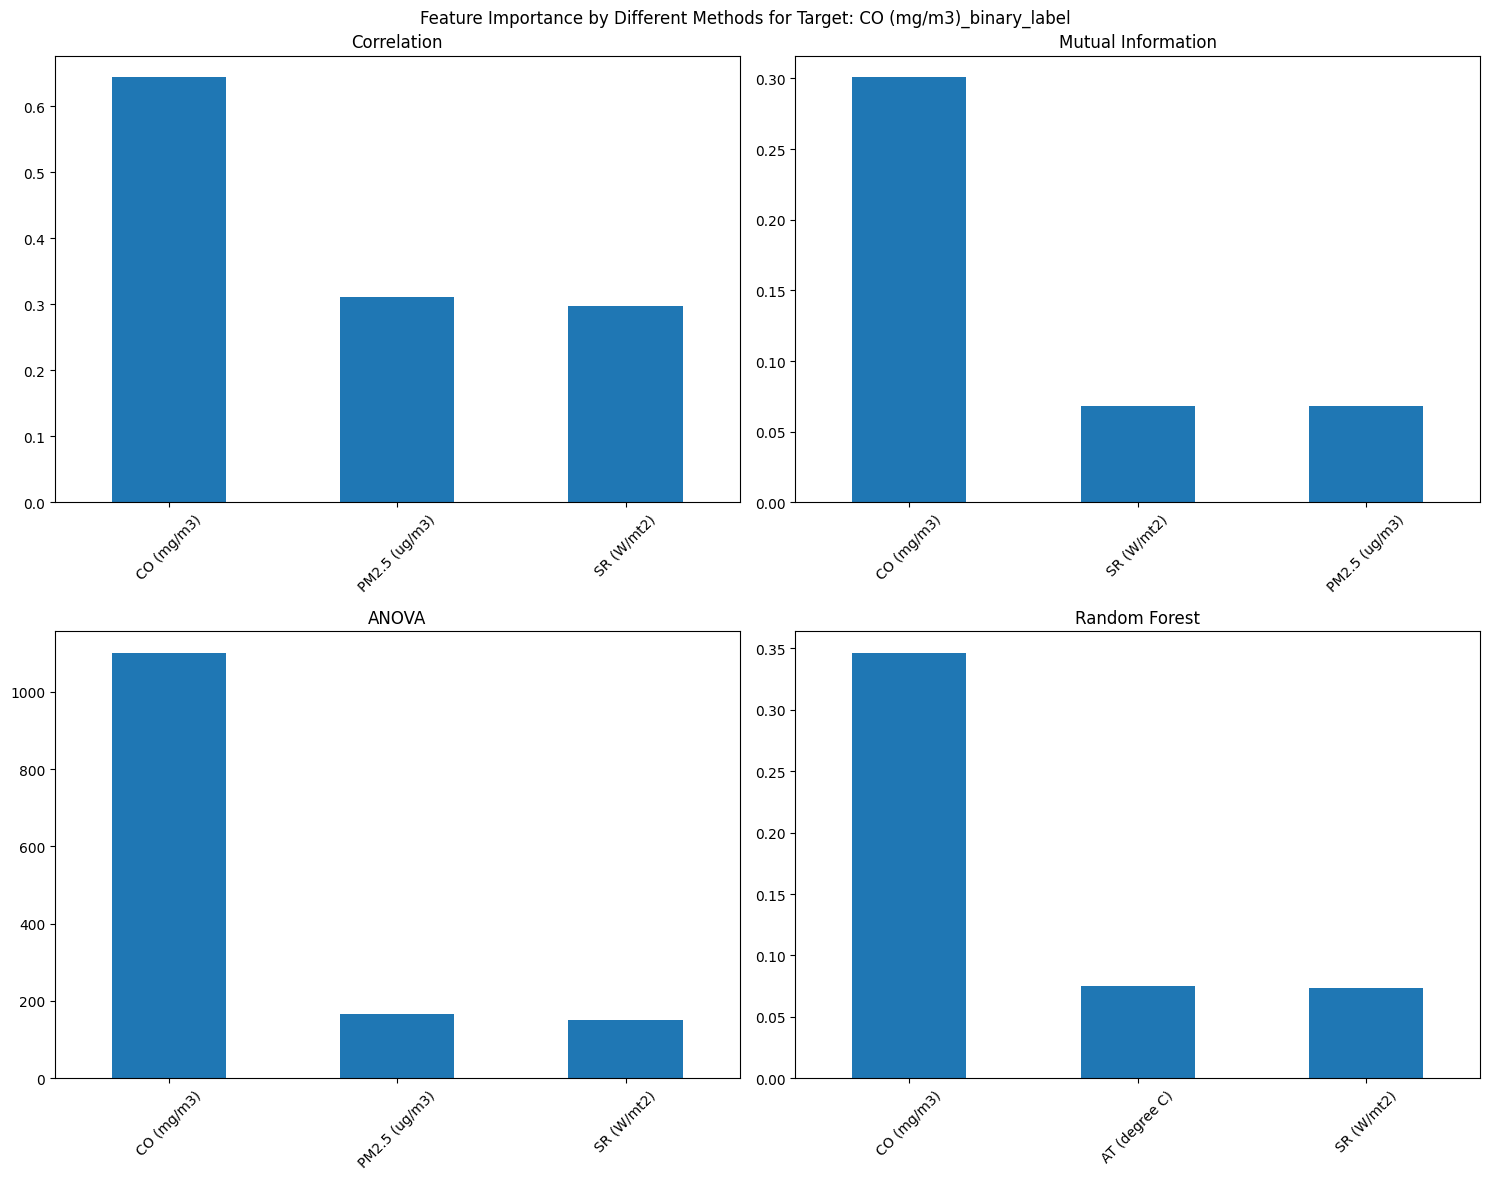

Features that appear in multiple methods:
SO2 (ug/m3)      4
RH (%)           3
Ozone (ug/m3)    2
PM10 (ug/m3)     2
Name: count, dtype: int64


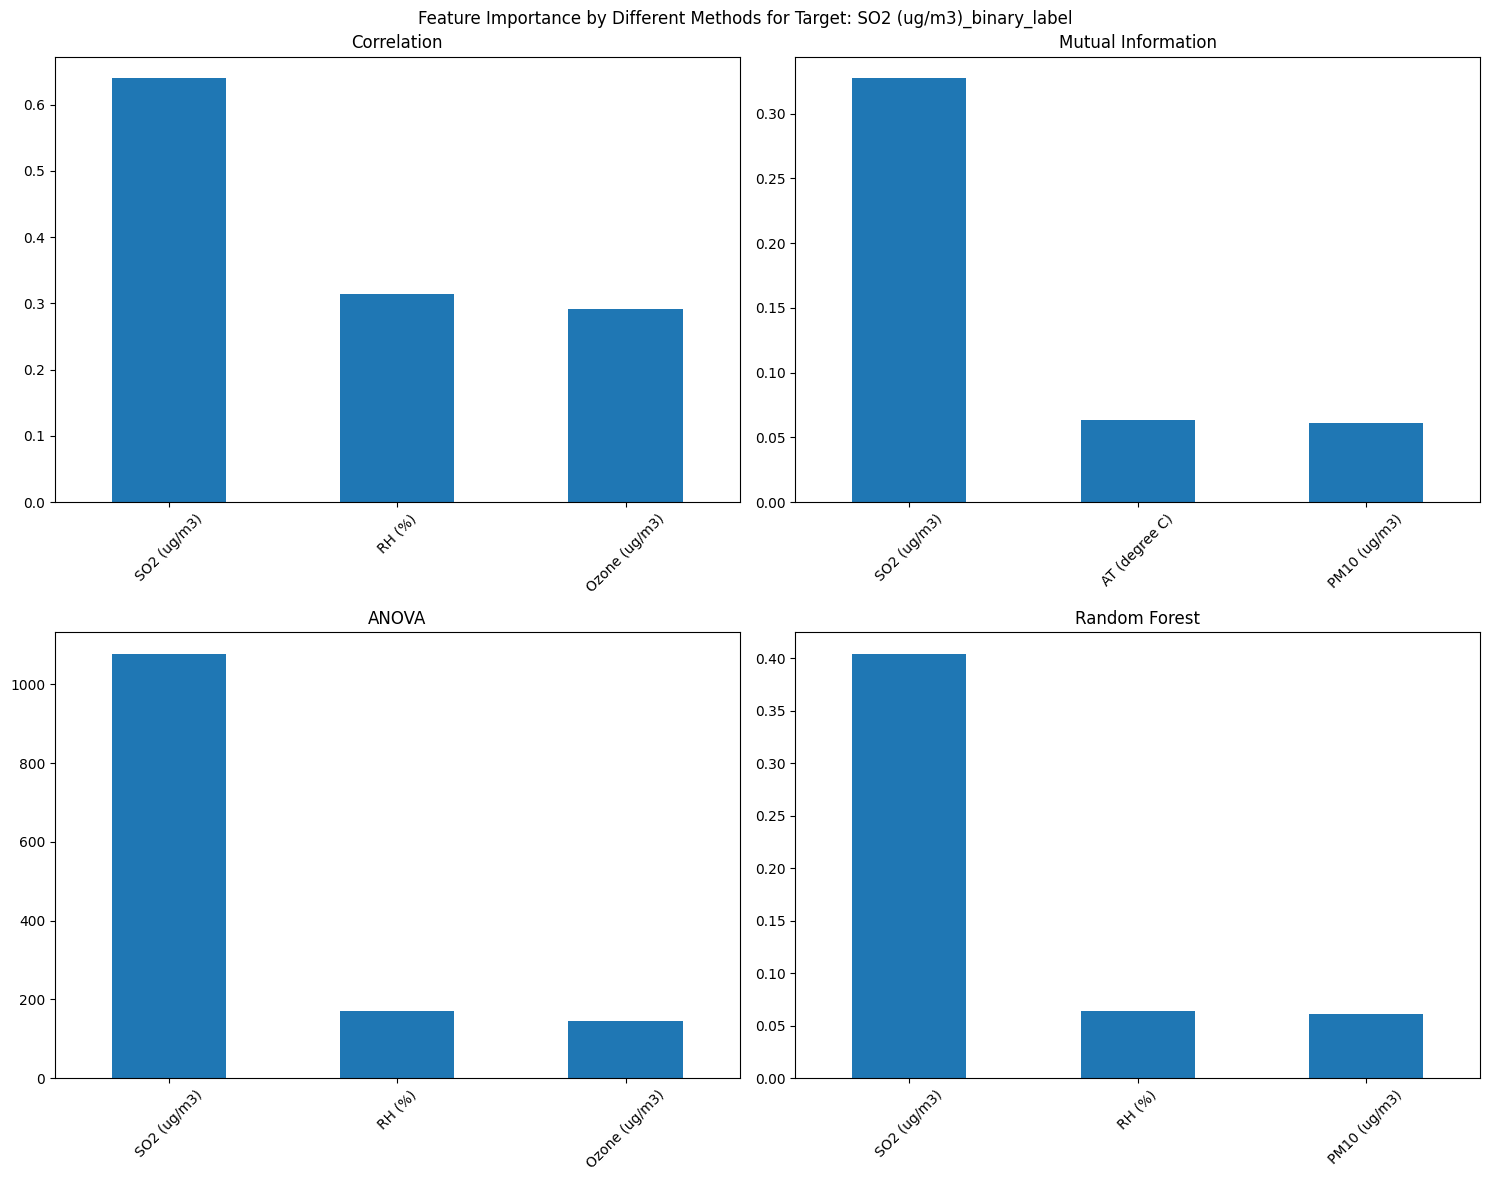

Features that appear in multiple methods:
PM10 (ug/m3)     4
PM2.5 (ug/m3)    4
NO2 (ug/m3)      2
Name: count, dtype: int64


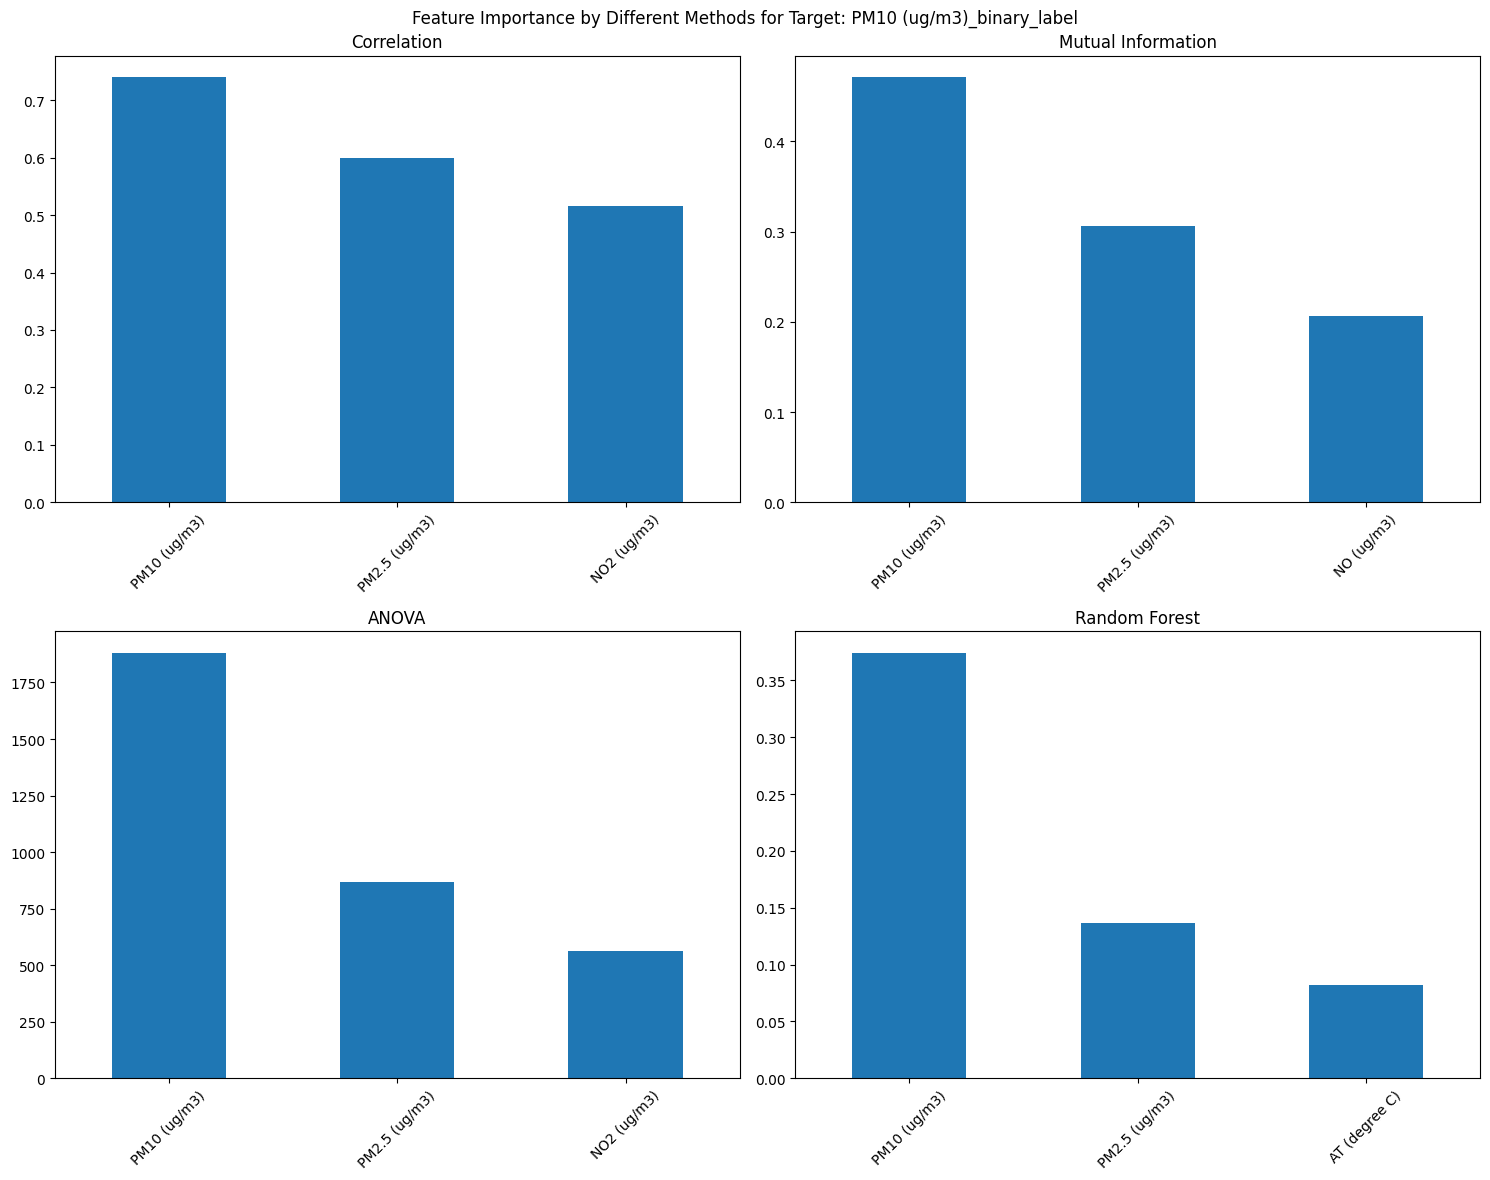

Features that appear in multiple methods:
PM2.5 (ug/m3)    4
AT (degree C)    4
PM10 (ug/m3)     4
Name: count, dtype: int64


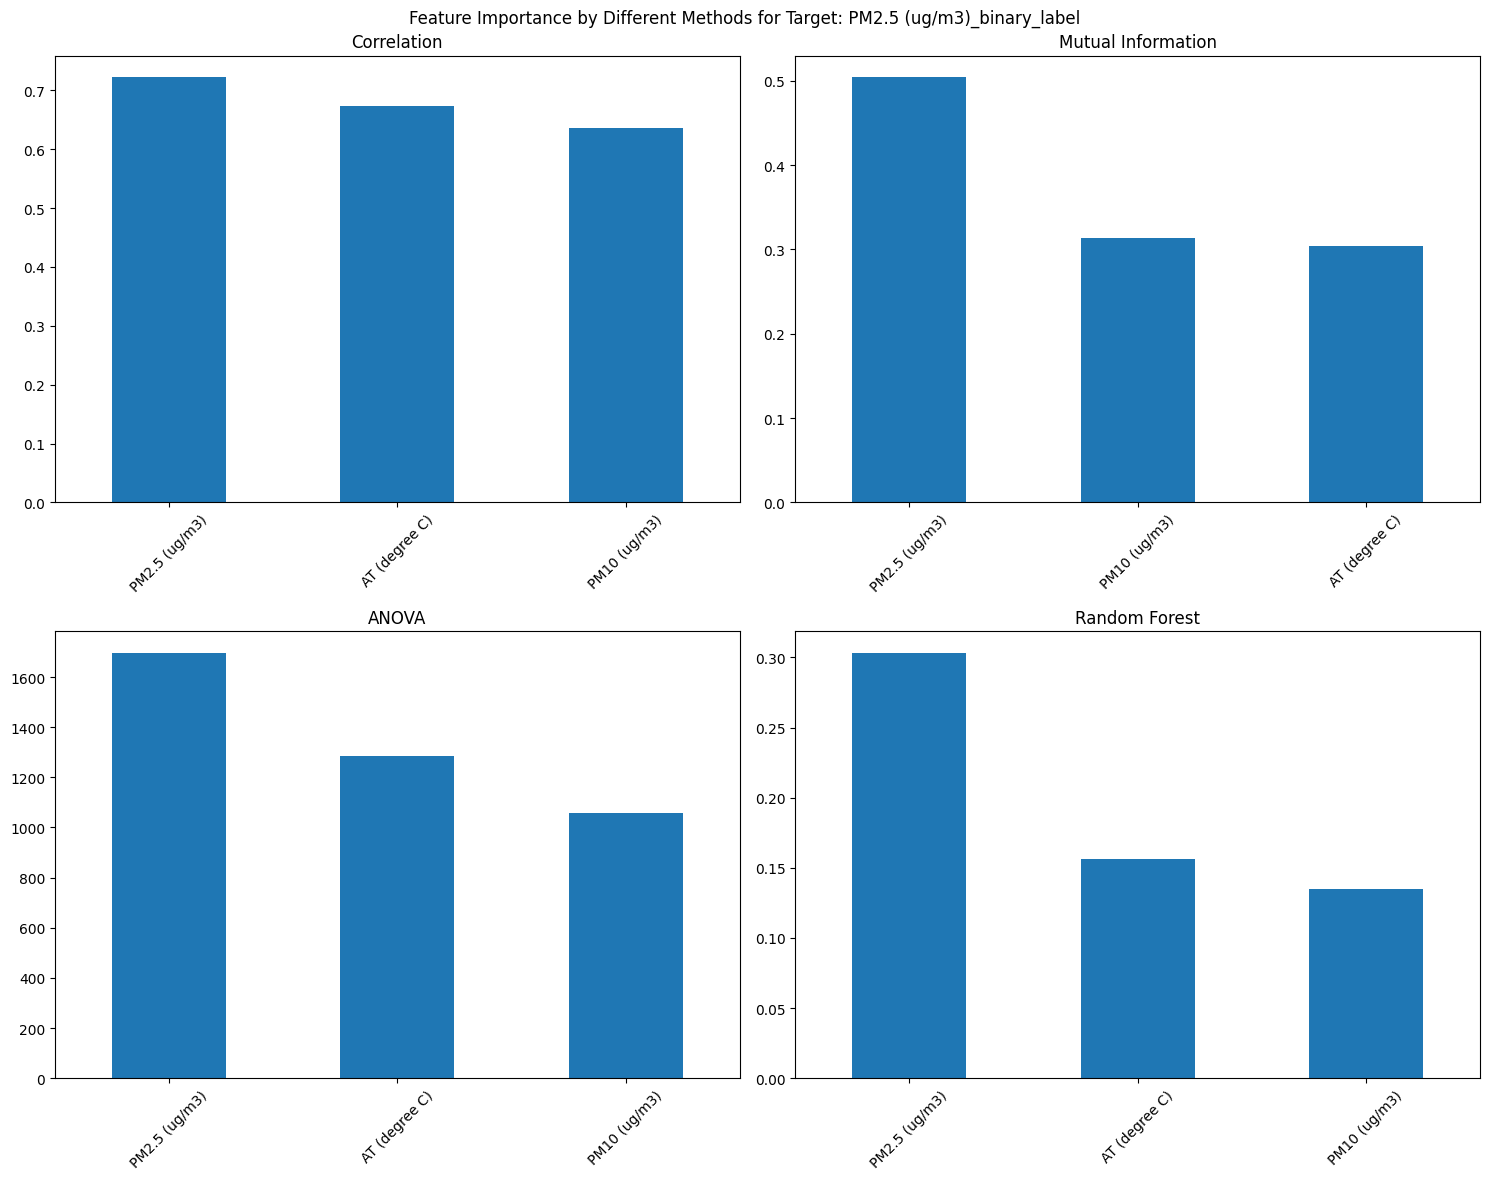

Features that appear in multiple methods:
NO (ug/m3)      4
NO2 (ug/m3)     4
PM10 (ug/m3)    4
Name: count, dtype: int64


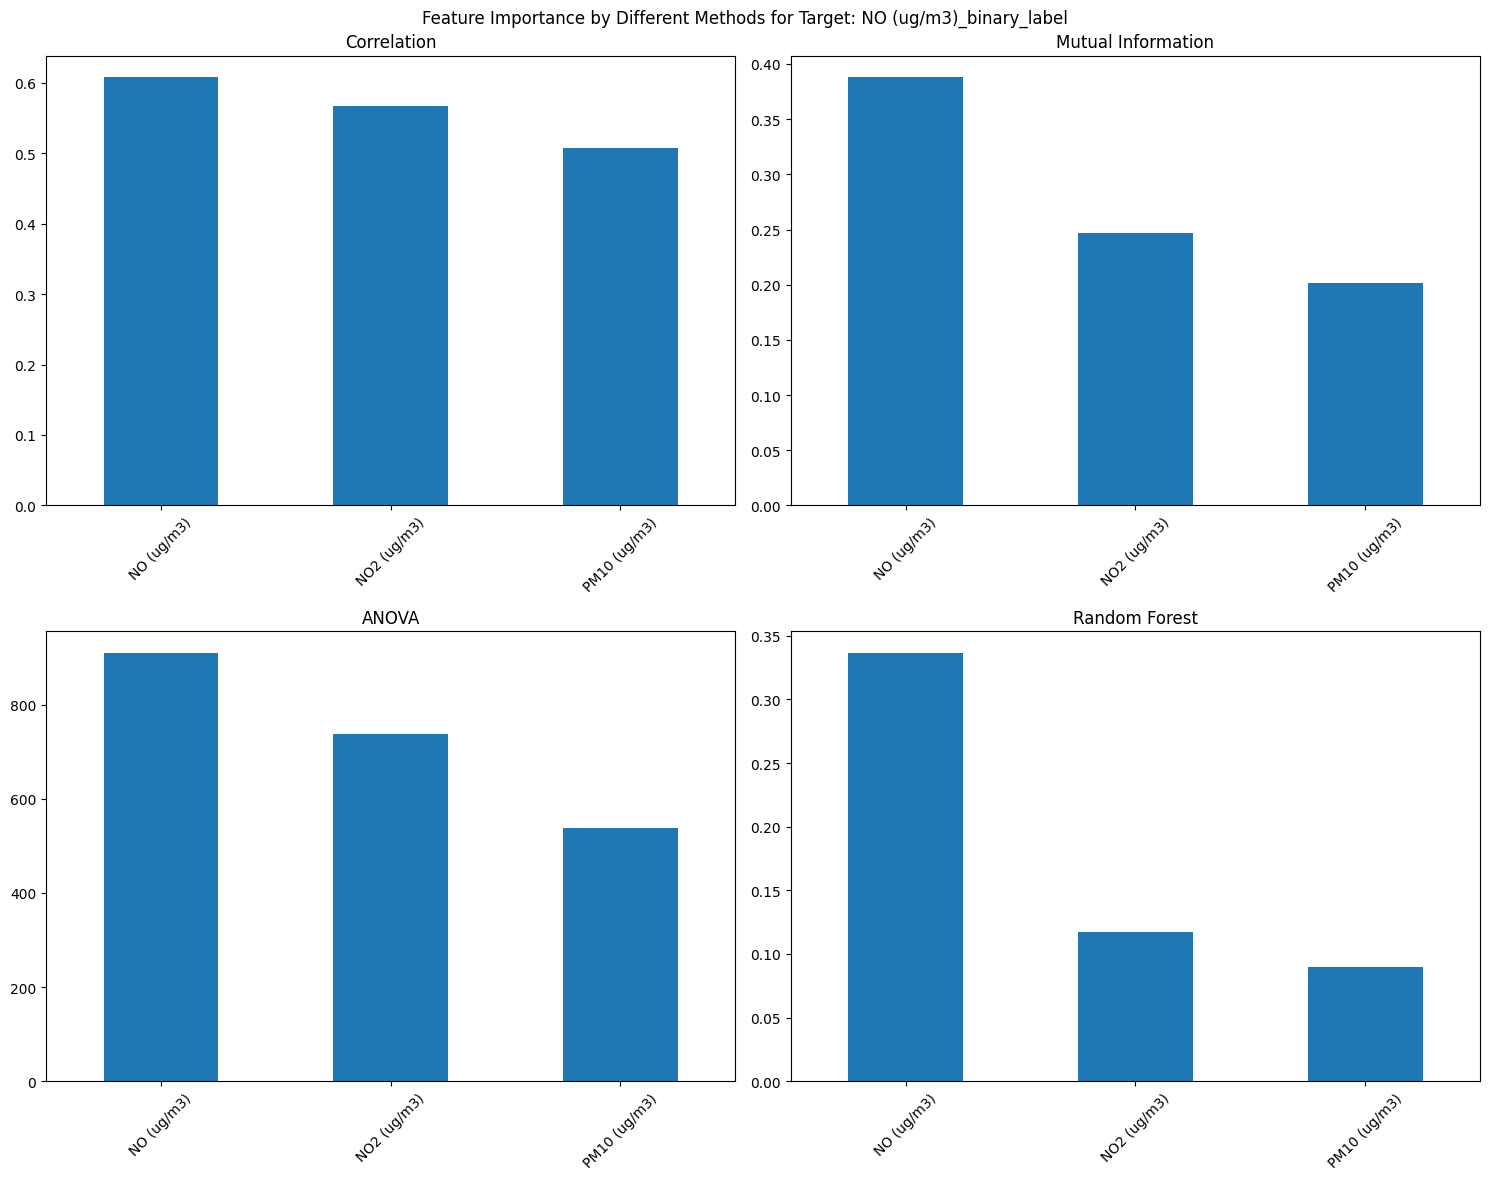

Features that appear in multiple methods:
NO2 (ug/m3)     4
NO (ug/m3)      4
PM10 (ug/m3)    3
Name: count, dtype: int64


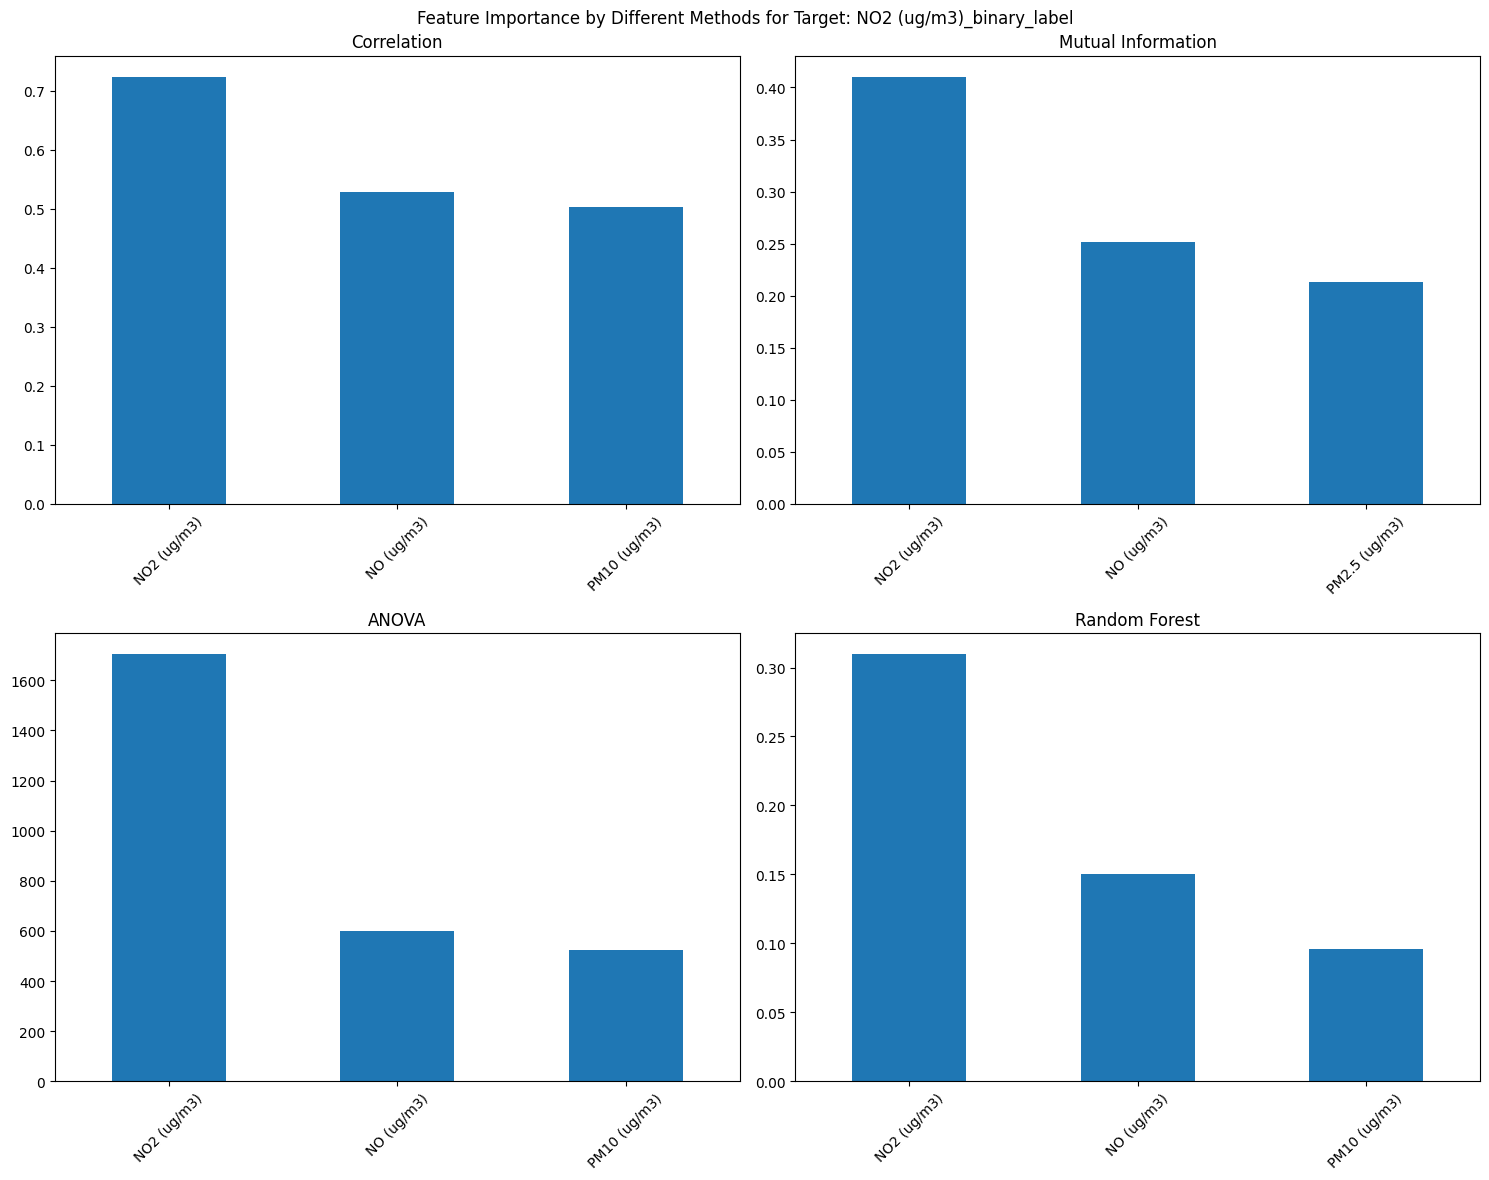

In [ ]:
for key, value in df_binary_label.items():

  # Ottieni i risultati
  scores_binary, feature_counts_binary = selector_binary[f'{key}'].compare_methods()

Metodi per stampare tabelle e grafici riguardo le performance dei classificatori

In [ ]:
def plot_scores_table(results):
    """
    Crea una tabella che mostra le metriche medie calcolate per ogni classificatore e metodo.

    Parametri:
    - results: pd.DataFrame, output della funzione `evaluate_feature_sets`.
    """

    if not isinstance(results, pd.DataFrame):
        raise ValueError("The results parameter must be a pandas DataFrame.")

    # Creazione della figura
    fig, ax = plt.subplots(figsize=(16, len(results) * 0.5))


    ax.axis("tight")
    ax.axis("off")

    # Creazione della tabella
    table = ax.table(
        cellText=results.round(3).values,  # Arrotonda i valori a 3 cifre decimali
        colLabels=results.columns,
        loc="center",
        cellLoc="center"
    )

    # Miglioramento estetico
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width(col=list(range(len(results.columns))))


    plt.title("Classifier Performance by Feature Selection Method (Aggregated)", fontsize=14)
    plt.show()

def plot_multi_class_results(results_df, target_label=None):
    """
    Visualizza una heatmap per ogni classe per ogni metrica.

    Parametri:
    - results_df: pd.DataFrame, DataFrame risultante da evaluate_feature_sets()
    - target_label: str, optional, etichetta target per il titolo dei grafici
    """
    label_info = f" - Label: {target_label}" if target_label else ""

    # Identifica tutte le colonne che rappresentano le metriche per classe
    class_columns = [col for col in results_df.columns if 'Class' in col]

    if not class_columns:
        raise ValueError("Non ci sono metriche per classe nel DataFrame.")

    # Itera su ogni classe (Class 0, Class 1, ...)
    for class_column in class_columns:

        class_label = class_column.split('_')[0]
        if class_label == 'Class 0':
          label_info = " - Label: Nullo"
        elif class_label == 'Class 1':
          label_info = " - Label: Basso"
        elif class_label == 'Class 2':
          label_info = " - Label: Medio"
        elif class_label == 'Class 3':
          label_info = " - Label: Alto"

        if class_label != 'Classifier':
          class_metric=class_column.split('_')[1]
          # Crea una tabella pivot per la classe attuale
          pivot_data = results_df.pivot(index='Classifier', columns='Method', values=class_column)

          # Filtra solo i valori numerici
          pivot_data = pivot_data.apply(pd.to_numeric, errors='coerce')

          # Verifica che pivot_data contenga solo valori validi
          if pivot_data.isnull().values.any():
              print(f"Attenzione: Pivot data per {class_label} contiene valori nulli!")
              pivot_data = pivot_data.fillna(0)


          plt.figure(figsize=(15, 10))
          sns.heatmap(pivot_data, annot=True, cmap='YlOrRd', fmt='.3f')
          plt.title(f'{class_label} Metric {class_metric} Heatmap{label_info}')
          plt.tight_layout()
          plt.show()


# Calcolo delle medie per metodo e classificatore
def calculate_aggregated_results(results):
    aggregated_results = results.groupby(['Method', 'Classifier']).mean().reset_index()
    return aggregated_results


Ozone (ug/m3)


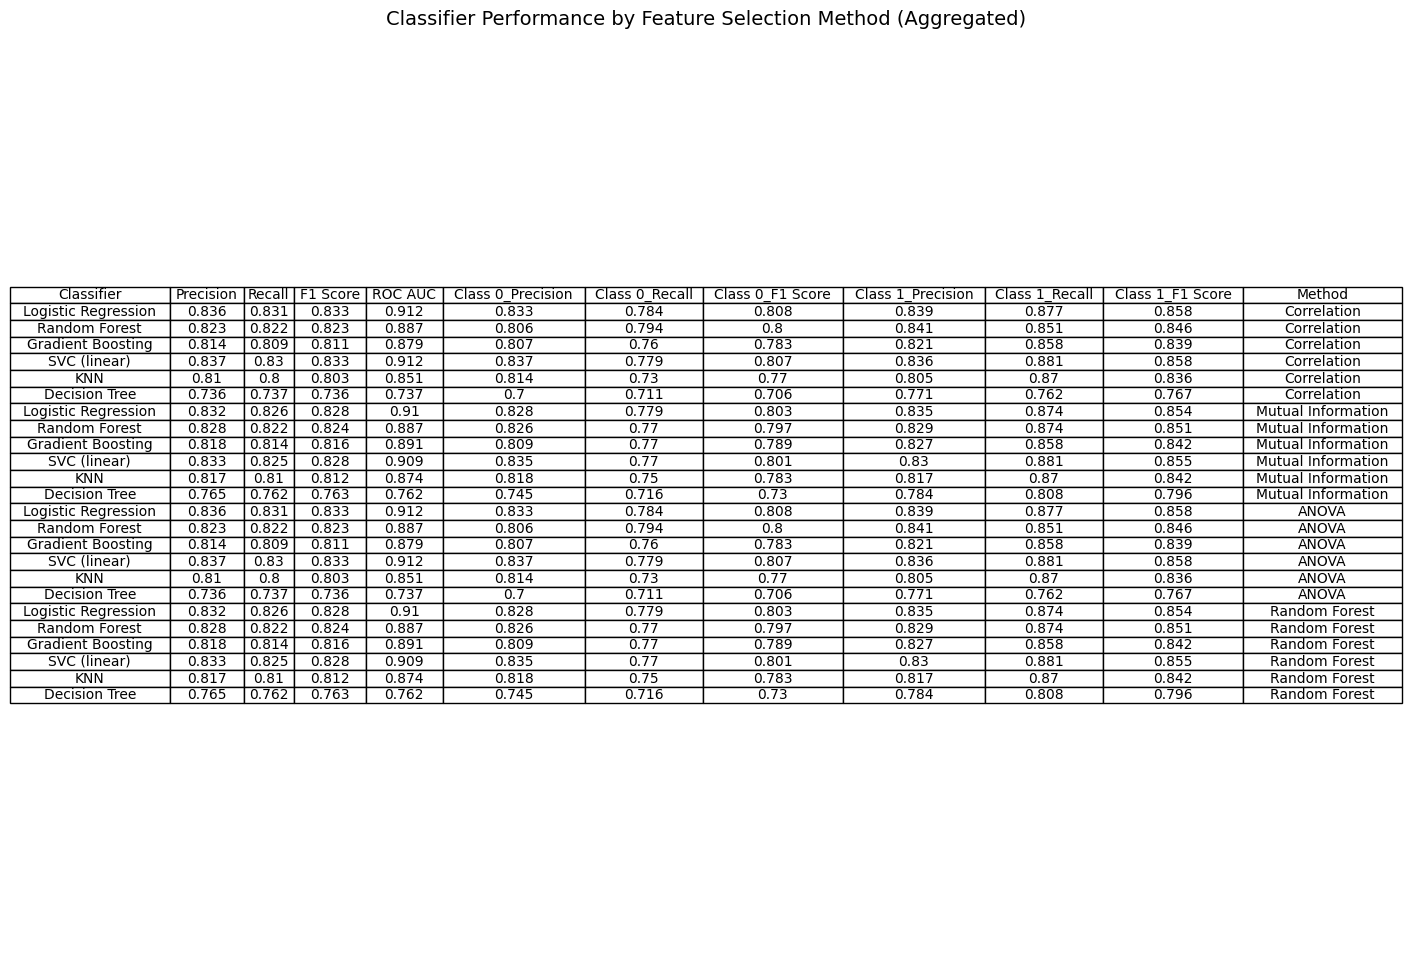

CO (mg/m3)


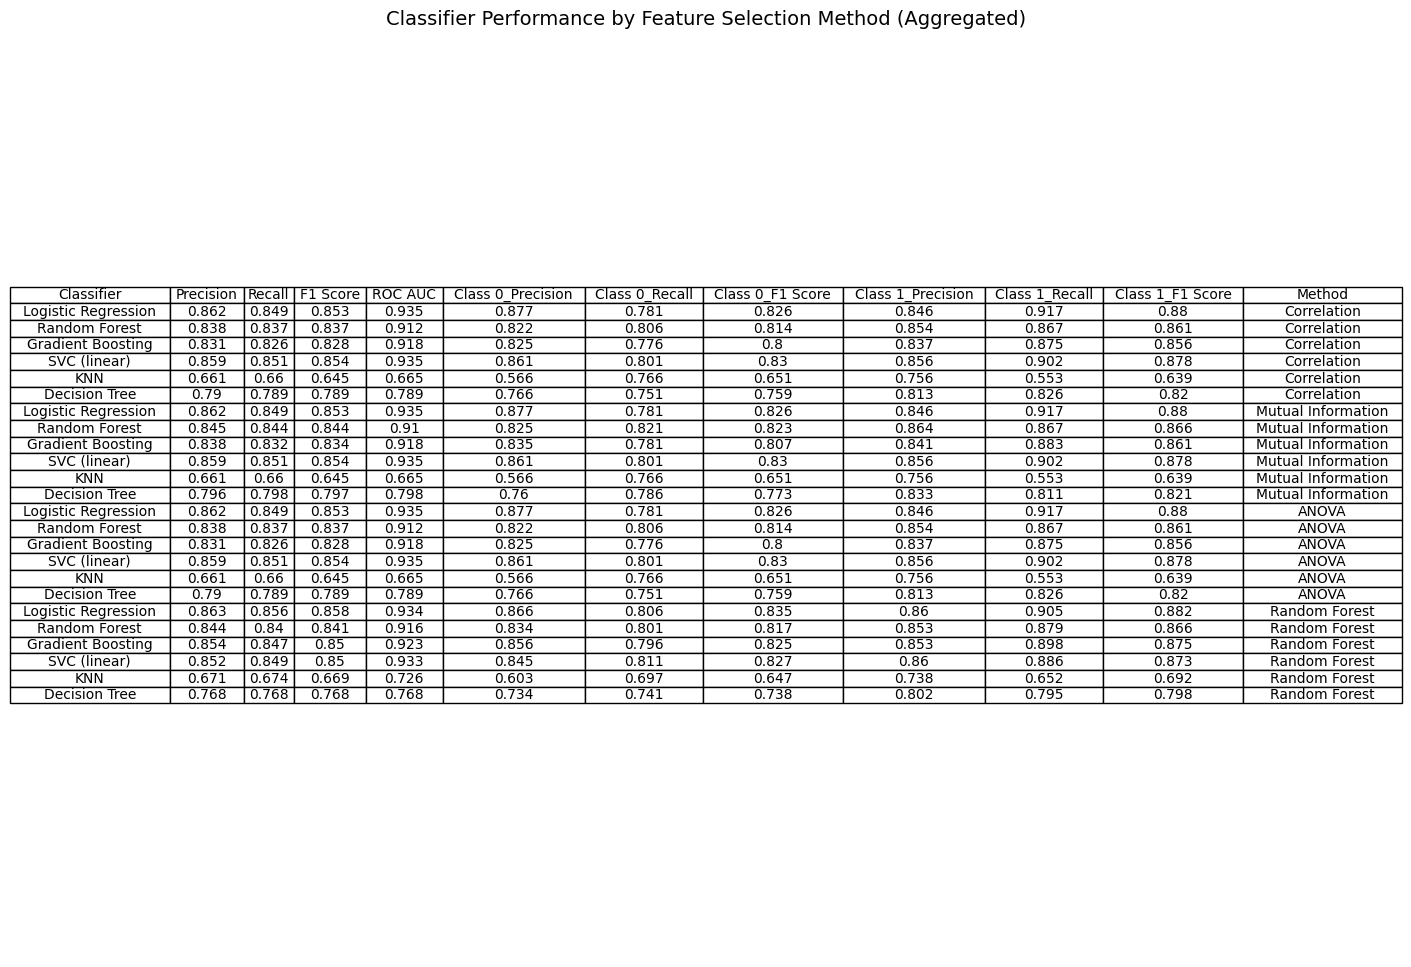

SO2 (ug/m3)


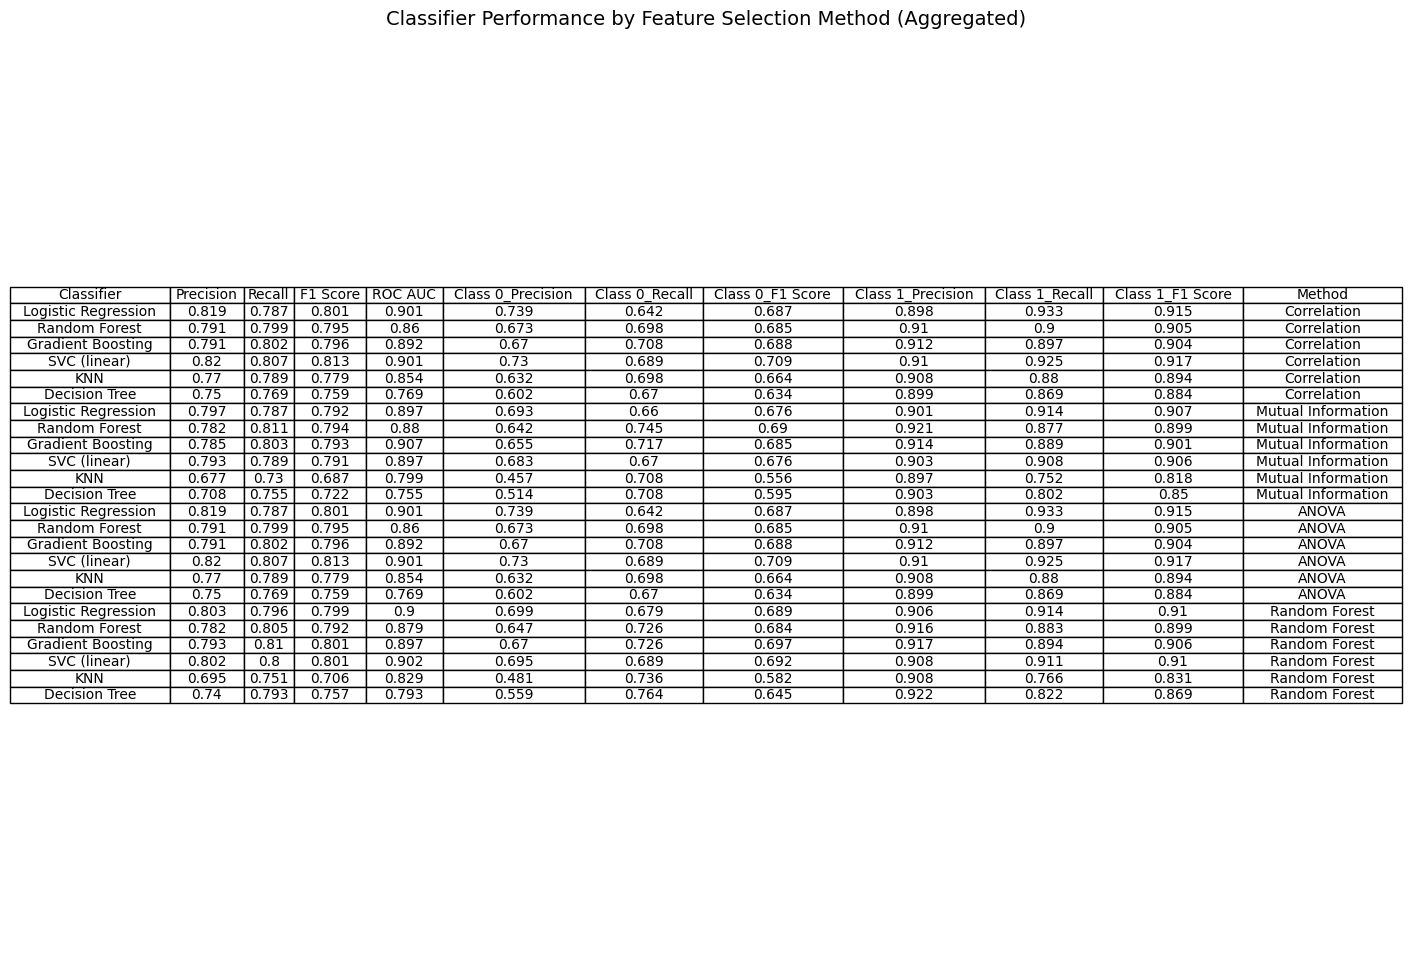

PM10 (ug/m3)


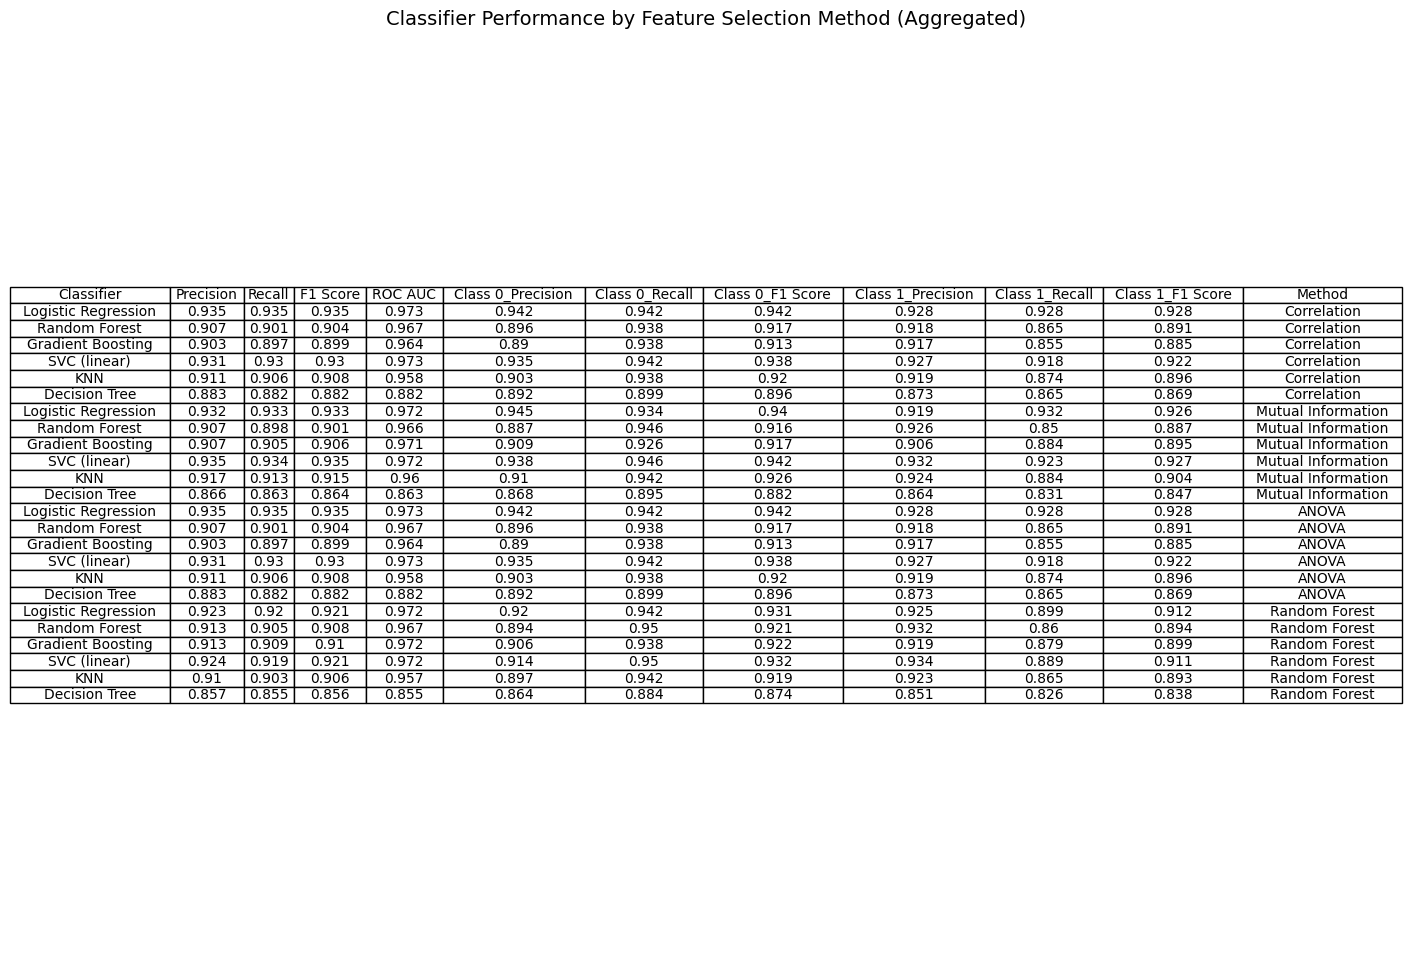

PM2.5 (ug/m3)


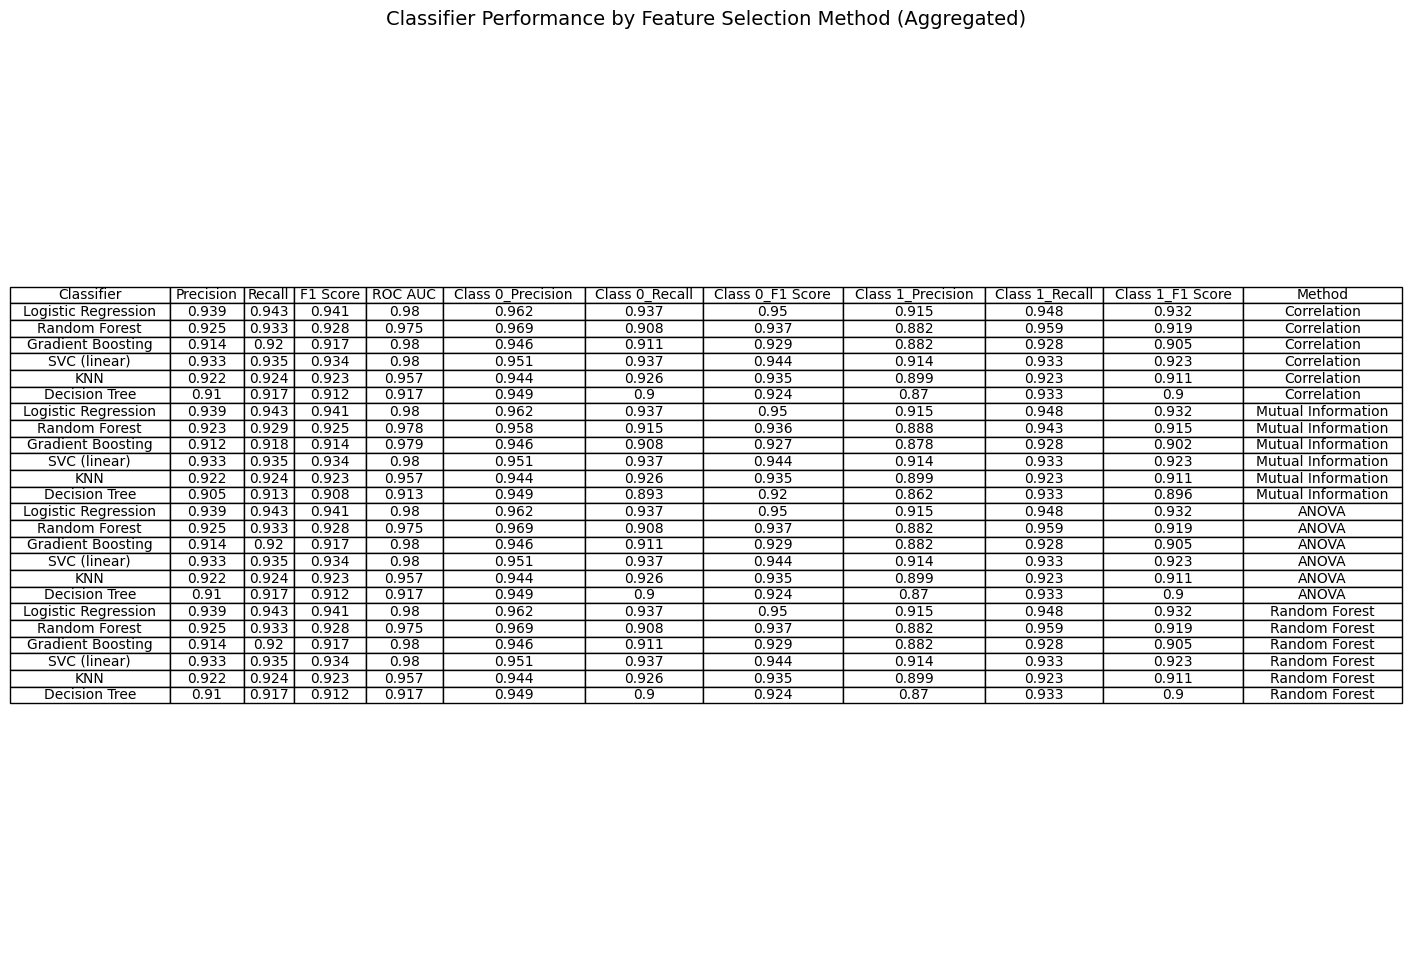

NO (ug/m3)


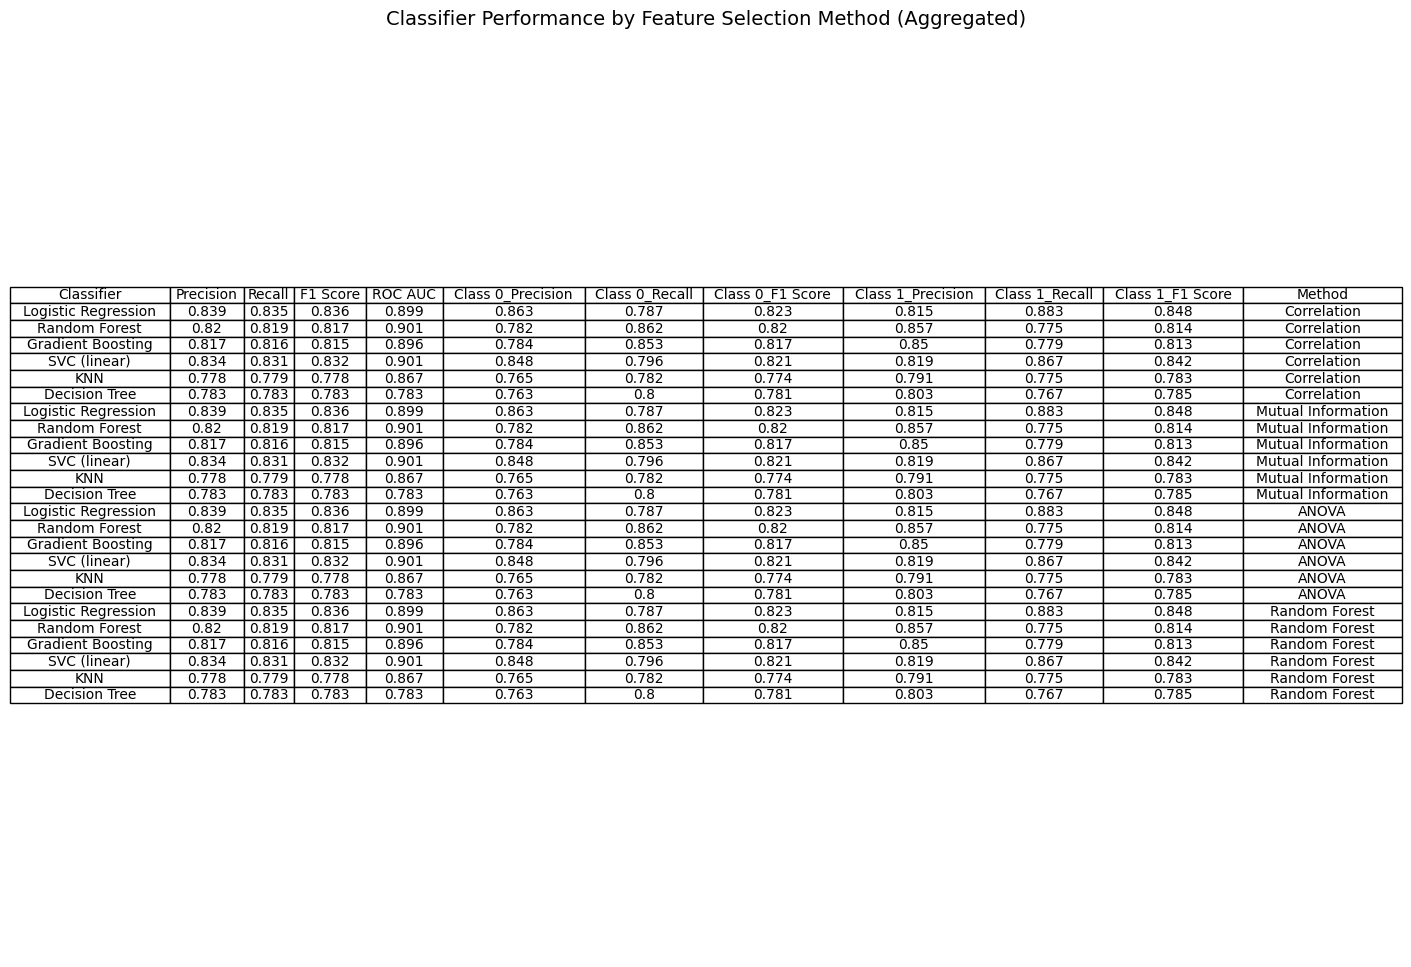

NO2 (ug/m3)


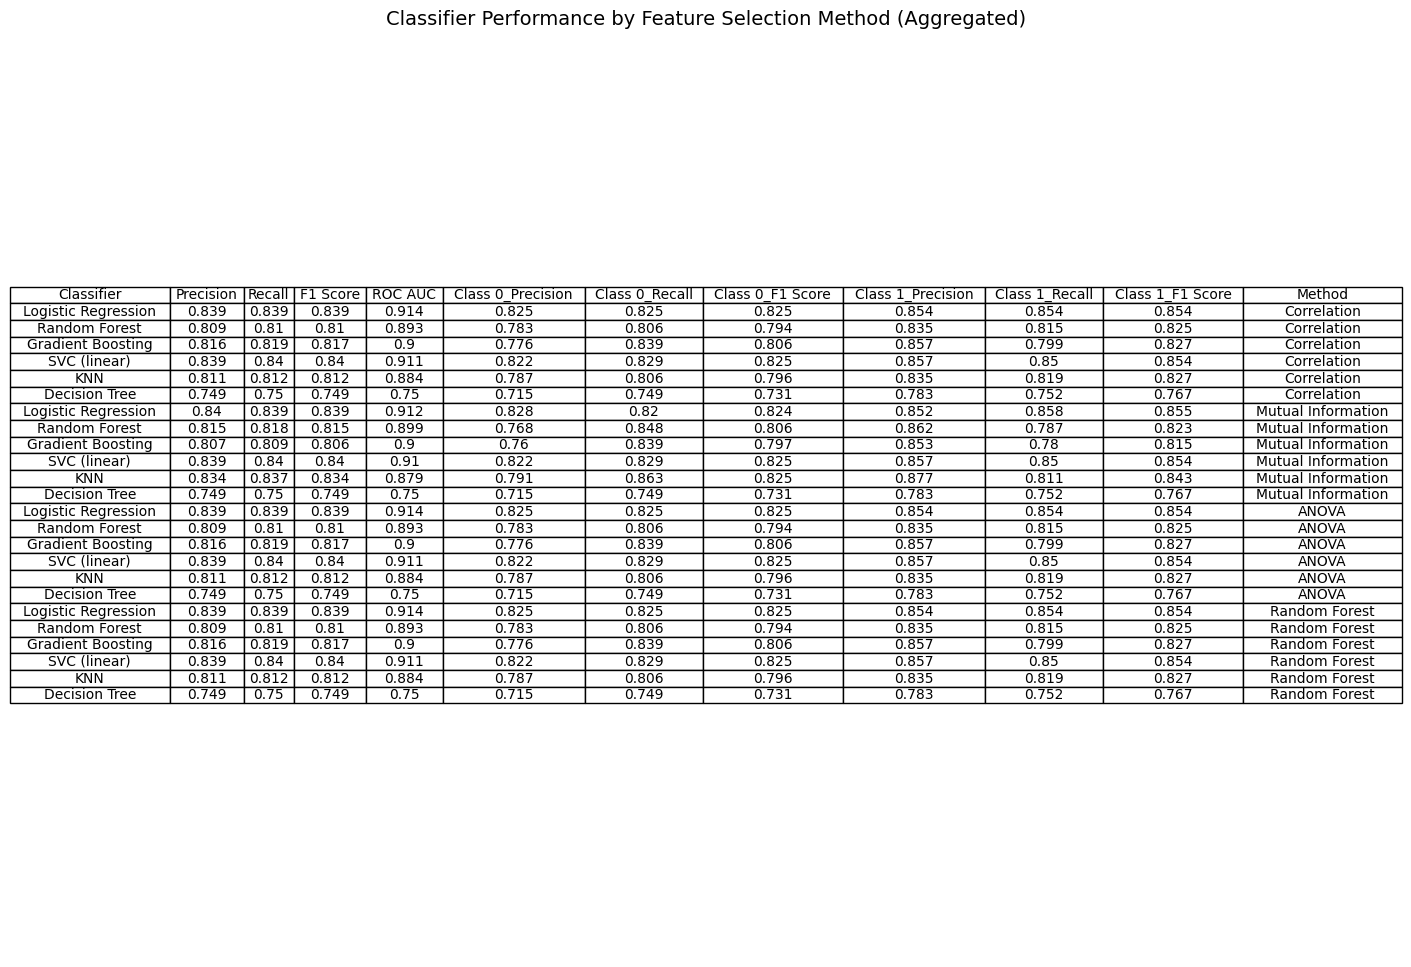

In [ ]:
for key, value in selector_binary.items():
  eval_results_binary = value.eval_feature_sets()
  print(f'{key}')
  plot_scores_table(eval_results_binary)

Creazione df multi label

In [ ]:
#Creazione df multi
polls = ['Ozone (ug/m3)', 'CO (mg/m3)', 'SO2 (ug/m3)', 'PM10 (ug/m3)', 'PM2.5 (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)']
df_multi_label = {}
for poll in polls:
  df_multi_label[poll] = create_pollution_labels(df_delhi_aggregato, poll, thresholds, 1)

Features that appear in multiple methods:
Ozone (ug/m3)    4
RH (%)           4
SR (W/mt2)       2
PM2.5 (ug/m3)    2
Name: count, dtype: int64


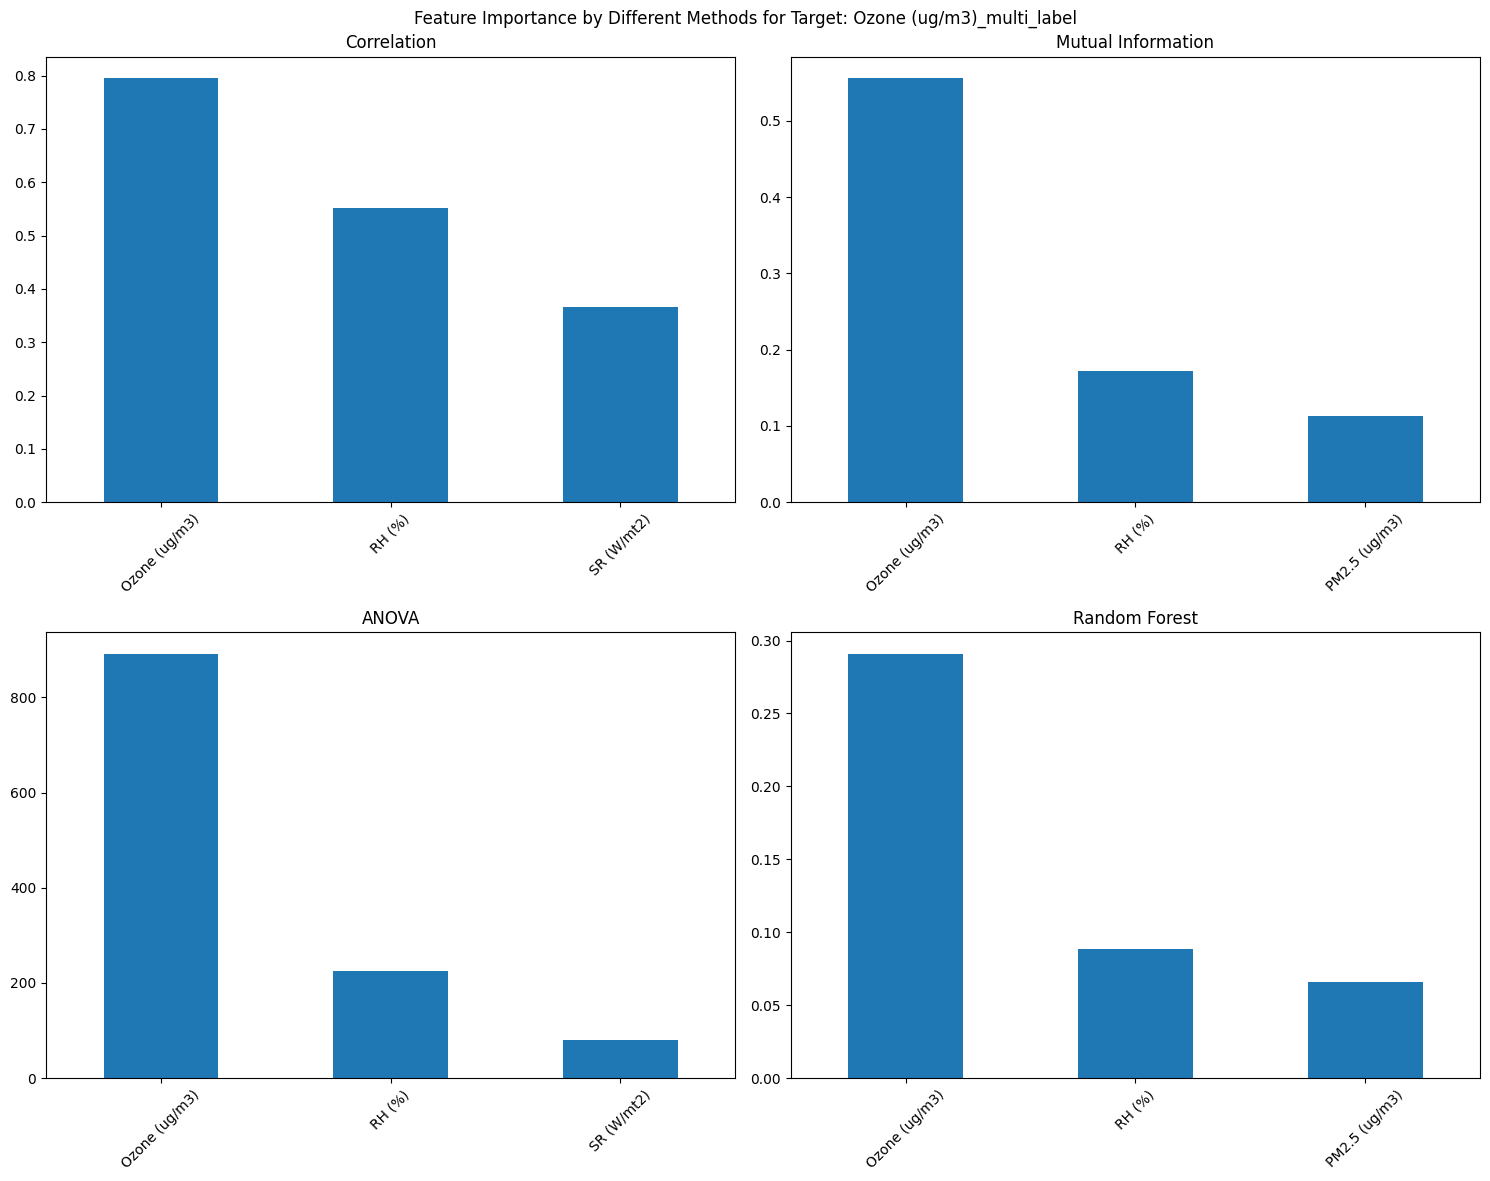

Features that appear in multiple methods:
CO (mg/m3)       4
PM2.5 (ug/m3)    4
NO2 (ug/m3)      2
Name: count, dtype: int64


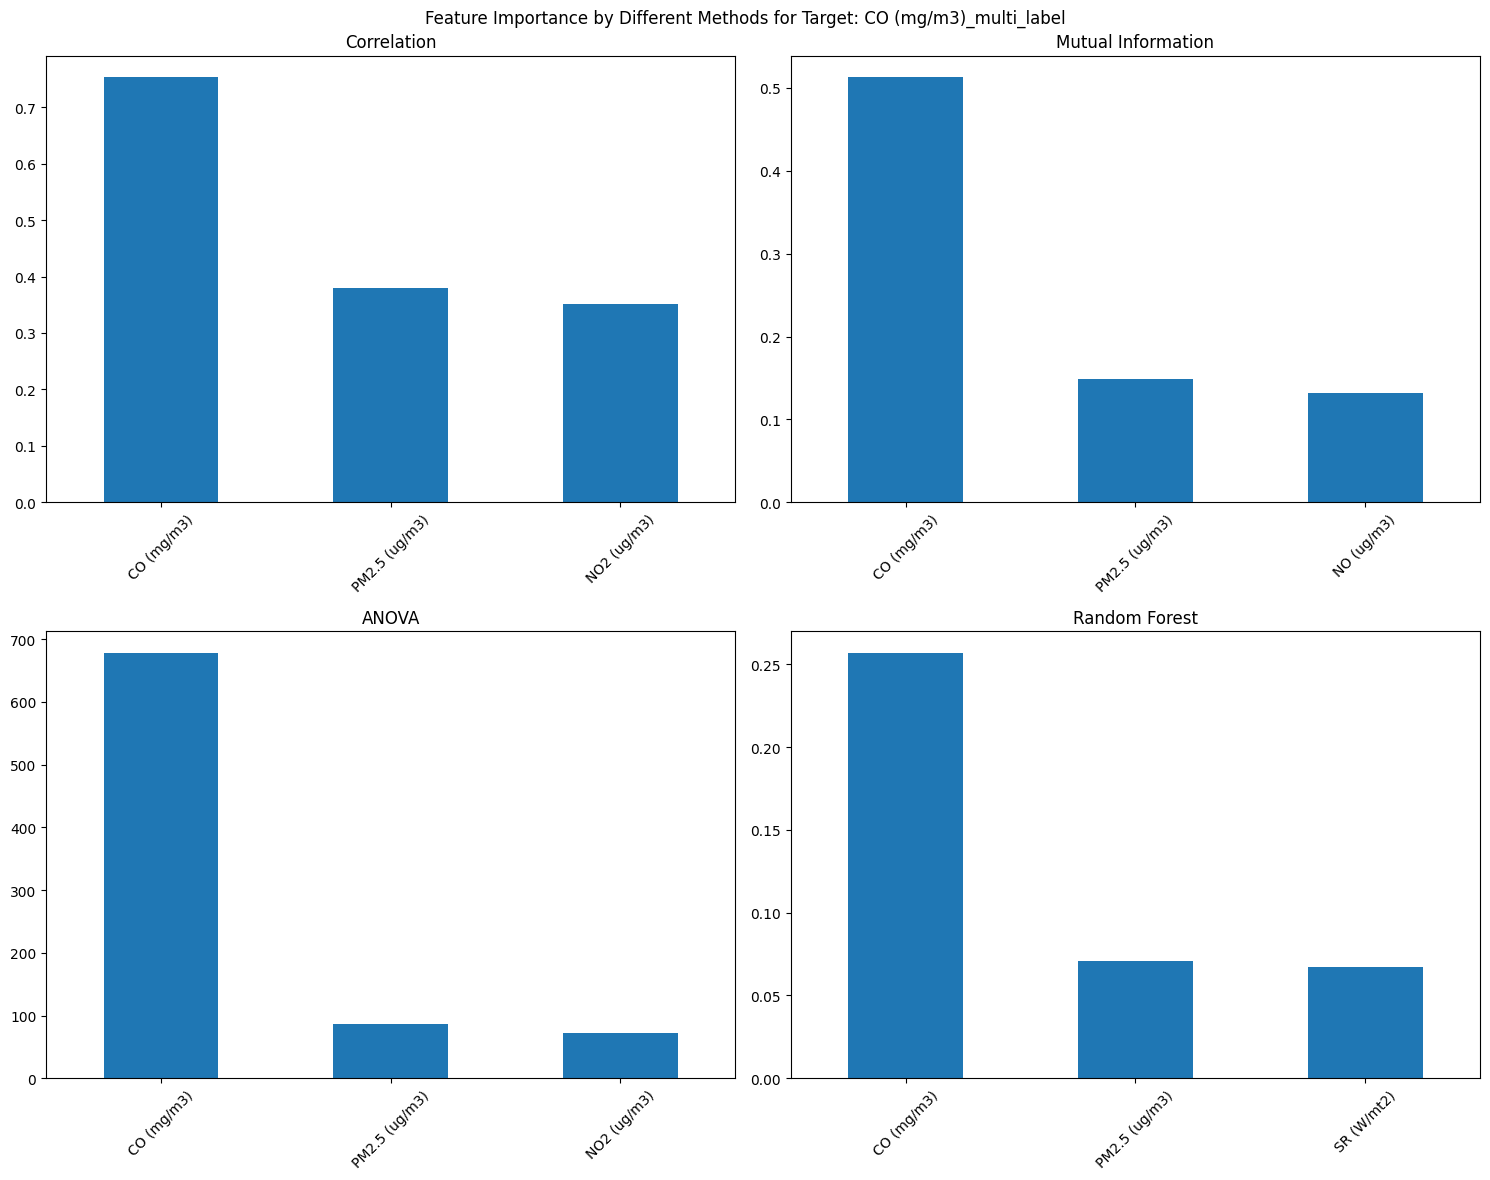

Features that appear in multiple methods:
SO2 (ug/m3)     4
RH (%)          3
PM10 (ug/m3)    3
Name: count, dtype: int64


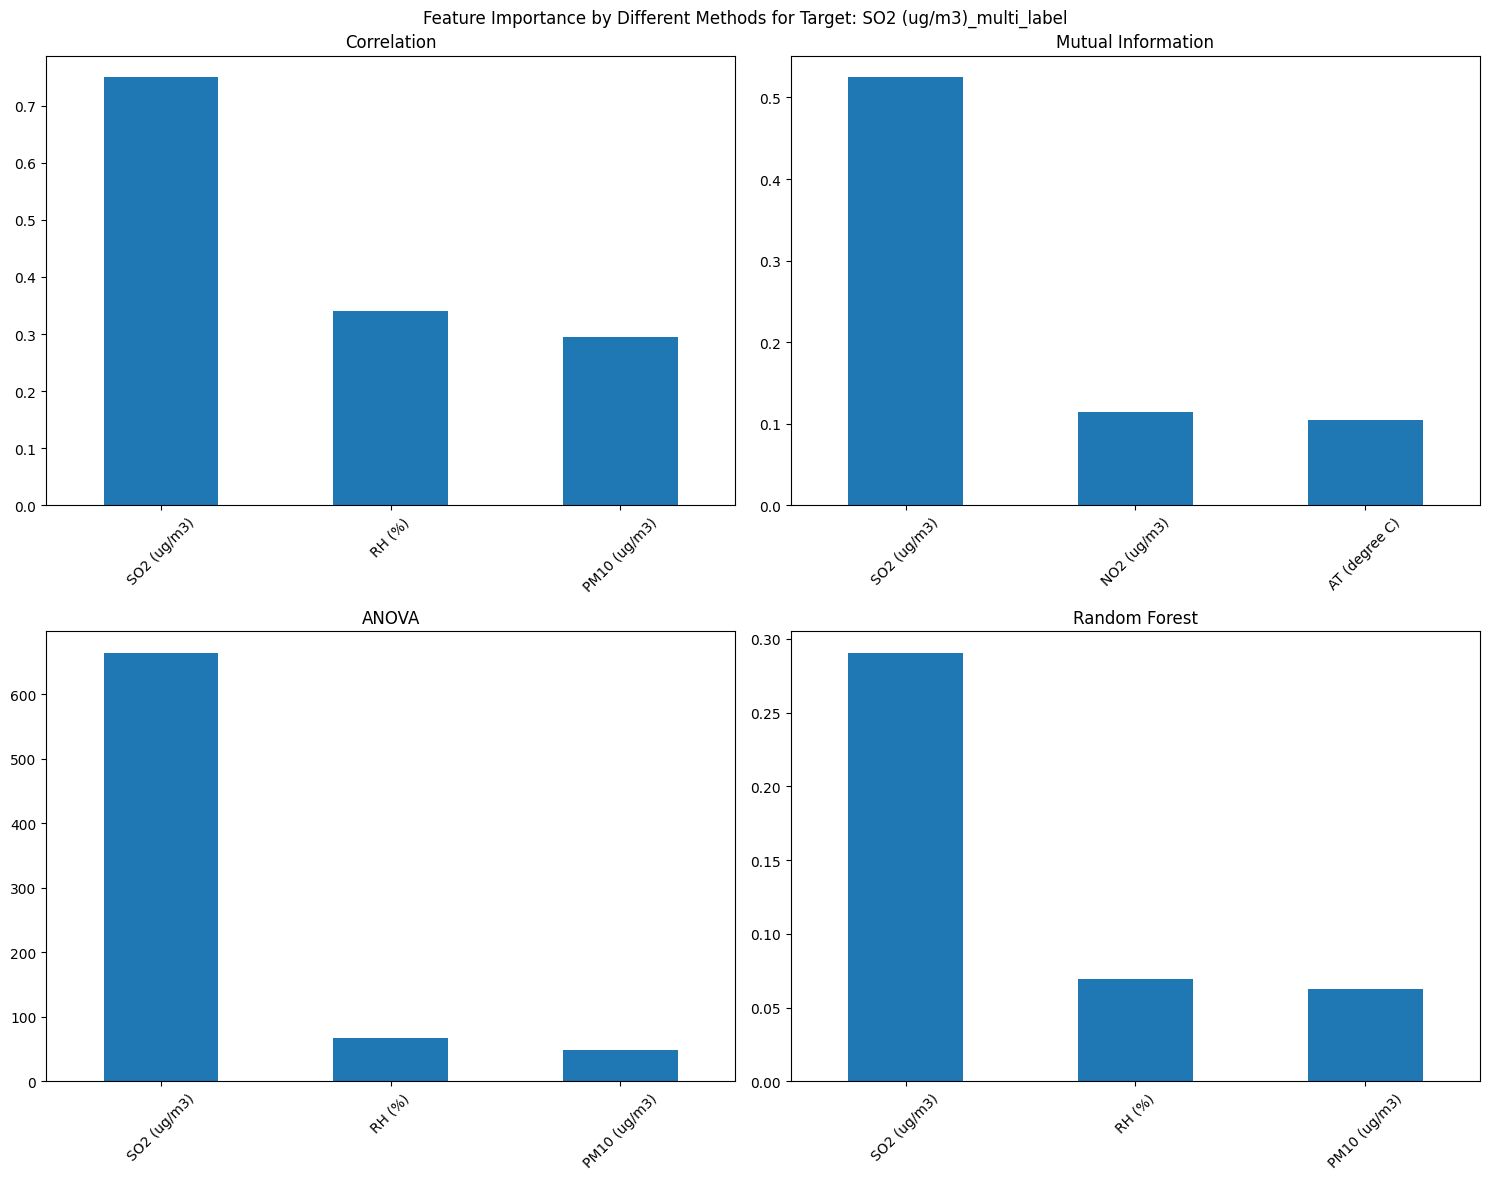

Features that appear in multiple methods:
PM10 (ug/m3)     4
PM2.5 (ug/m3)    4
NO2 (ug/m3)      4
Name: count, dtype: int64


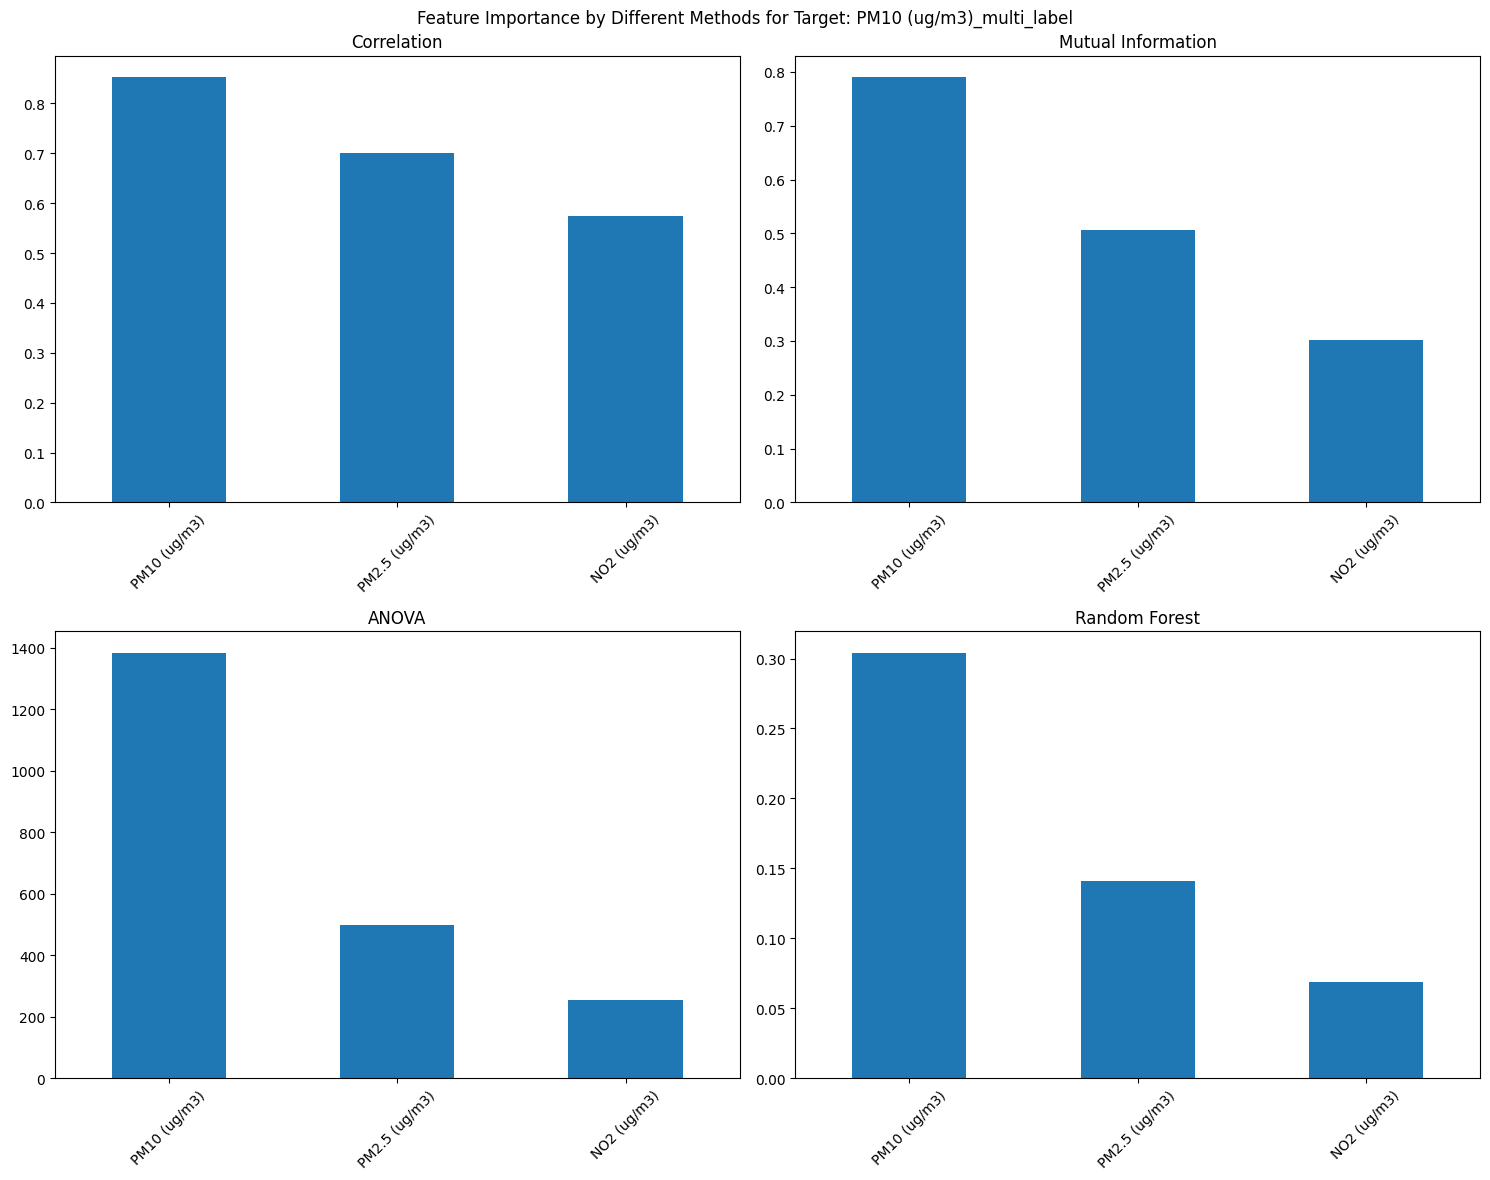

Features that appear in multiple methods:
PM2.5 (ug/m3)    4
PM10 (ug/m3)     4
AT (degree C)    4
Name: count, dtype: int64


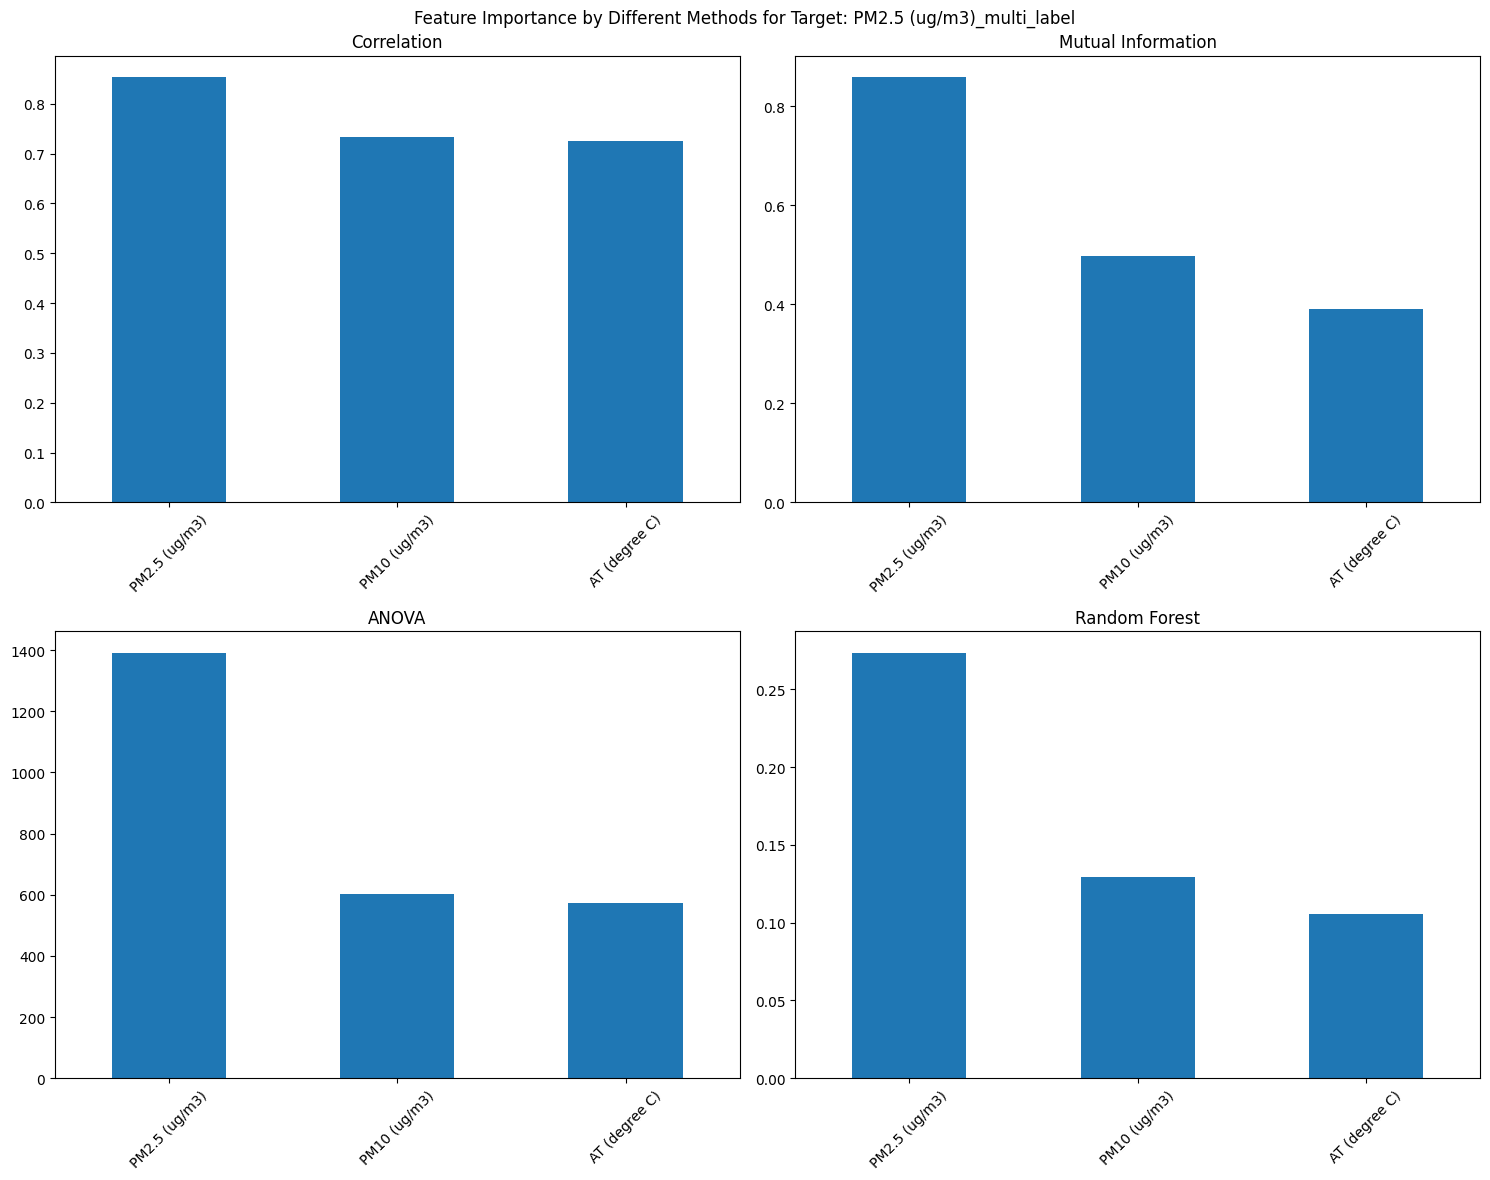

Features that appear in multiple methods:
NO (ug/m3)      4
NO2 (ug/m3)     4
PM10 (ug/m3)    4
Name: count, dtype: int64


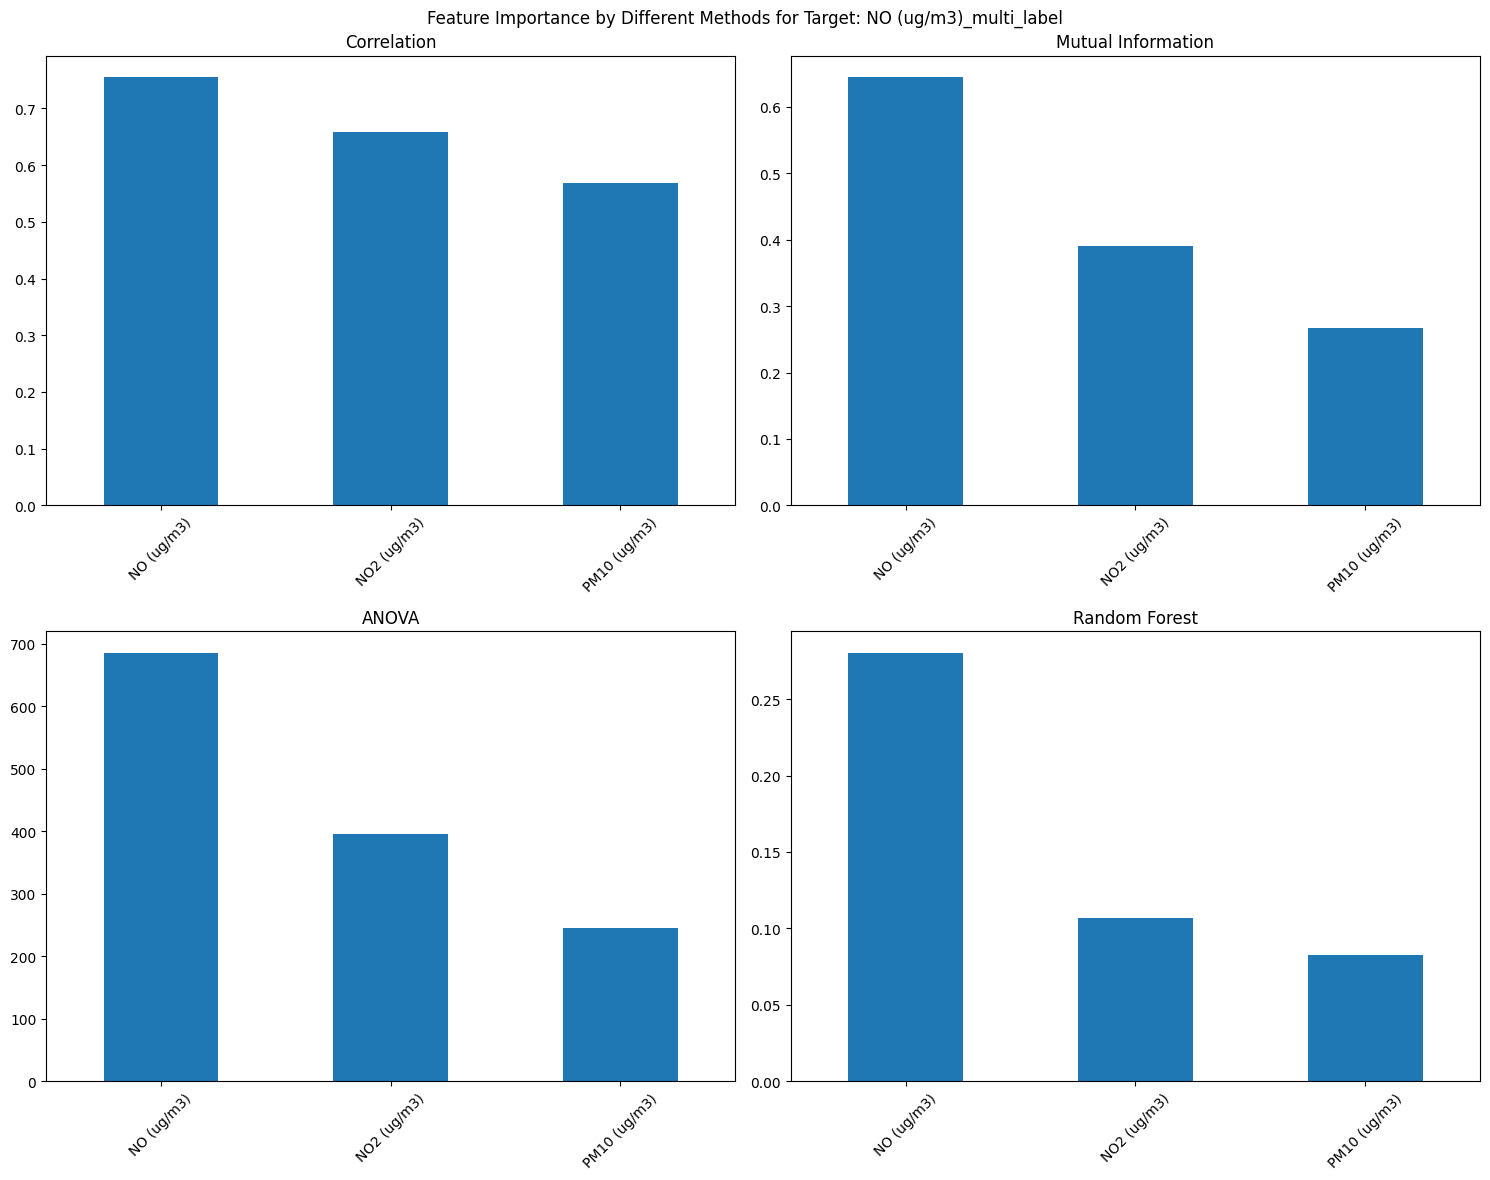

Features that appear in multiple methods:
NO2 (ug/m3)     4
NO (ug/m3)      4
PM10 (ug/m3)    3
Name: count, dtype: int64


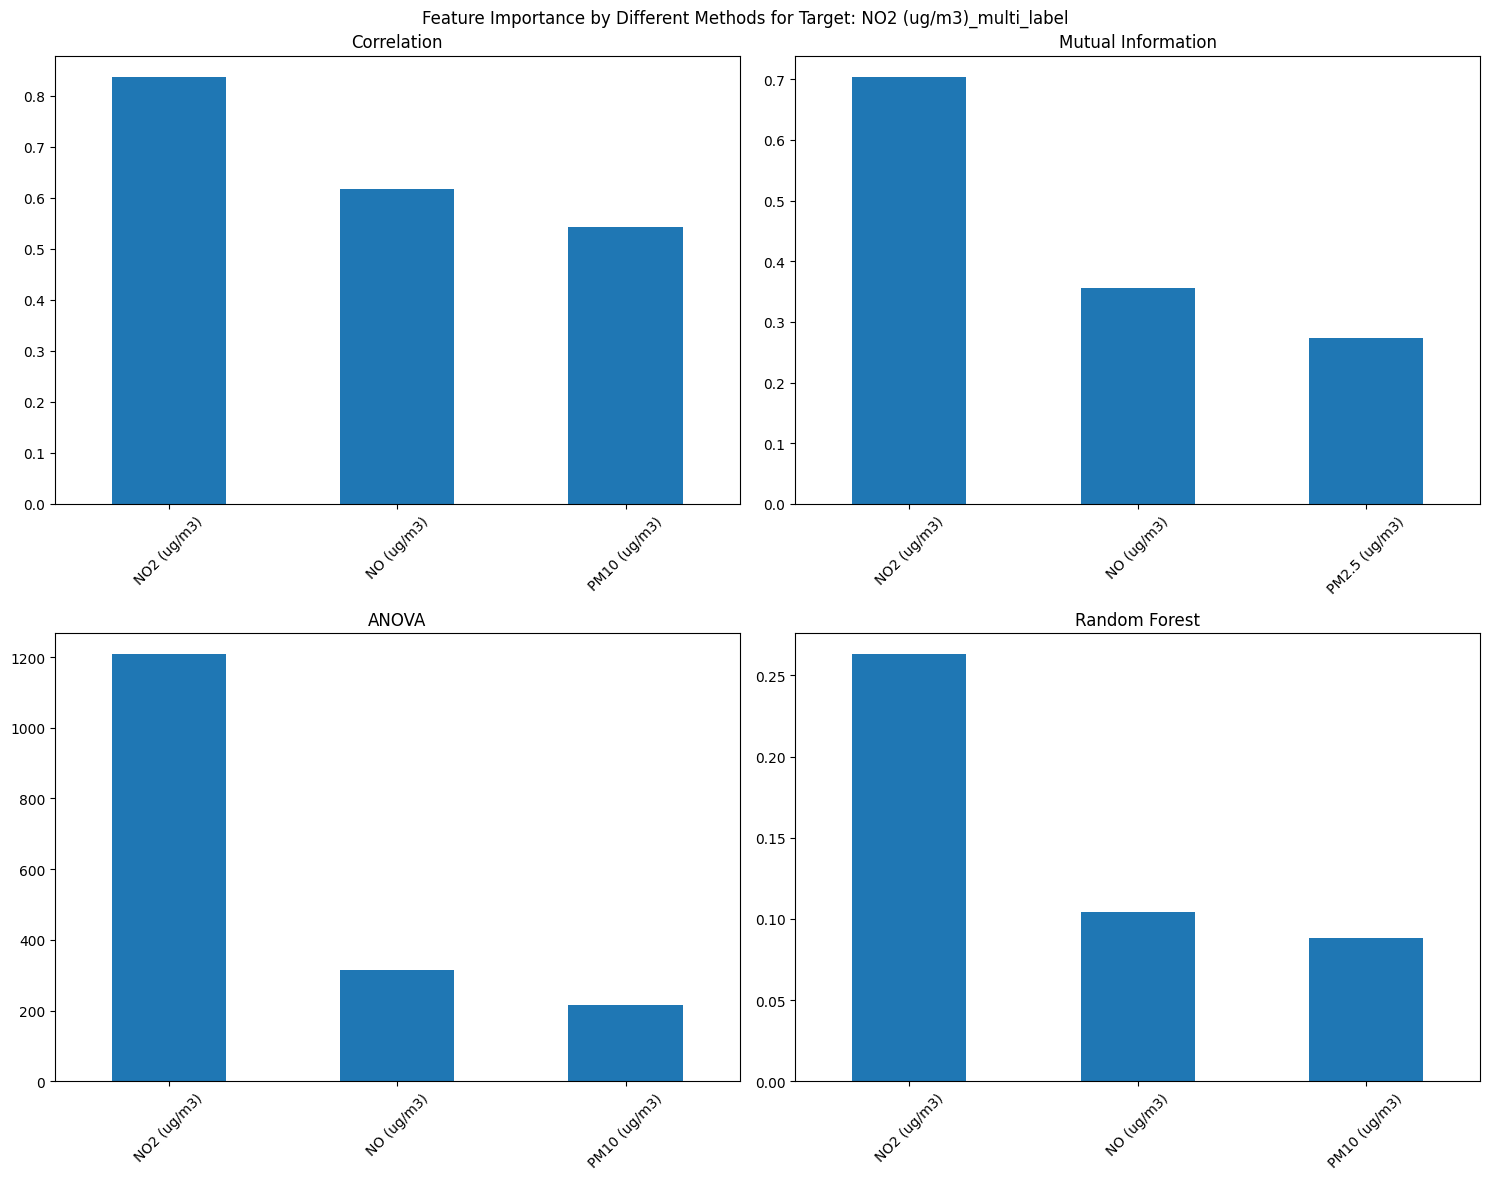

In [ ]:
selector_multi = {}
for key, value in df_multi_label.items():
  selector_multi[f'{key}'] = FeatureSelector(value, f'{key}_multi_label')

  # Ottieni i risultati
  scores_multi, feature_counts_multi = selector_multi[f'{key}'].compare_methods()

In [ ]:
# Itera su `selector_multi`, dove ogni chiave rappresenta un modello/selector
for key, value in selector_multi.items():
    print(f'Valutazione per {key}')
    eval_results_multi = value.eval_feature_sets(type=1)
    plot_scores_table(eval_results_multi)
    plot_multi_class_results(eval_results_multi)



Output hidden; open in https://colab.research.google.com to view.

In [ ]:
for key, value in selector_multi.items():
    print(f'Valutazione sbilanciamento classi per dataframe con classi inquinamento su {key}')
    # Verifica distribuzione classi
    print("Distribuzione delle classi:")
    print(value.df[f'{key}_multi_label'].value_counts(normalize=True))

Valutazione sbilanciamento classi per dataframe con classi inquinamento su Ozone (ug/m3)
Distribuzione delle classi:
Ozone (ug/m3)_multi_label
Nullo    0.283871
Basso    0.243871
Medio    0.238065
Alto     0.234194
Name: proportion, dtype: float64
Valutazione sbilanciamento classi per dataframe con classi inquinamento su CO (mg/m3)
Distribuzione delle classi:
CO (mg/m3)_multi_label
Basso    0.283226
Alto     0.266452
Nullo    0.260000
Medio    0.190323
Name: proportion, dtype: float64
Valutazione sbilanciamento classi per dataframe con classi inquinamento su SO2 (ug/m3)
Distribuzione delle classi:
SO2 (ug/m3)_multi_label
Nullo    0.290968
Basso    0.287097
Medio    0.240000
Alto     0.181935
Name: proportion, dtype: float64
Valutazione sbilanciamento classi per dataframe con classi inquinamento su PM10 (ug/m3)
Distribuzione delle classi:
PM10 (ug/m3)_multi_label
Medio    0.252903
Nullo    0.252903
Basso    0.251613
Alto     0.242581
Name: proportion, dtype: float64
Valutazione sbilanci

## Miglioramento delle performance - multi label
In questa sezione si faranno delle prove per cercare di migliorare i risultati ottenuti nella classificazione multipla

Viene definita una funzione che applica diversi metodi di bilanciamento delle classi a seconda delle situazioni incontrate

In [ ]:

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
import numpy as np


def balance_classes(df, target_column, strategy='auto'):
    """
    Bilancia le classi di un dataframe utilizzando tecniche di oversampling come SMOTE o RandomOverSampler.
    Se il numero di esempi in alcune classi è troppo basso, usa un approccio alternativo.

    Parametri:
    - df: pd.DataFrame, il dataframe contenente i dati
    - target_column: str, il nome della colonna target
    - strategy: str, definisce la tecnica di bilanciamento (può essere 'auto', 'smote', o 'random')

    Restituisce:
    - df_balanced: pd.DataFrame, il dataframe con le classi bilanciate
    - method: str, la tecnica di bilanciamento usata
    """

    # Estrae le caratteristiche e il target
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Controlla la distribuzione delle classi
    class_counts = y.value_counts()
    print(f"Distribuzione originale delle classi: {class_counts.to_dict()}")

    # Verifica il numero di campioni per ciascuna classe
    if strategy == 'auto':

        if any(class_counts < 50):
            method = 'RandomOverSampler'
            sampler = RandomOverSampler()
        else:
            # Usa SMOTE per bilanciare
            method = 'SMOTE'
            sampler = SMOTE()
    elif strategy == 'smote':
        method = 'SMOTE'
        sampler = SMOTE()
    elif strategy == 'random':
        method = 'RandomOverSampler'
        sampler = RandomOverSampler()

    # Bilancia il dataset
    X_res, y_res = sampler.fit_resample(X, y)

    # Ritorna il dataframe bilanciato
    df_balanced = X_res.copy()
    df_balanced[target_column] = y_res
    print(f"Distribuzione nuova delle classi: {df_balanced[target_column].value_counts().to_dict()}")
    return df_balanced, method


### Prima prova - dataset bilanciato

Si procede a creare un dataset bilanciato con il metodo sopra

In [ ]:

#Bilanciamento

# Crea un dizionario vuoto per contenere i dataframe bilanciati
df_balanced_multi_label = {}

for key, value in selector_multi.items():
    print(f'Valutazione sbilanciamento classi per dataframe con classi inquinamento su {key}')

    # Bilancia il dataframe
    df_balanced, method = balance_classes(value.df, f'{key}_multi_label', strategy='auto')  # 'auto' fa scegliere automaticamente il metodo di bilanciamento

    # Salva il dataframe bilanciato nel dizionario con la chiave corrispondente
    df_balanced_multi_label[key] = df_balanced

    # Stampa il metodo di bilanciamento utilizzato
    print(f"Metodo di bilanciamento utilizzato: {method}")


Valutazione sbilanciamento classi per dataframe con classi inquinamento su Ozone (ug/m3)
Distribuzione originale delle classi: {'Nullo': 440, 'Basso': 378, 'Medio': 369, 'Alto': 363}
Distribuzione nuova delle classi: {'Medio': 440, 'Nullo': 440, 'Basso': 440, 'Alto': 440}
Metodo di bilanciamento utilizzato: SMOTE
Valutazione sbilanciamento classi per dataframe con classi inquinamento su CO (mg/m3)
Distribuzione originale delle classi: {'Basso': 439, 'Alto': 413, 'Nullo': 403, 'Medio': 295}
Distribuzione nuova delle classi: {'Alto': 439, 'Basso': 439, 'Nullo': 439, 'Medio': 439}
Metodo di bilanciamento utilizzato: SMOTE
Valutazione sbilanciamento classi per dataframe con classi inquinamento su SO2 (ug/m3)
Distribuzione originale delle classi: {'Nullo': 451, 'Basso': 445, 'Medio': 372, 'Alto': 282}
Distribuzione nuova delle classi: {'Alto': 451, 'Basso': 451, 'Medio': 451, 'Nullo': 451}
Metodo di bilanciamento utilizzato: SMOTE
Valutazione sbilanciamento classi per dataframe con classi i

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validatio

Distribuzione nuova delle classi: {'Alto': 439, 'Medio': 439, 'Basso': 439, 'Nullo': 439}
Metodo di bilanciamento utilizzato: SMOTE
Valutazione sbilanciamento classi per dataframe con classi inquinamento su NO2 (ug/m3)
Distribuzione originale delle classi: {'Nullo': 461, 'Medio': 407, 'Basso': 374, 'Alto': 308}
Distribuzione nuova delle classi: {'Alto': 461, 'Medio': 461, 'Basso': 461, 'Nullo': 461}
Metodo di bilanciamento utilizzato: SMOTE


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Si valuta il bilanciamento

In [ ]:
for key, value in df_balanced_multi_label.items():
    print(f'Valutazione sbilanciamento classi per dataframe con classi inquinamento su {key}')
    # Verifica distribuzione classi
    print("Distribuzione delle classi:")
    print(value[f'{key}_multi_label'].value_counts(normalize=True))

Valutazione sbilanciamento classi per dataframe con classi inquinamento su Ozone (ug/m3)
Distribuzione delle classi:
Ozone (ug/m3)_multi_label
Medio    0.25
Nullo    0.25
Basso    0.25
Alto     0.25
Name: proportion, dtype: float64
Valutazione sbilanciamento classi per dataframe con classi inquinamento su CO (mg/m3)
Distribuzione delle classi:
CO (mg/m3)_multi_label
Alto     0.25
Basso    0.25
Nullo    0.25
Medio    0.25
Name: proportion, dtype: float64
Valutazione sbilanciamento classi per dataframe con classi inquinamento su SO2 (ug/m3)
Distribuzione delle classi:
SO2 (ug/m3)_multi_label
Alto     0.25
Basso    0.25
Medio    0.25
Nullo    0.25
Name: proportion, dtype: float64
Valutazione sbilanciamento classi per dataframe con classi inquinamento su PM10 (ug/m3)
Distribuzione delle classi:
PM10 (ug/m3)_multi_label
Alto     0.25
Basso    0.25
Medio    0.25
Nullo    0.25
Name: proportion, dtype: float64
Valutazione sbilanciamento classi per dataframe con classi inquinamento su PM2.5 (ug

Si creano delle classi di Feature Selector sulla base del dataset bilanciato

Features that appear in multiple methods:
Ozone (ug/m3)    4
RH (%)           4
SR (W/mt2)       2
Name: count, dtype: int64


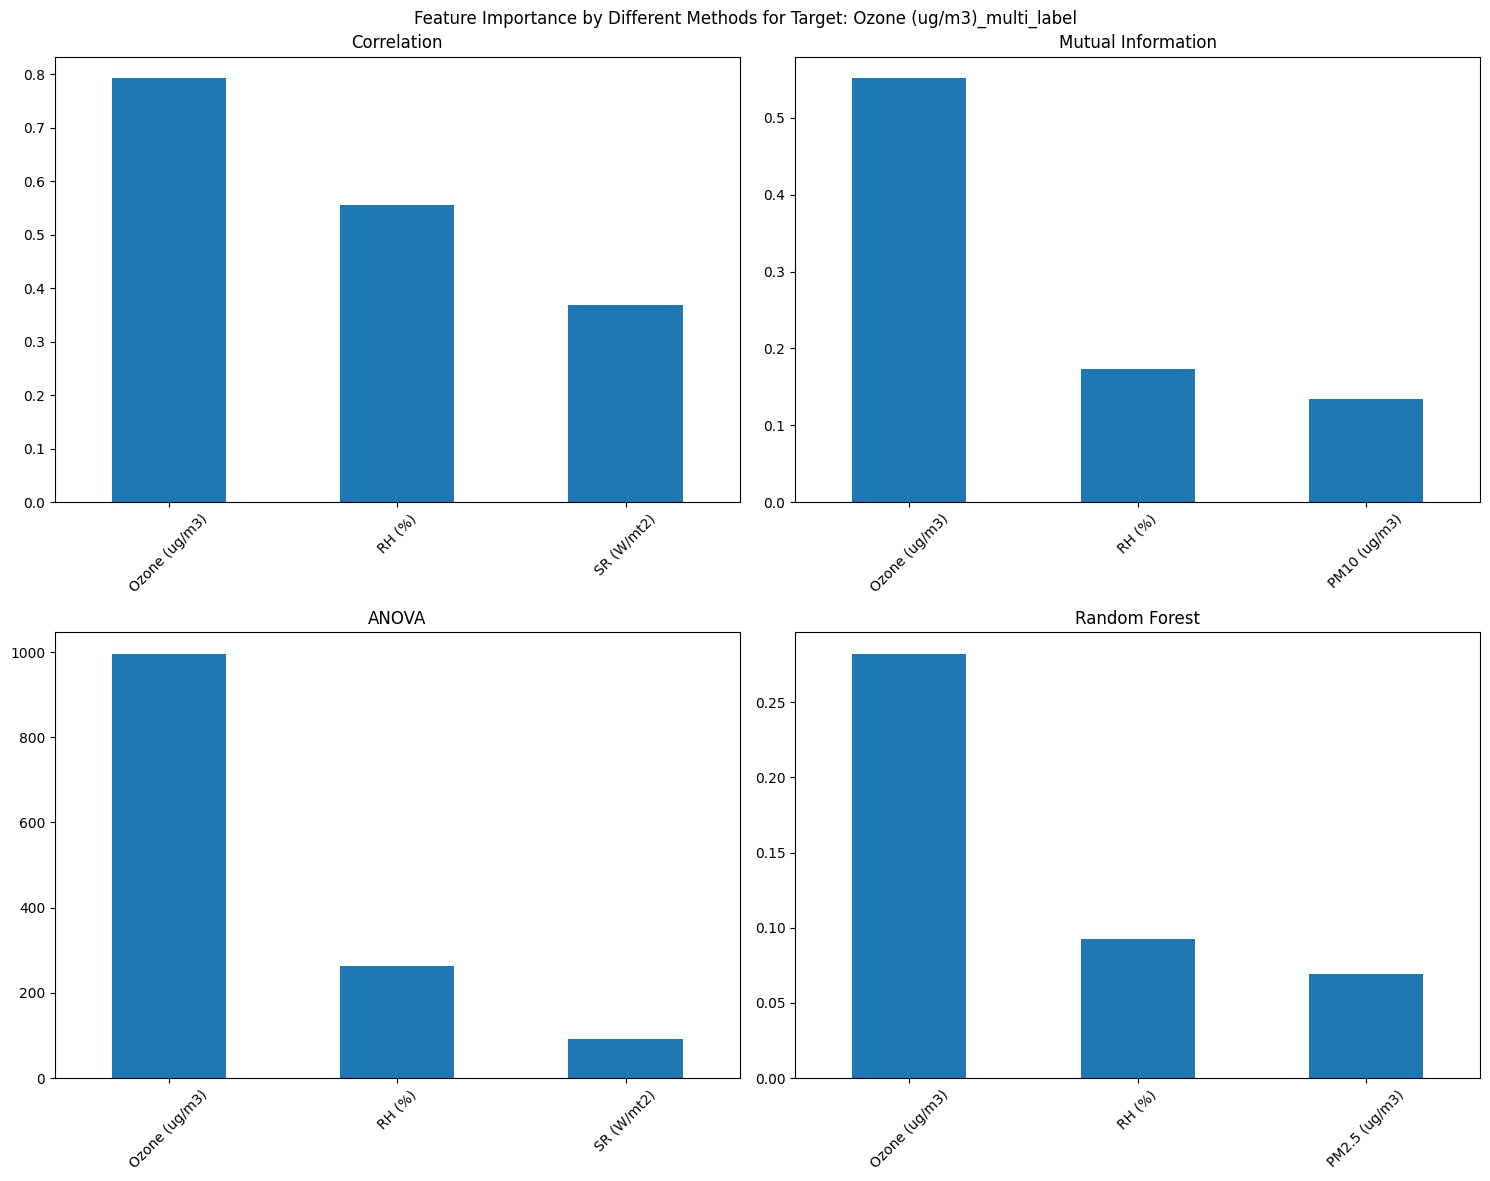

Features that appear in multiple methods:
CO (mg/m3)       4
PM2.5 (ug/m3)    4
SR (W/mt2)       2
Name: count, dtype: int64


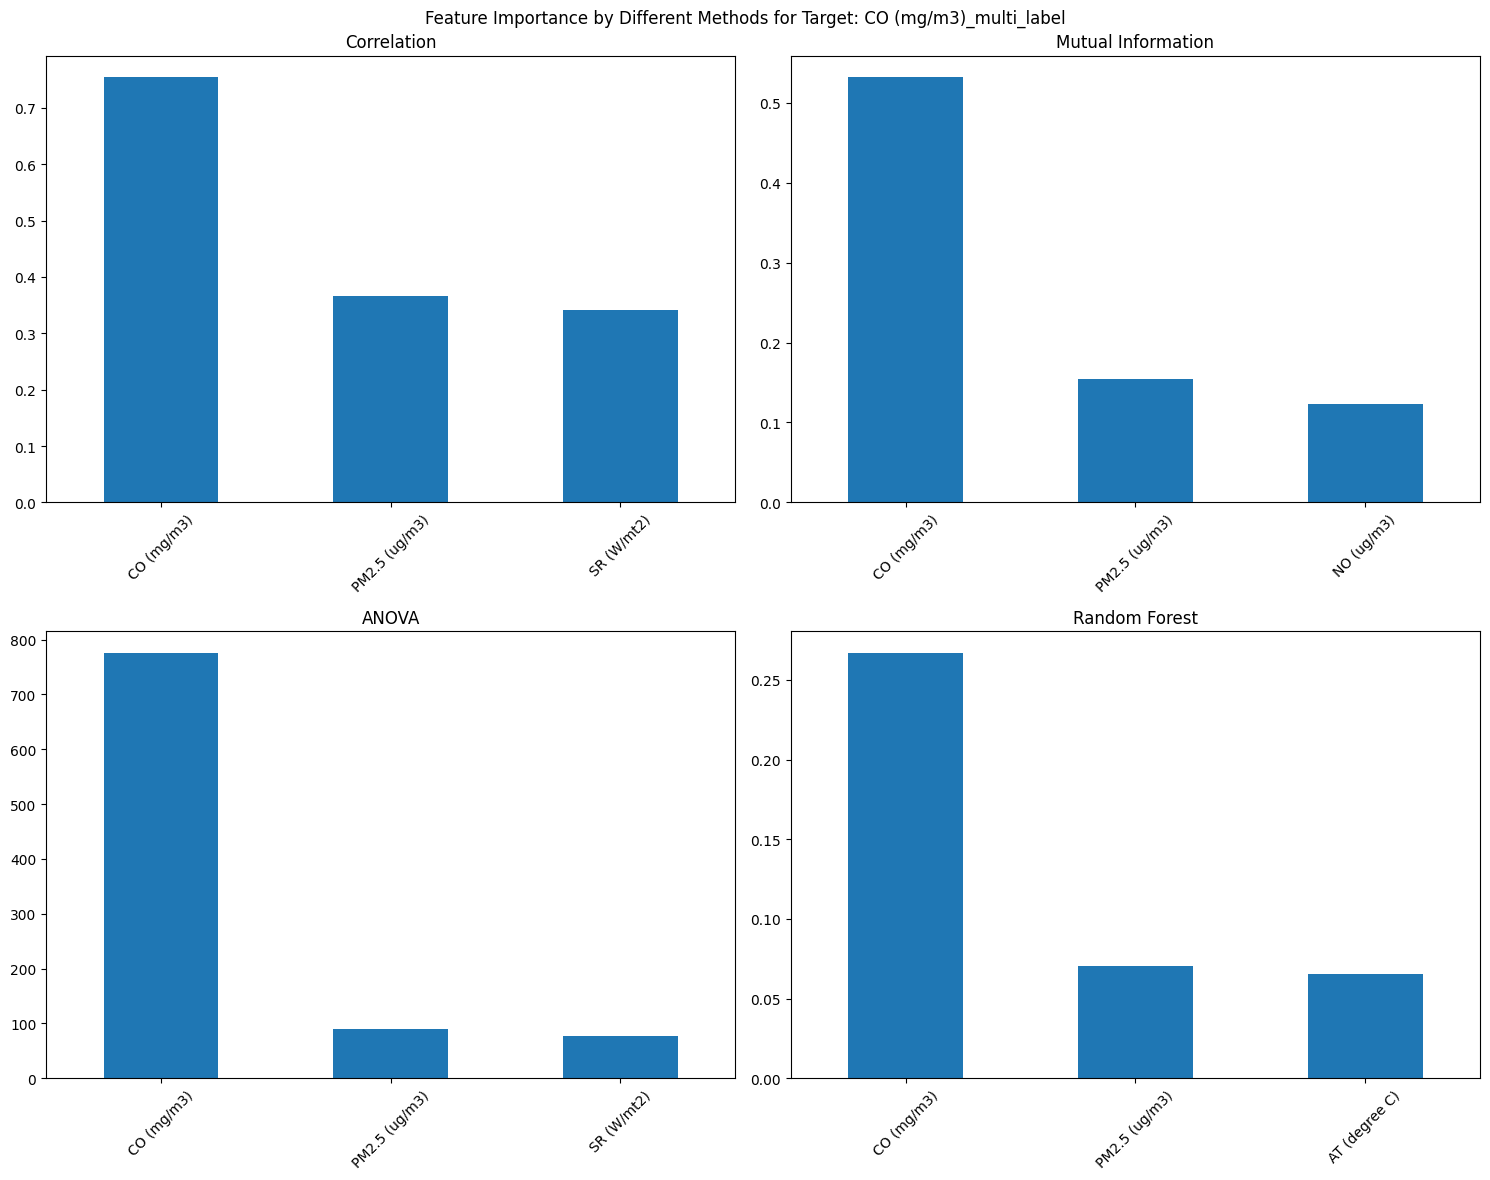

Features that appear in multiple methods:
SO2 (ug/m3)     4
RH (%)          3
PM10 (ug/m3)    3
Name: count, dtype: int64


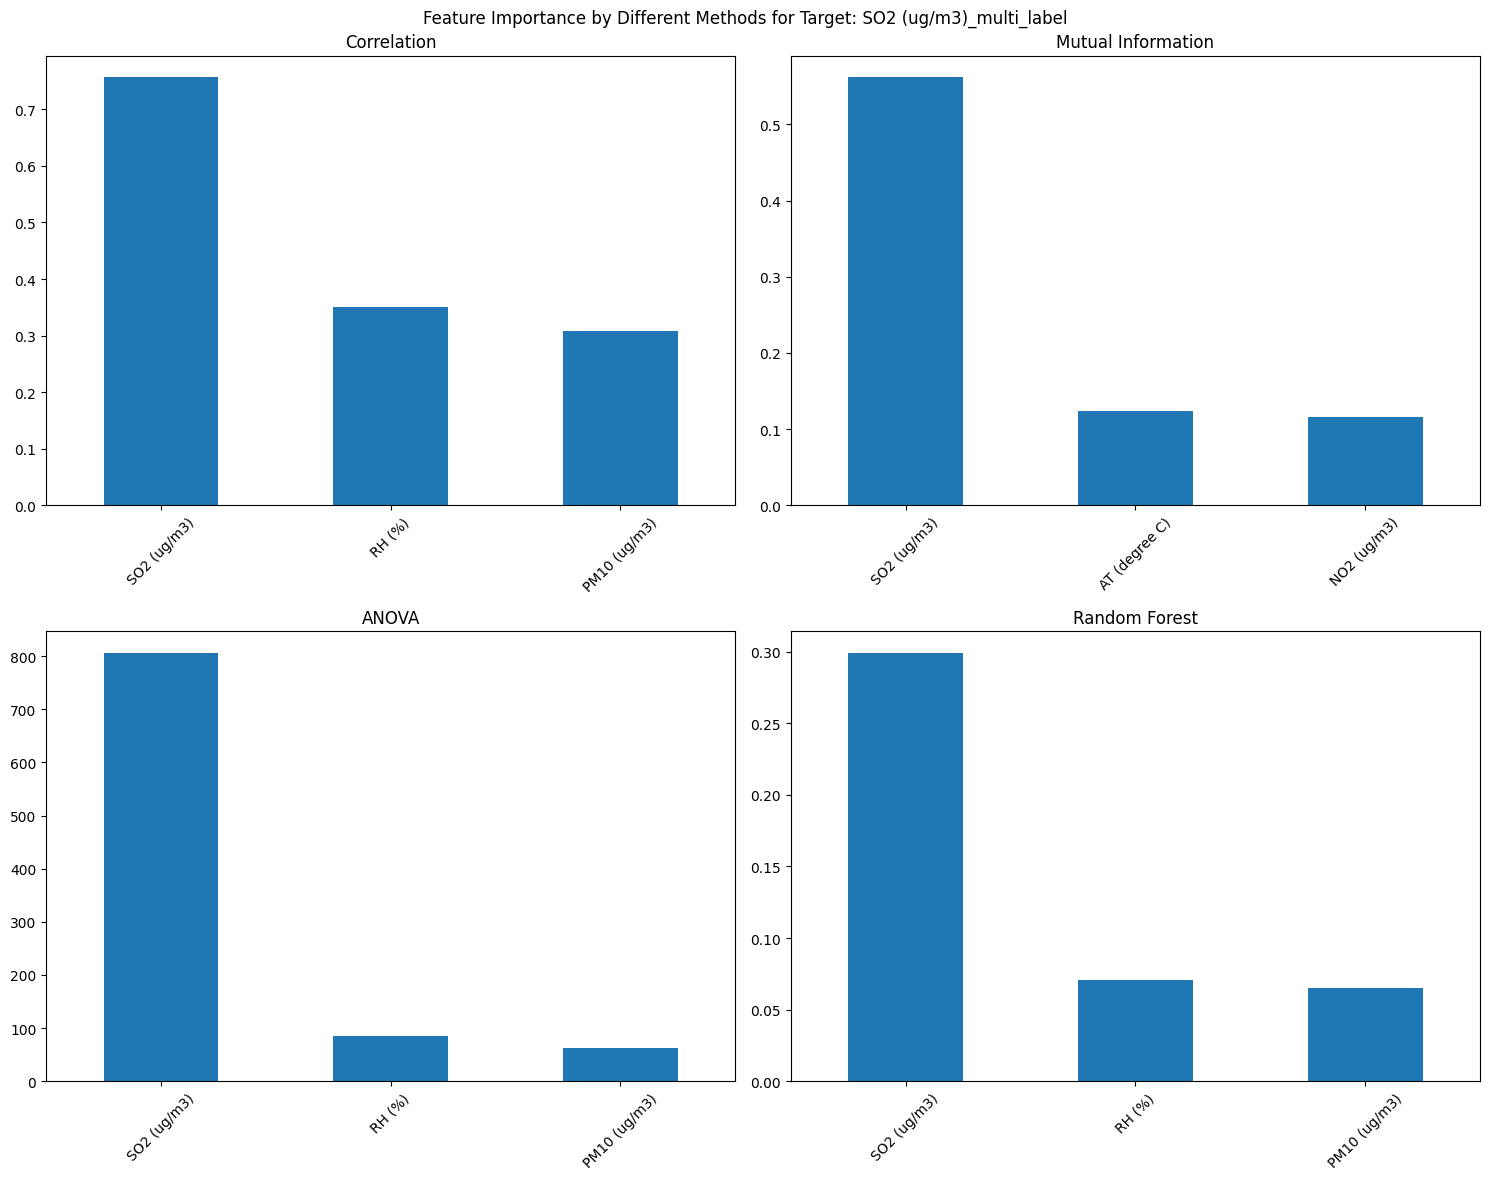

Features that appear in multiple methods:
PM10 (ug/m3)     4
PM2.5 (ug/m3)    4
NO2 (ug/m3)      4
Name: count, dtype: int64


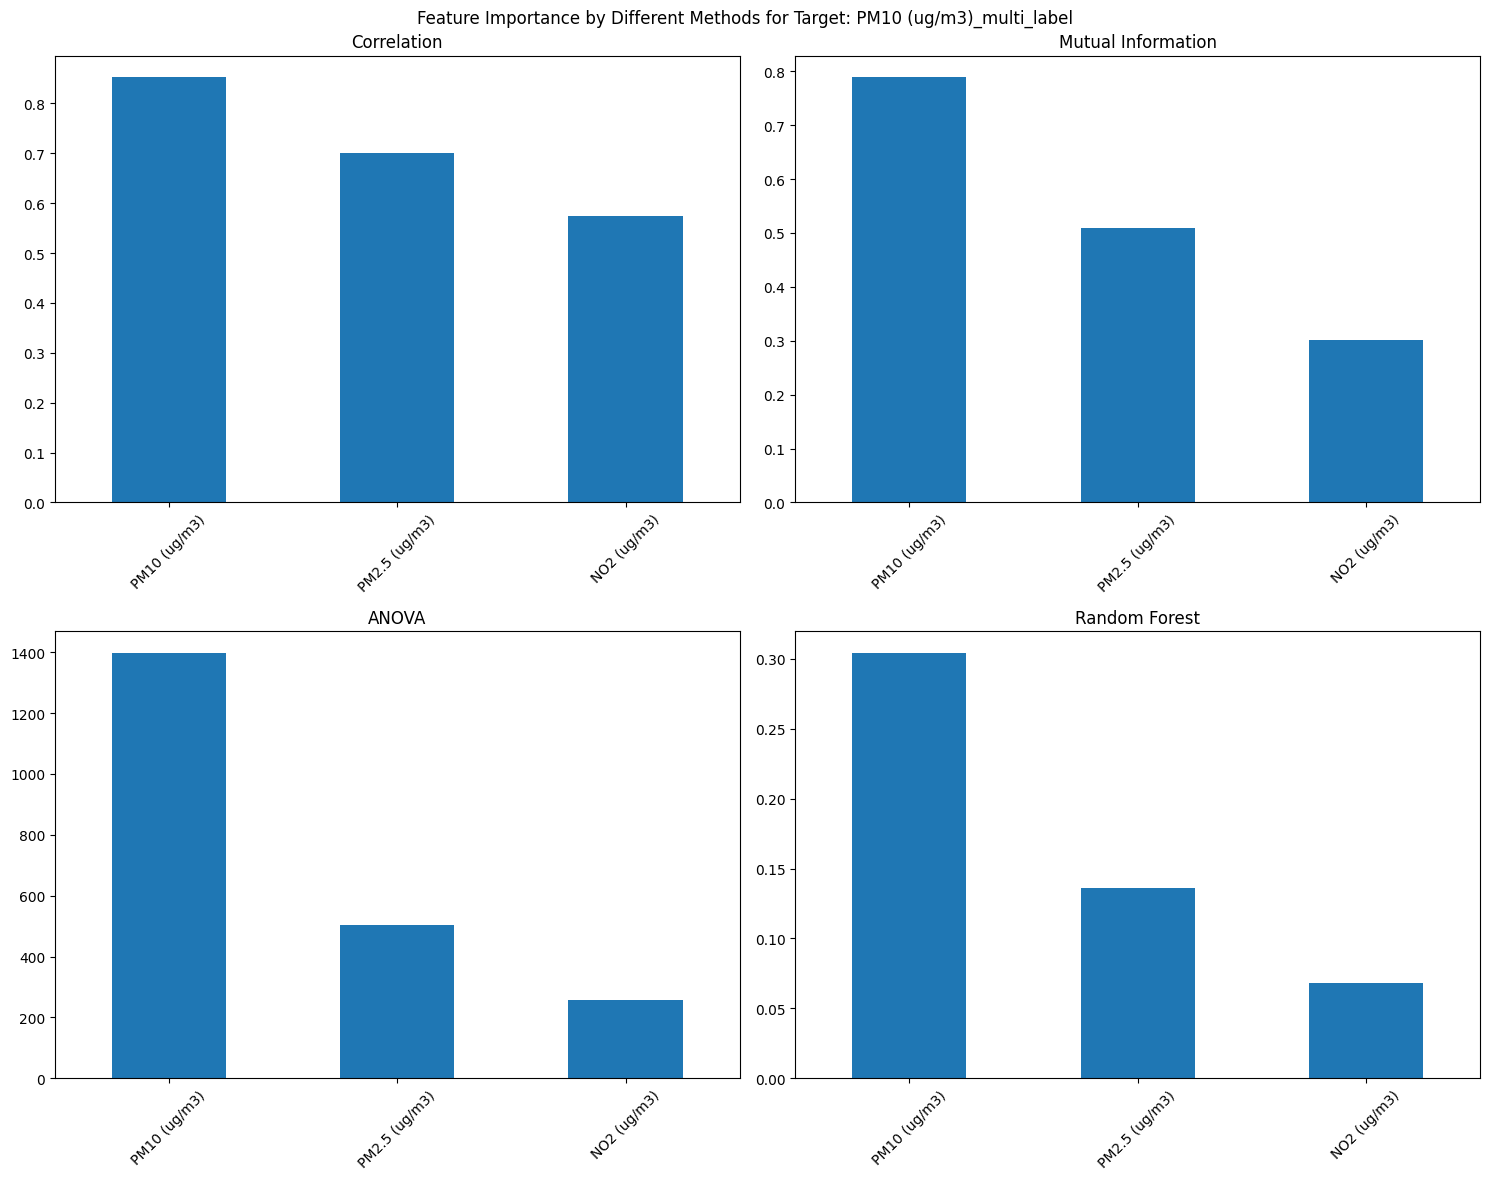

Features that appear in multiple methods:
PM2.5 (ug/m3)    4
PM10 (ug/m3)     4
AT (degree C)    4
Name: count, dtype: int64


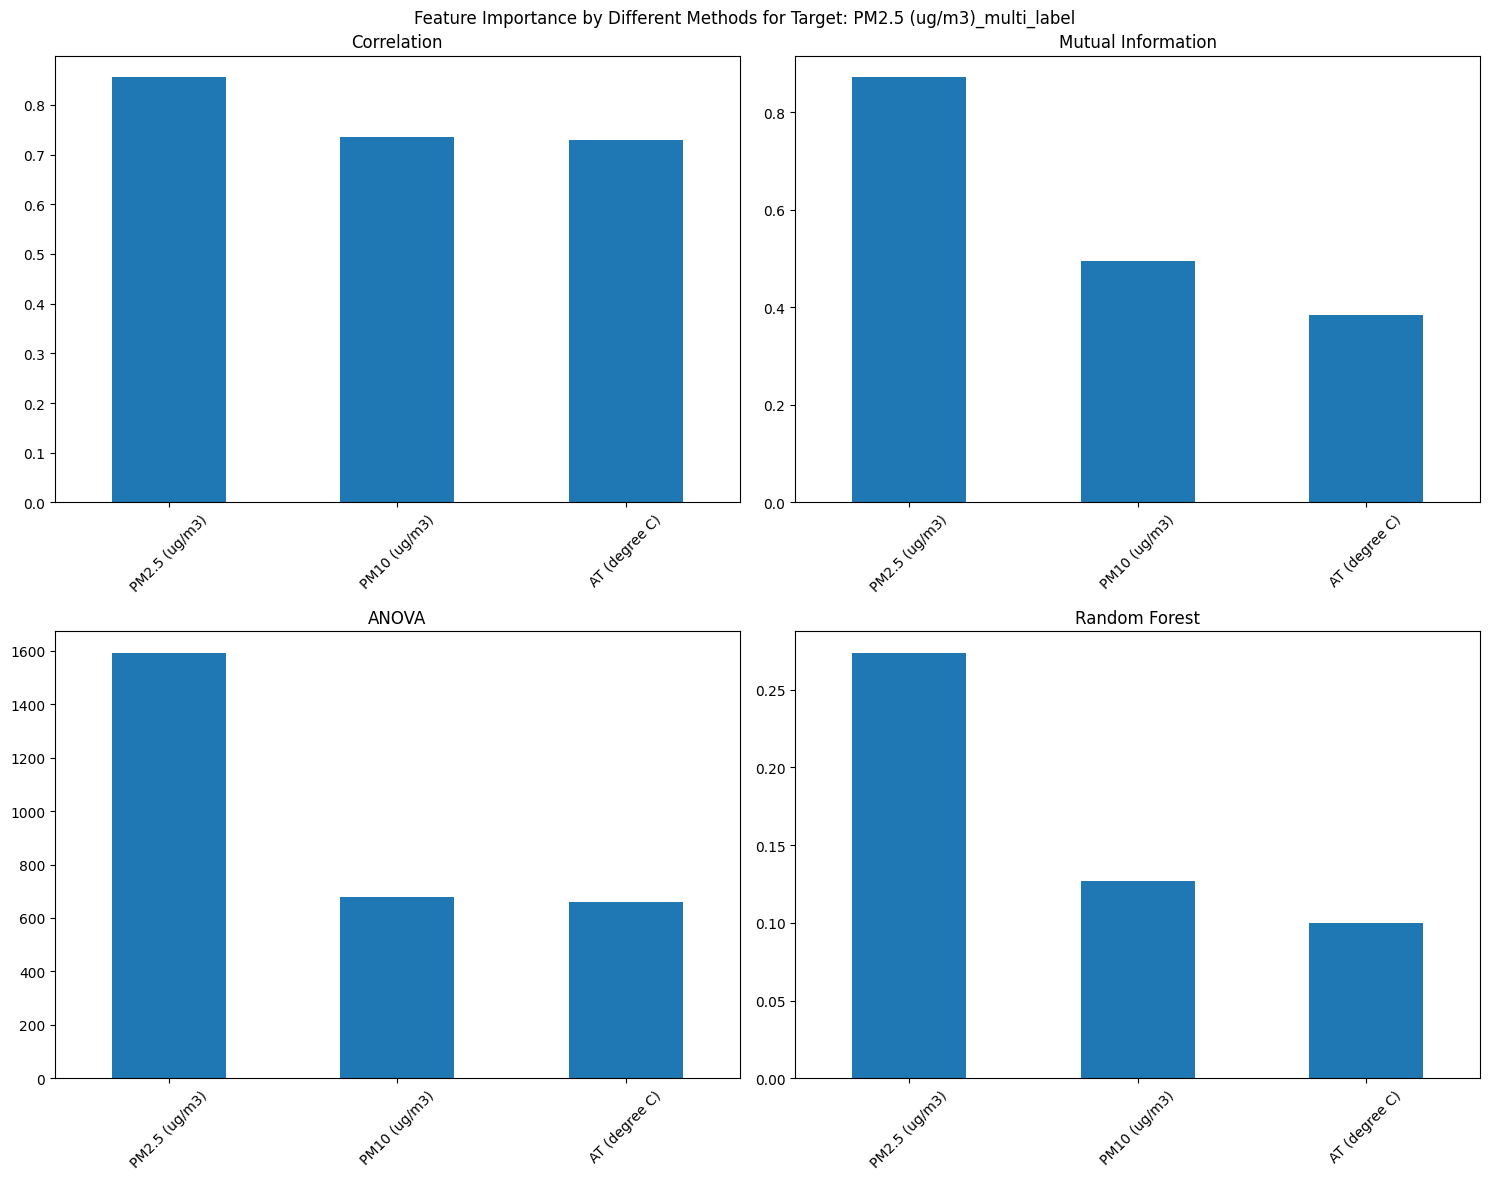

Features that appear in multiple methods:
NO (ug/m3)      4
NO2 (ug/m3)     4
PM10 (ug/m3)    4
Name: count, dtype: int64


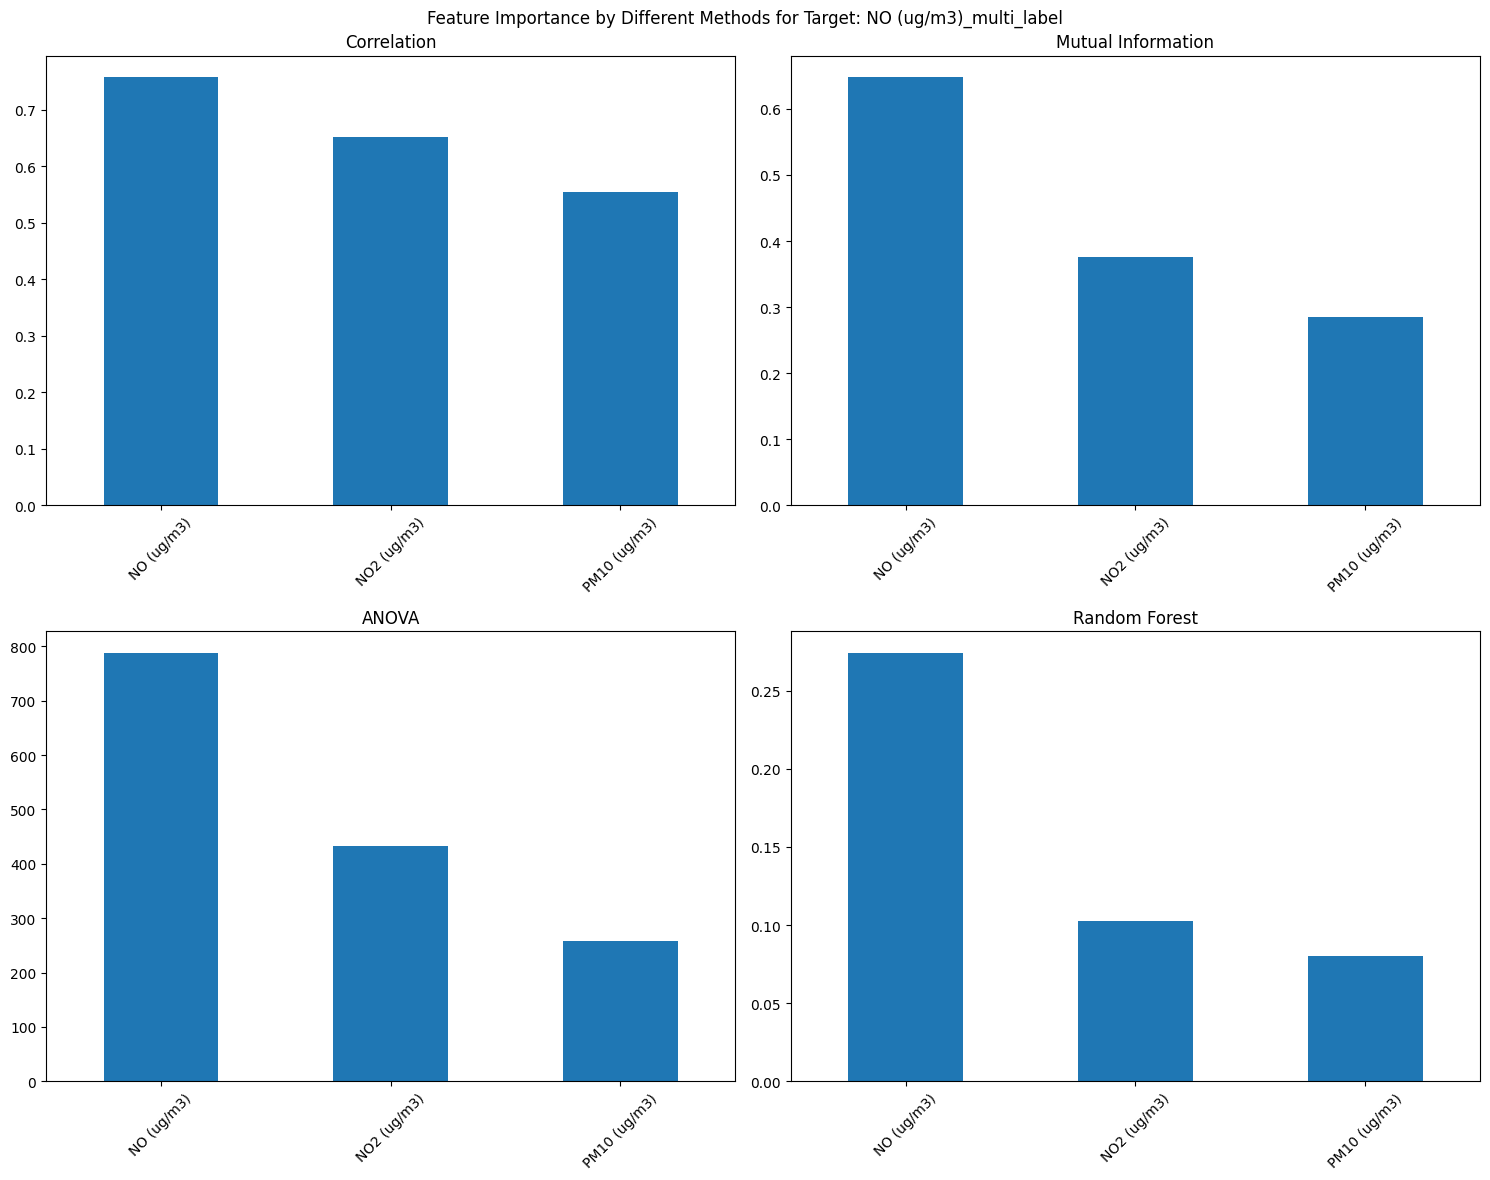

Features that appear in multiple methods:
NO2 (ug/m3)     4
NO (ug/m3)      4
PM10 (ug/m3)    3
Name: count, dtype: int64


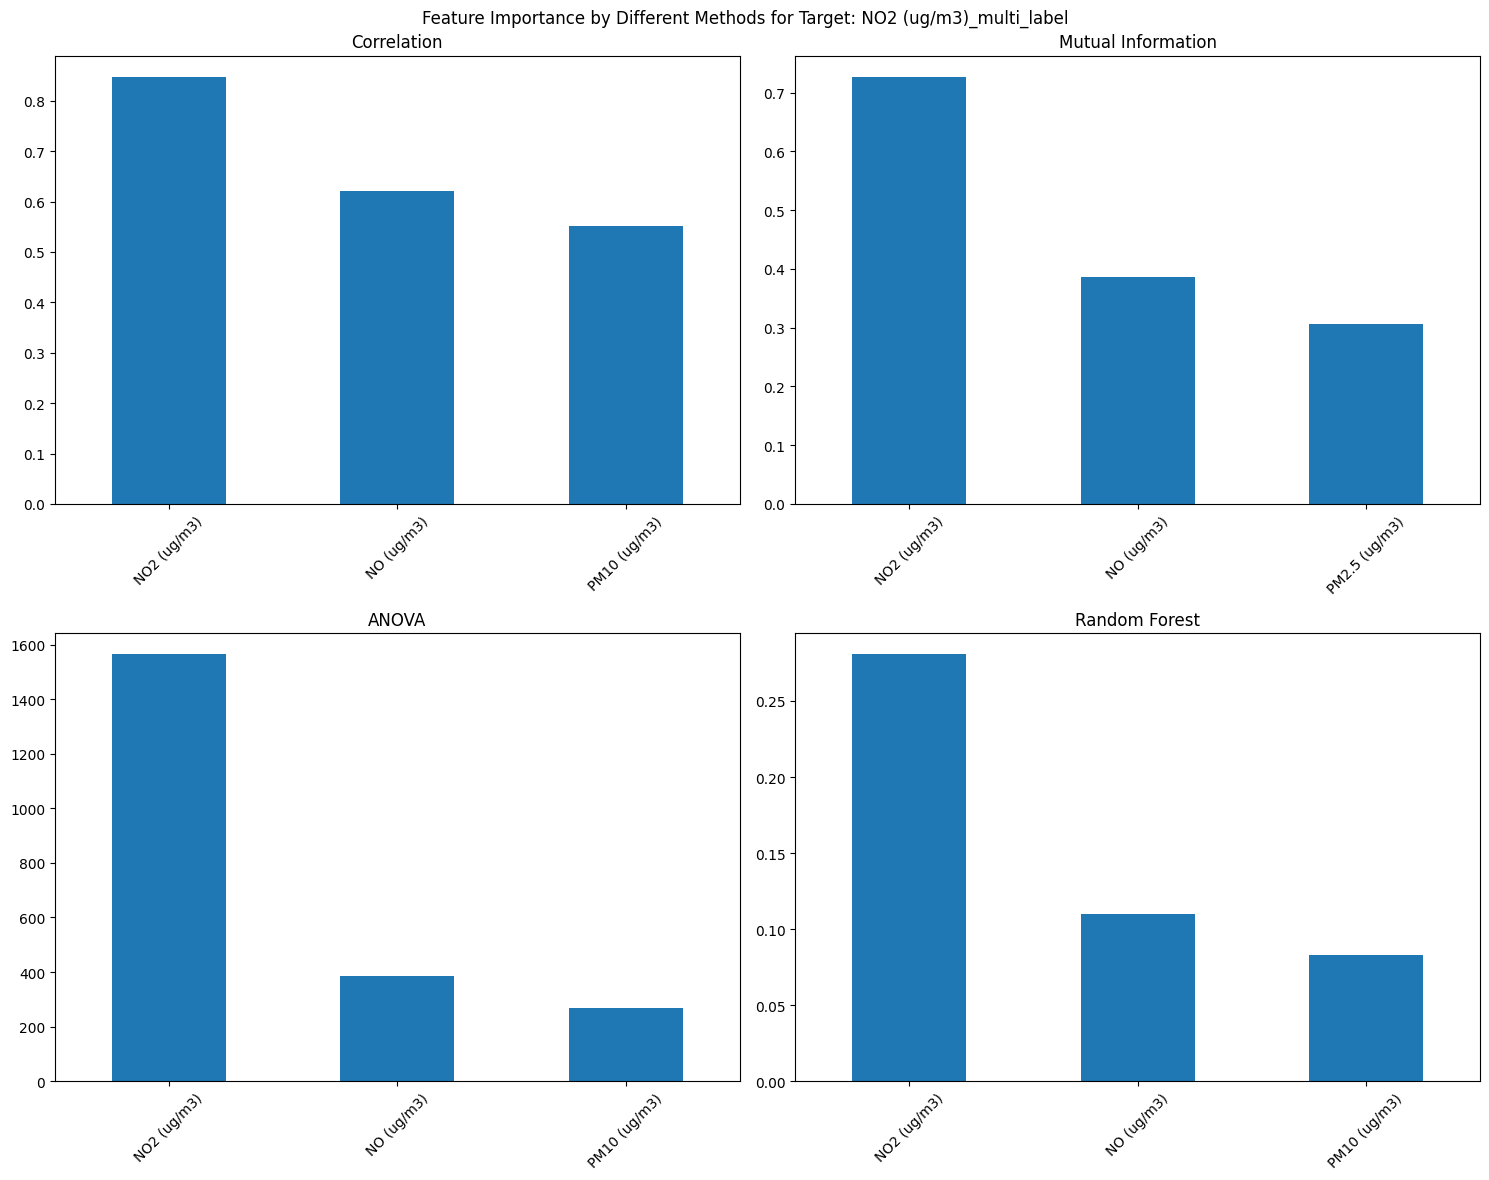

In [ ]:
selector_multi = {}
for key, value in df_balanced_multi_label.items():
  selector_multi[f'{key}'] = FeatureSelector(value, f'{key}_multi_label')

  # Ottieni i risultati
  scores_multi, feature_counts_multi = selector_multi[f'{key}'].compare_methods()

Valutazione delle performance

In [ ]:

for key, value in selector_multi.items():
    print(f'Valutazione per {key}')

    eval_results_multi = value.eval_feature_sets(type=1)

    plot_scores_table(eval_results_multi)

    plot_multi_class_results(eval_results_multi)


Output hidden; open in https://colab.research.google.com to view.

### Seconda prova
Non bilanciamo il dataset ma usiamo 4 feature per classificare

Features that appear in multiple methods:
Ozone (ug/m3)    4
RH (%)           4
SR (W/mt2)       3
AT (degree C)    2
PM2.5 (ug/m3)    2
Name: count, dtype: int64


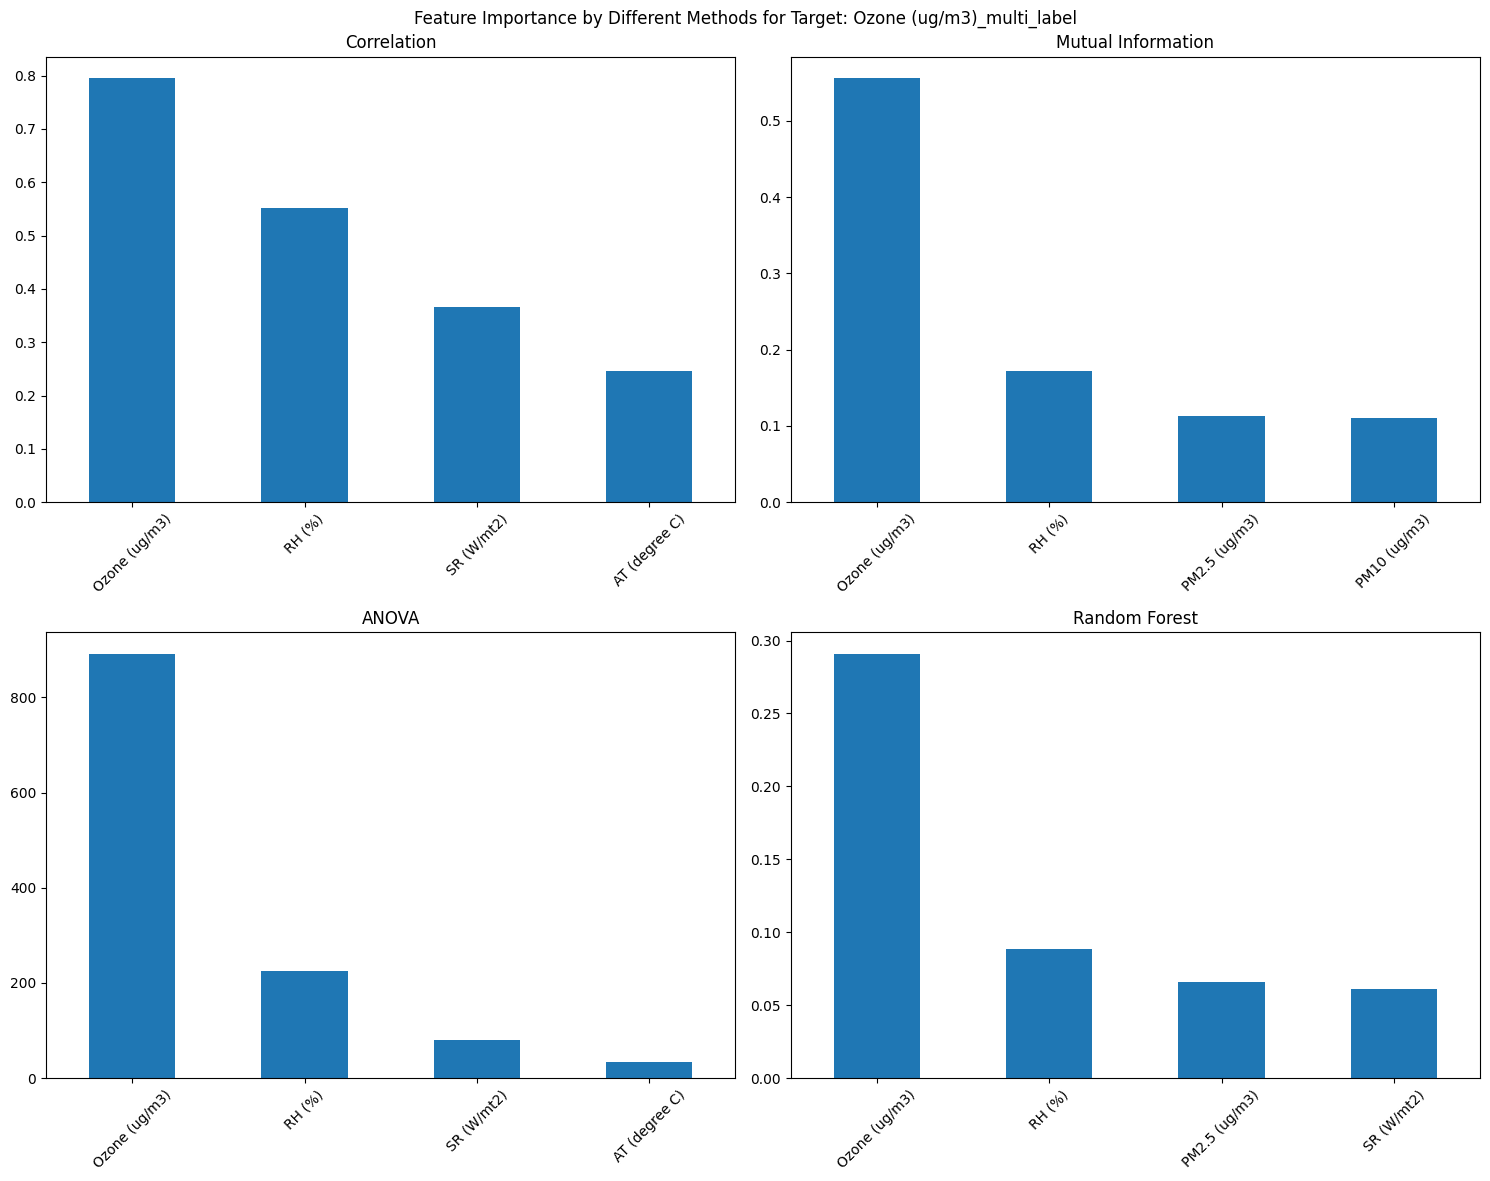

Features that appear in multiple methods:
CO (mg/m3)       4
PM2.5 (ug/m3)    4
SR (W/mt2)       3
NO2 (ug/m3)      2
PM10 (ug/m3)     2
Name: count, dtype: int64


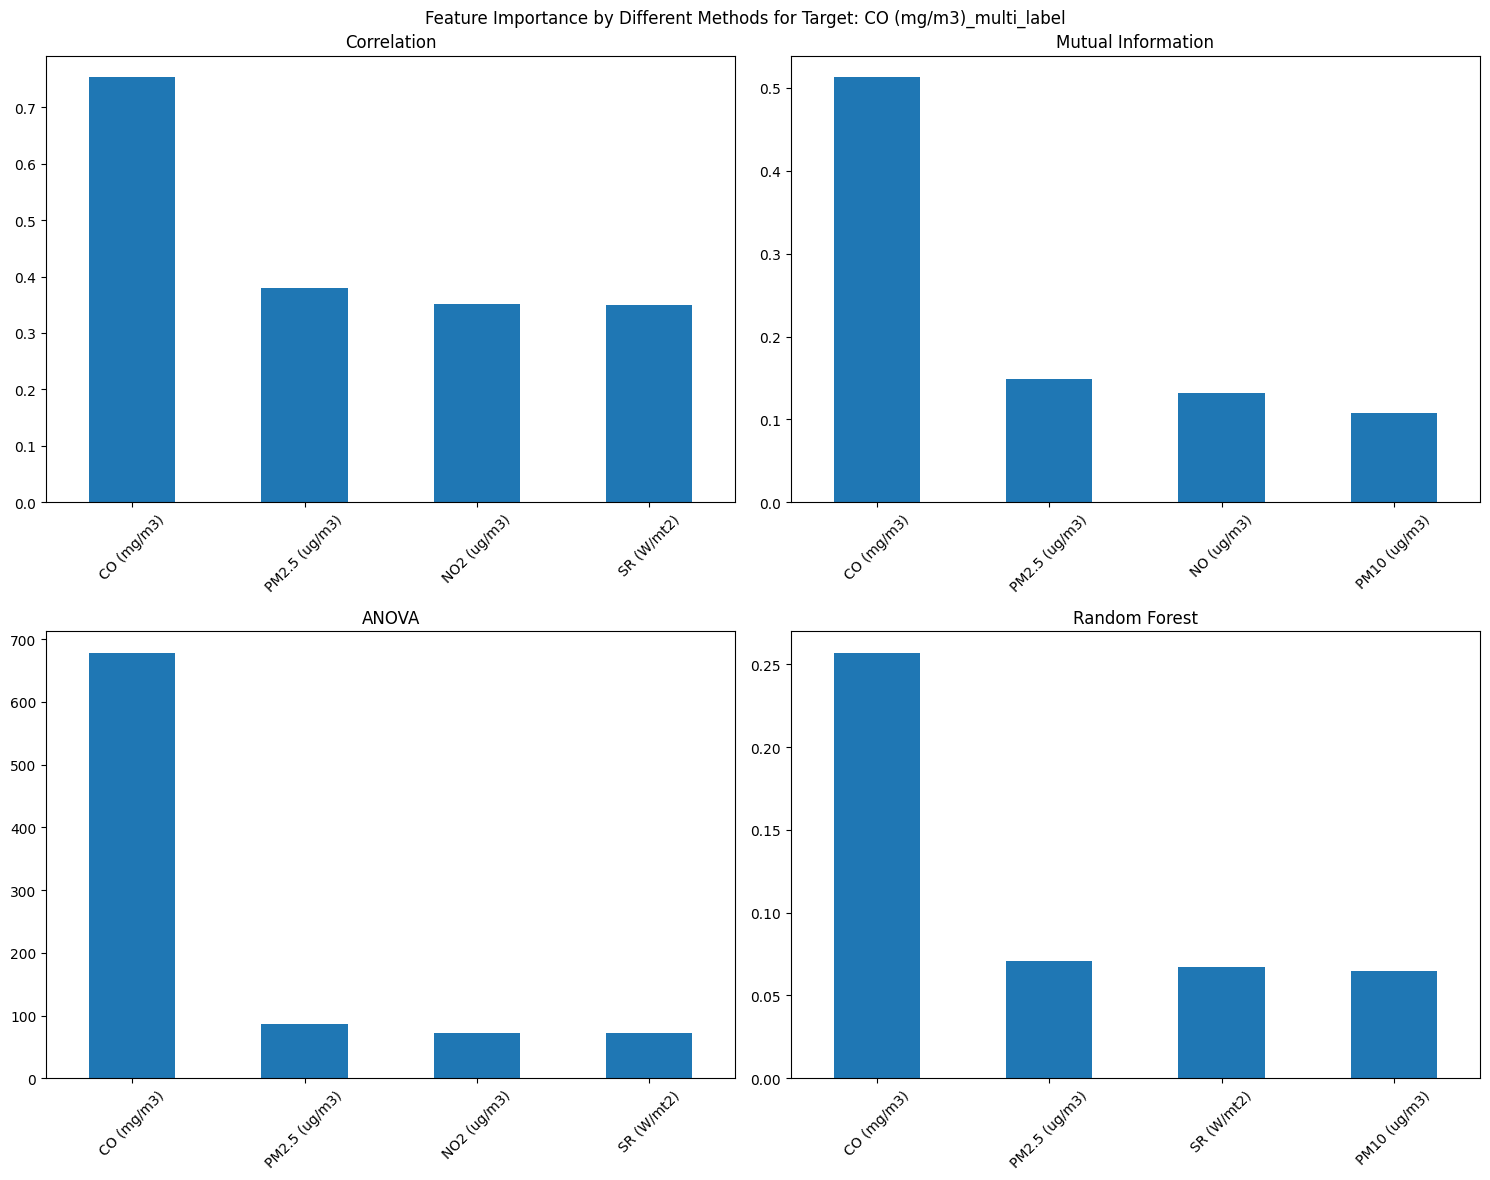

Features that appear in multiple methods:
SO2 (ug/m3)      4
RH (%)           3
PM10 (ug/m3)     3
Ozone (ug/m3)    3
Name: count, dtype: int64


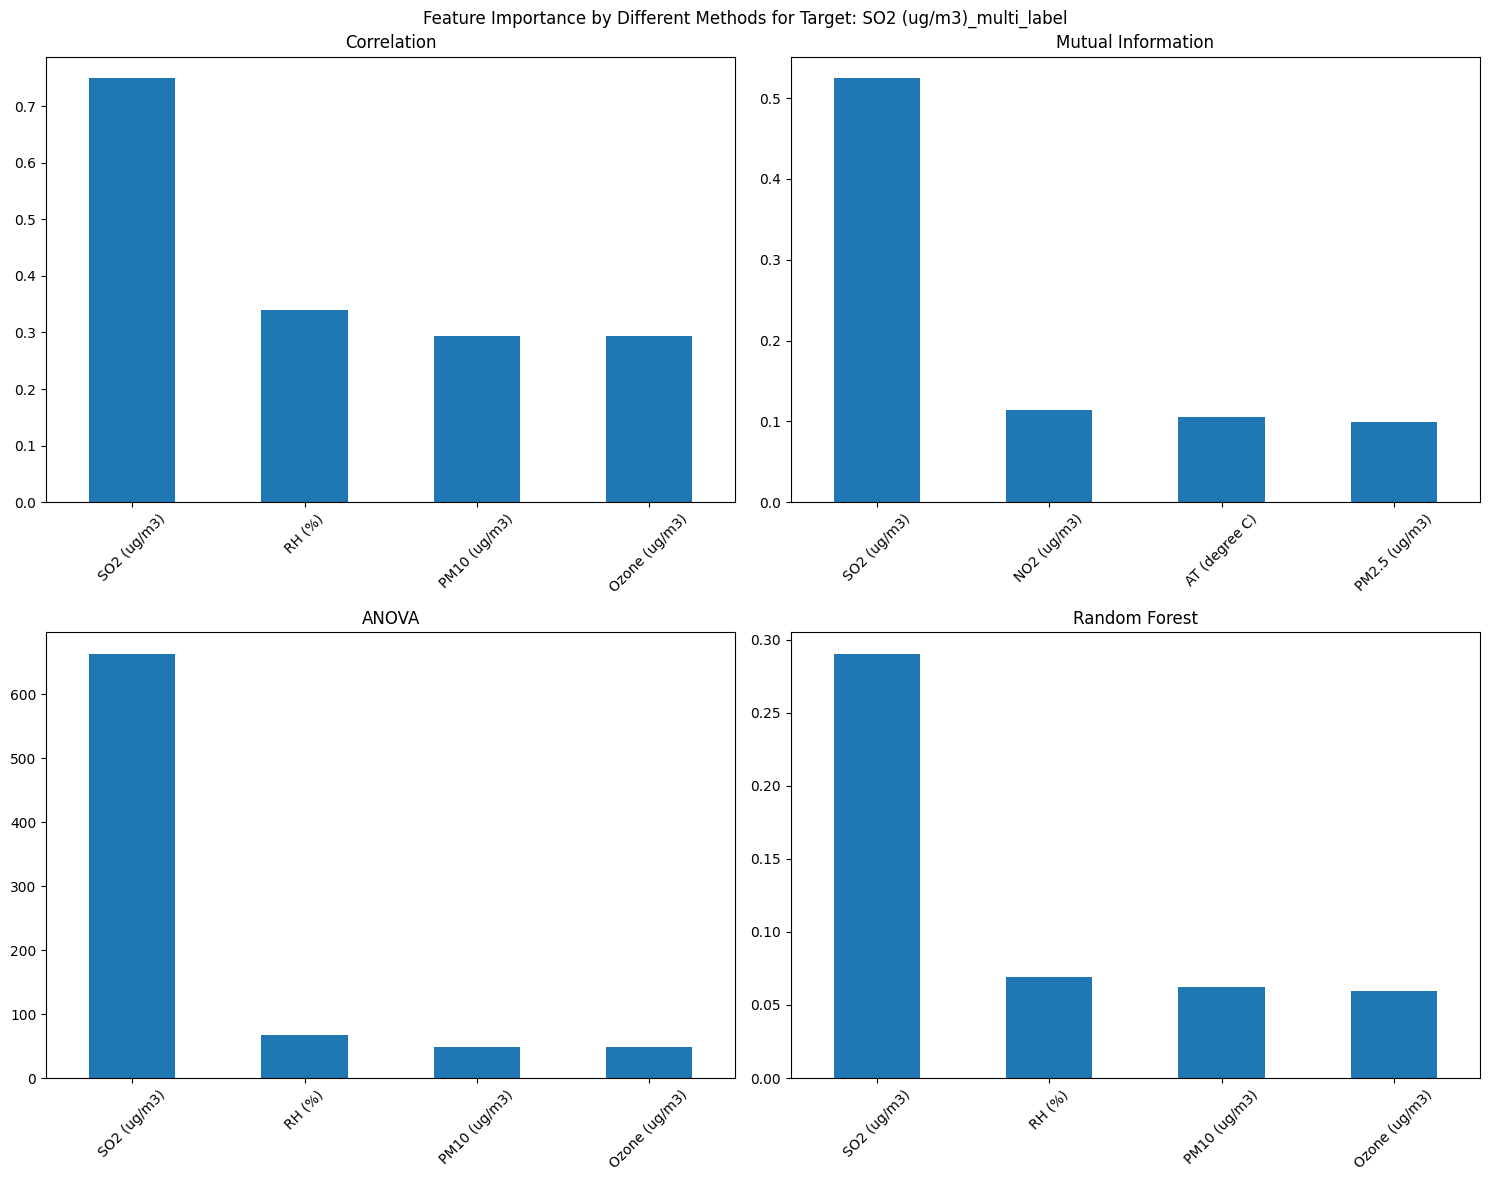

Features that appear in multiple methods:
PM10 (ug/m3)     4
PM2.5 (ug/m3)    4
NO2 (ug/m3)      4
NO (ug/m3)       3
Name: count, dtype: int64


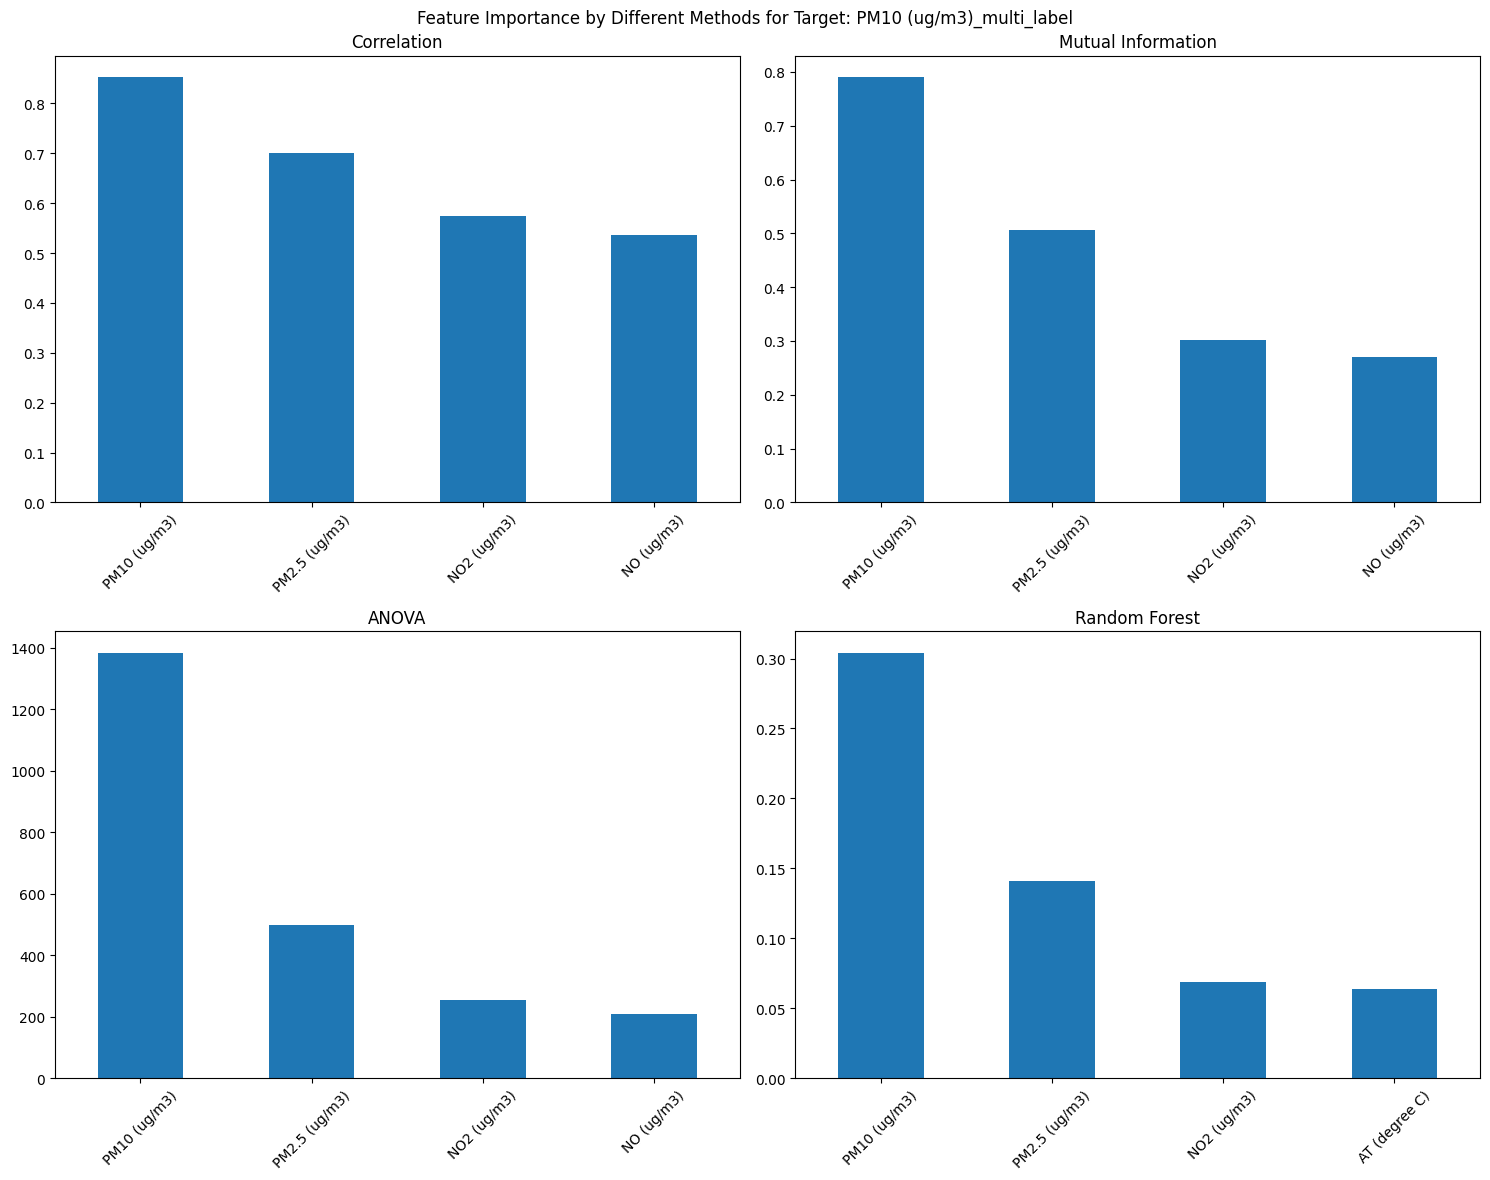

Features that appear in multiple methods:
PM2.5 (ug/m3)    4
PM10 (ug/m3)     4
AT (degree C)    4
BP (mmHg)        2
Name: count, dtype: int64


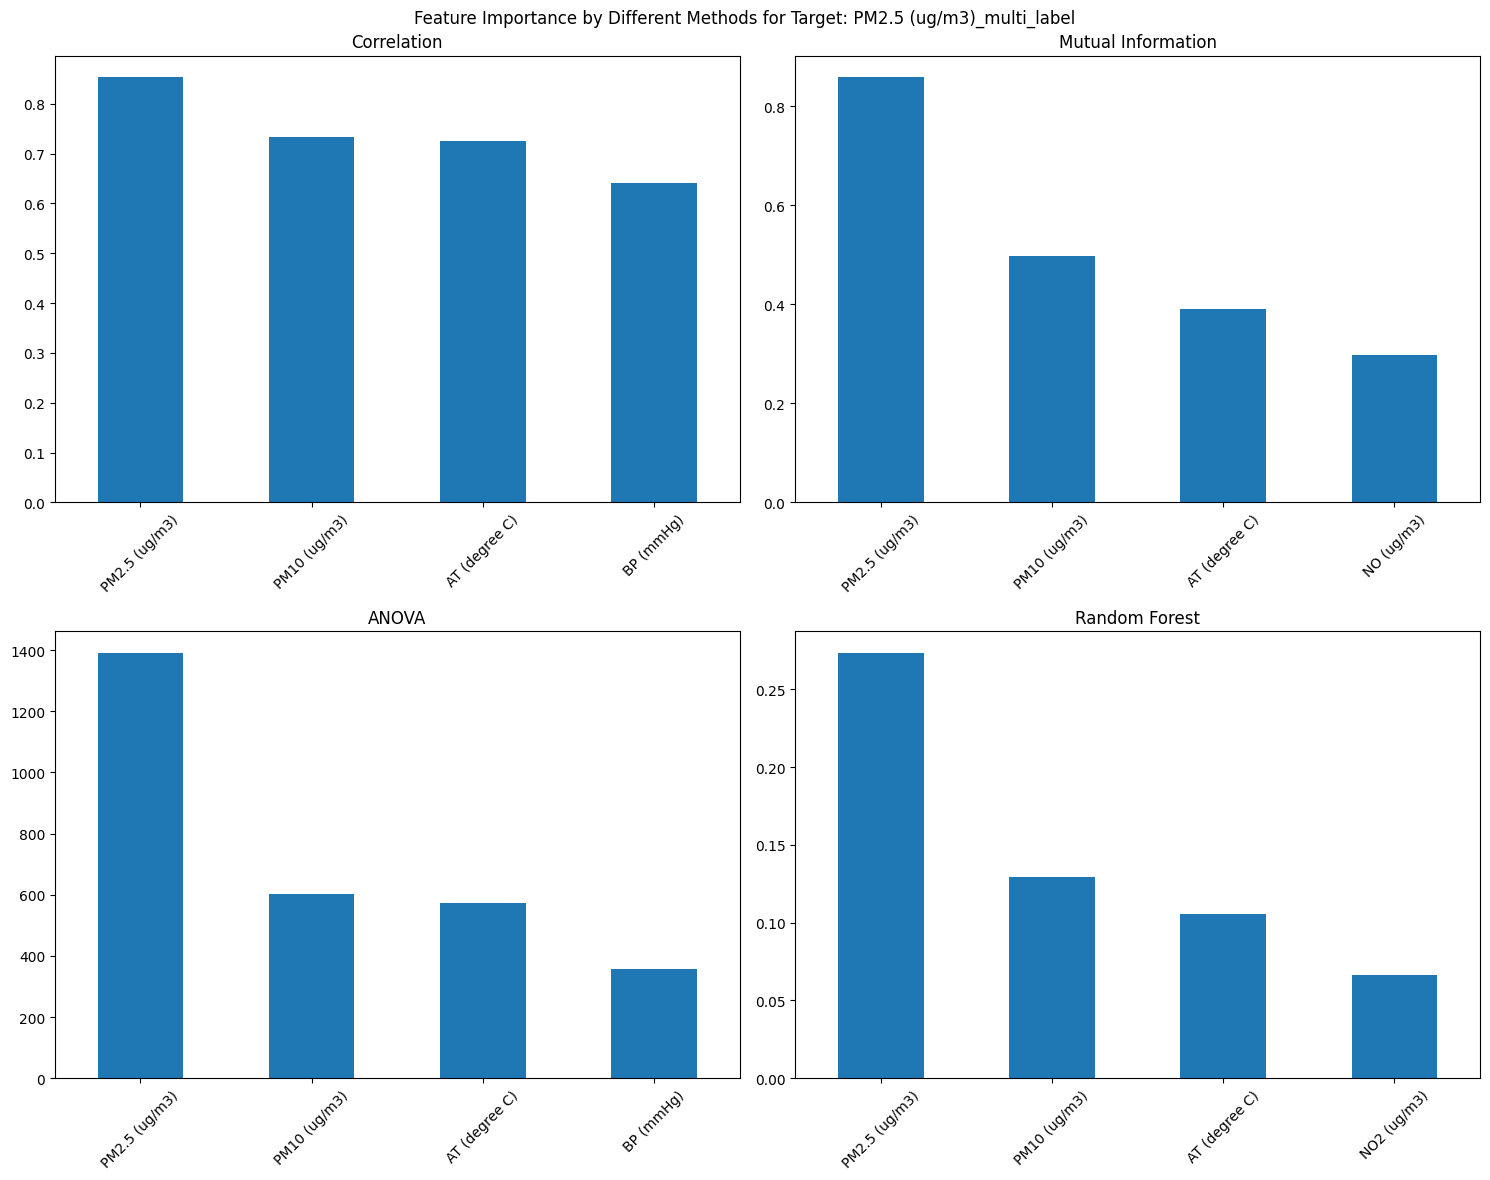

Features that appear in multiple methods:
NO (ug/m3)       4
NO2 (ug/m3)      4
PM10 (ug/m3)     4
PM2.5 (ug/m3)    4
Name: count, dtype: int64


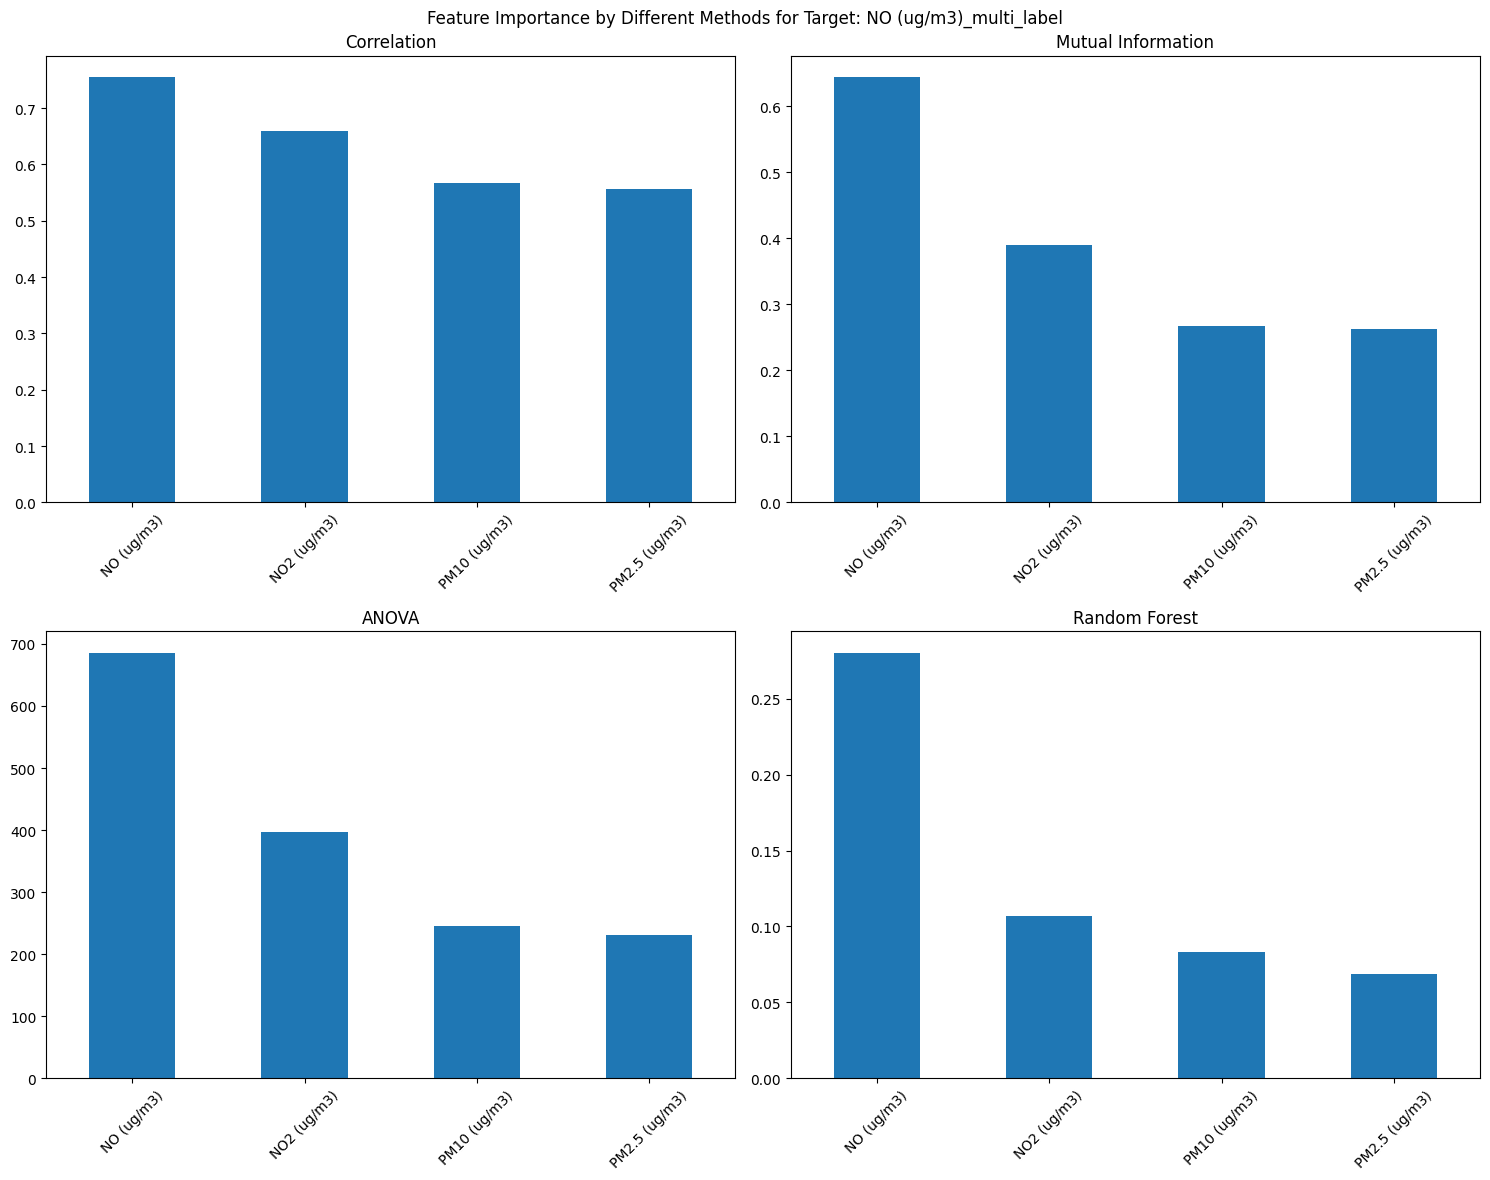

Features that appear in multiple methods:
NO2 (ug/m3)      4
NO (ug/m3)       4
PM10 (ug/m3)     4
PM2.5 (ug/m3)    4
Name: count, dtype: int64


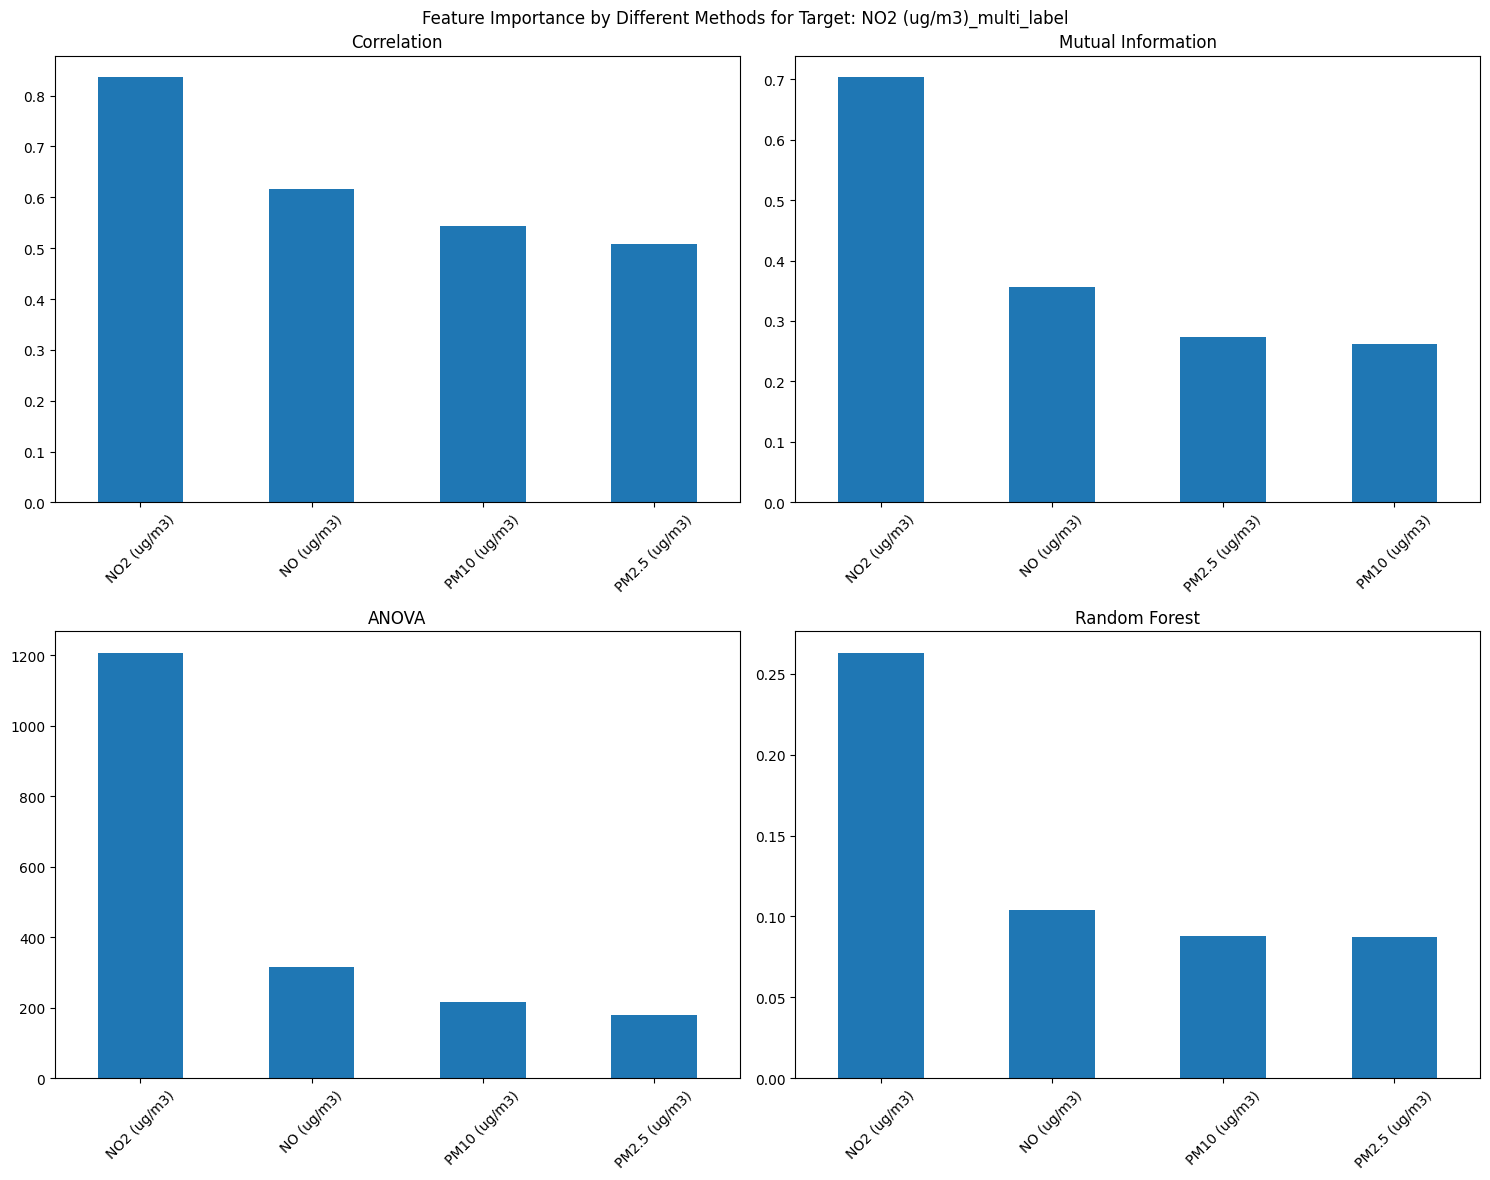

In [ ]:
selector_multi = {}
for key, value in df_multi_label.items():
  selector_multi[f'{key}'] = FeatureSelector(value, f'{key}_multi_label', n_features=4)

  # Ottieni i risultati
  scores_multi, feature_counts_multi = selector_multi[f'{key}'].compare_methods()

In [ ]:
for key, value in selector_multi.items():
    print(f'Valutazione per {key}')
    eval_results_multi = value.eval_feature_sets(type=1)
    plot_scores_table(eval_results_multi)
    plot_multi_class_results(eval_results_multi)

Output hidden; open in https://colab.research.google.com to view.

### Terza prova
Uniamo le due precendenti, andiamo a bilanciare il dataset e usiamo 4 feature per classificare

In [ ]:
#Bilanciamento

# Crea un dizionario vuoto per contenere i dataframe bilanciati
df_balanced_multi_label = {}

for key, value in selector_multi.items():
    print(f'Valutazione sbilanciamento classi per dataframe con classi inquinamento su {key}')

    # Bilancia il dataframe
    df_balanced, method = balance_classes(value.df, f'{key}_multi_label', strategy='auto')  # 'auto' fa scegliere automaticamente il metodo di bilanciamento

    # Salva il dataframe bilanciato nel dizionario con la chiave corrispondente
    df_balanced_multi_label[key] = df_balanced

    # Stampa il metodo di bilanciamento utilizzato
    print(f"Metodo di bilanciamento utilizzato: {method}")


Valutazione sbilanciamento classi per dataframe con classi inquinamento su Ozone (ug/m3)
Distribuzione originale delle classi: {'Nullo': 440, 'Basso': 378, 'Medio': 369, 'Alto': 363}
Distribuzione nuova delle classi: {'Medio': 440, 'Nullo': 440, 'Basso': 440, 'Alto': 440}
Metodo di bilanciamento utilizzato: SMOTE
Valutazione sbilanciamento classi per dataframe con classi inquinamento su CO (mg/m3)
Distribuzione originale delle classi: {'Basso': 439, 'Alto': 413, 'Nullo': 403, 'Medio': 295}
Distribuzione nuova delle classi: {'Alto': 439, 'Basso': 439, 'Nullo': 439, 'Medio': 439}
Metodo di bilanciamento utilizzato: SMOTE
Valutazione sbilanciamento classi per dataframe con classi inquinamento su SO2 (ug/m3)
Distribuzione originale delle classi: {'Nullo': 451, 'Basso': 445, 'Medio': 372, 'Alto': 282}
Distribuzione nuova delle classi: {'Alto': 451, 'Basso': 451, 'Medio': 451, 'Nullo': 451}
Metodo di bilanciamento utilizzato: SMOTE
Valutazione sbilanciamento classi per dataframe con classi i

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validatio

Distribuzione nuova delle classi: {'Alto': 392, 'Basso': 392, 'Medio': 392, 'Nullo': 392}
Metodo di bilanciamento utilizzato: SMOTE
Valutazione sbilanciamento classi per dataframe con classi inquinamento su PM2.5 (ug/m3)
Distribuzione originale delle classi: {'Nullo': 434, 'Medio': 395, 'Alto': 362, 'Basso': 359}
Distribuzione nuova delle classi: {'Alto': 434, 'Medio': 434, 'Basso': 434, 'Nullo': 434}
Metodo di bilanciamento utilizzato: SMOTE
Valutazione sbilanciamento classi per dataframe con classi inquinamento su NO (ug/m3)
Distribuzione originale delle classi: {'Alto': 439, 'Nullo': 408, 'Basso': 371, 'Medio': 332}
Distribuzione nuova delle classi: {'Alto': 439, 'Medio': 439, 'Basso': 439, 'Nullo': 439}
Metodo di bilanciamento utilizzato: SMOTE
Valutazione sbilanciamento classi per dataframe con classi inquinamento su NO2 (ug/m3)
Distribuzione originale delle classi: {'Nullo': 461, 'Medio': 407, 'Basso': 374, 'Alto': 308}
Distribuzione nuova delle classi: {'Alto': 461, 'Medio': 461

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validatio

Features that appear in multiple methods:
Ozone (ug/m3)    4
RH (%)           4
SR (W/mt2)       4
AT (degree C)    2
Name: count, dtype: int64


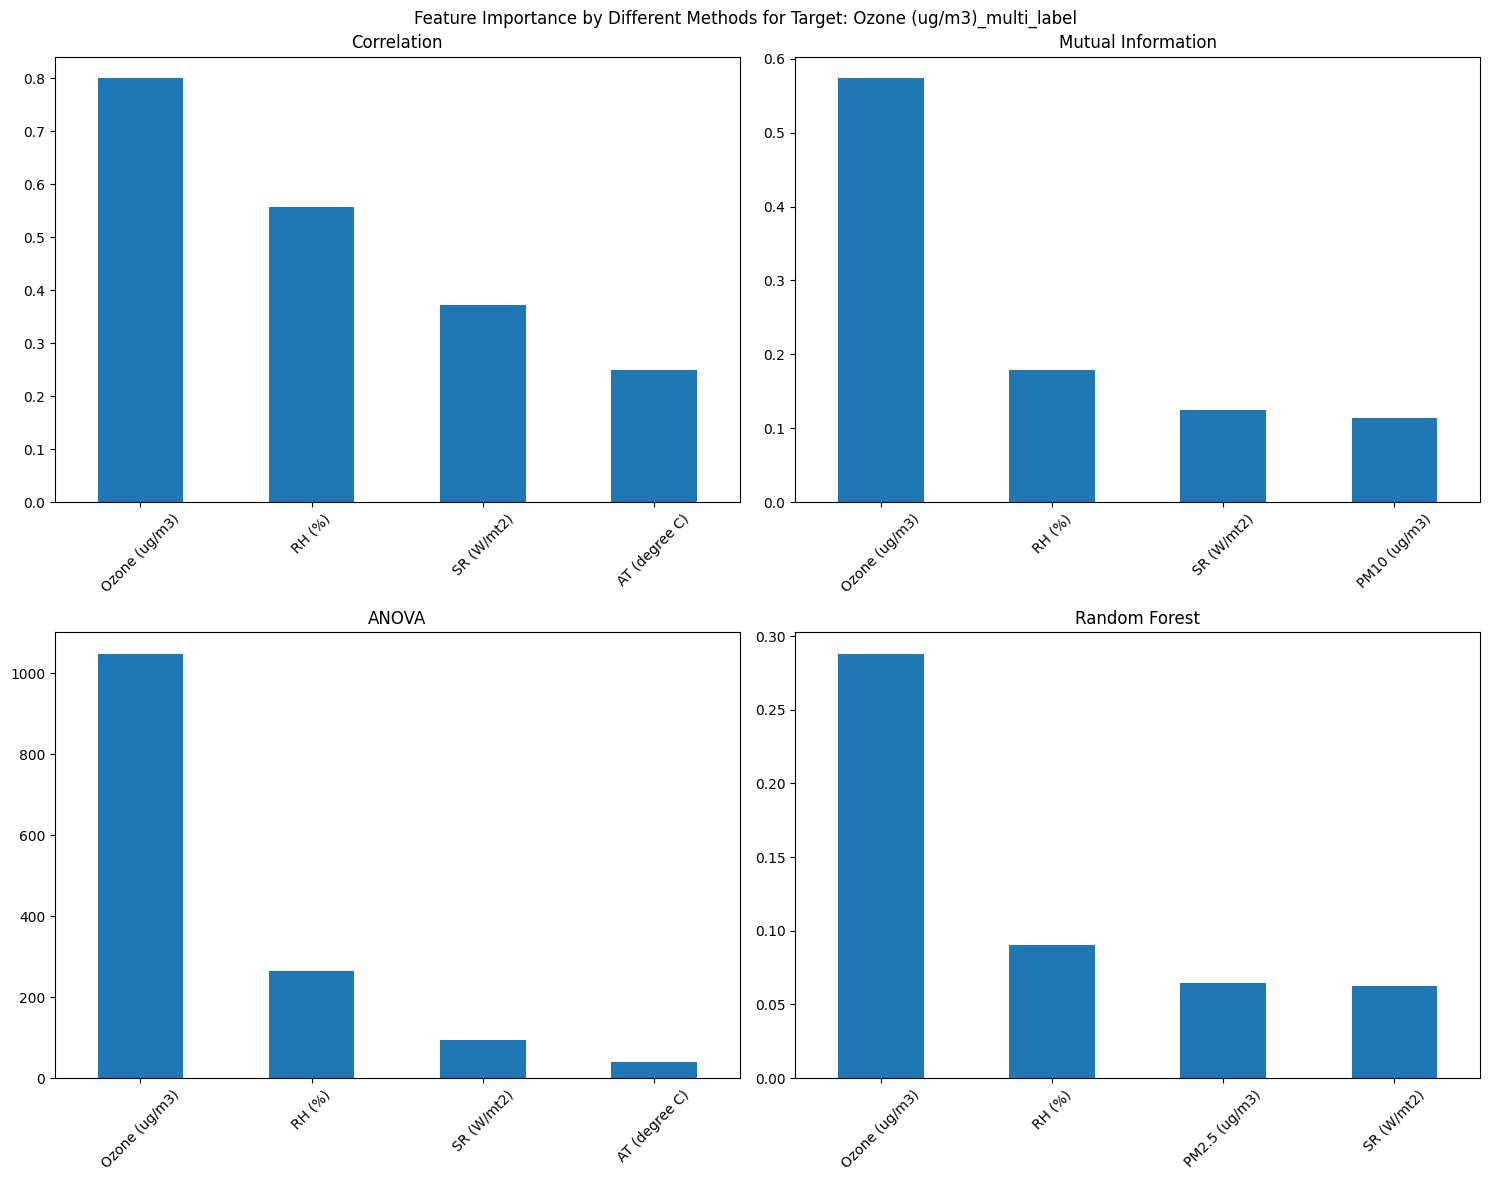

Features that appear in multiple methods:
CO (mg/m3)       4
PM2.5 (ug/m3)    4
SR (W/mt2)       3
NO2 (ug/m3)      2
PM10 (ug/m3)     2
Name: count, dtype: int64


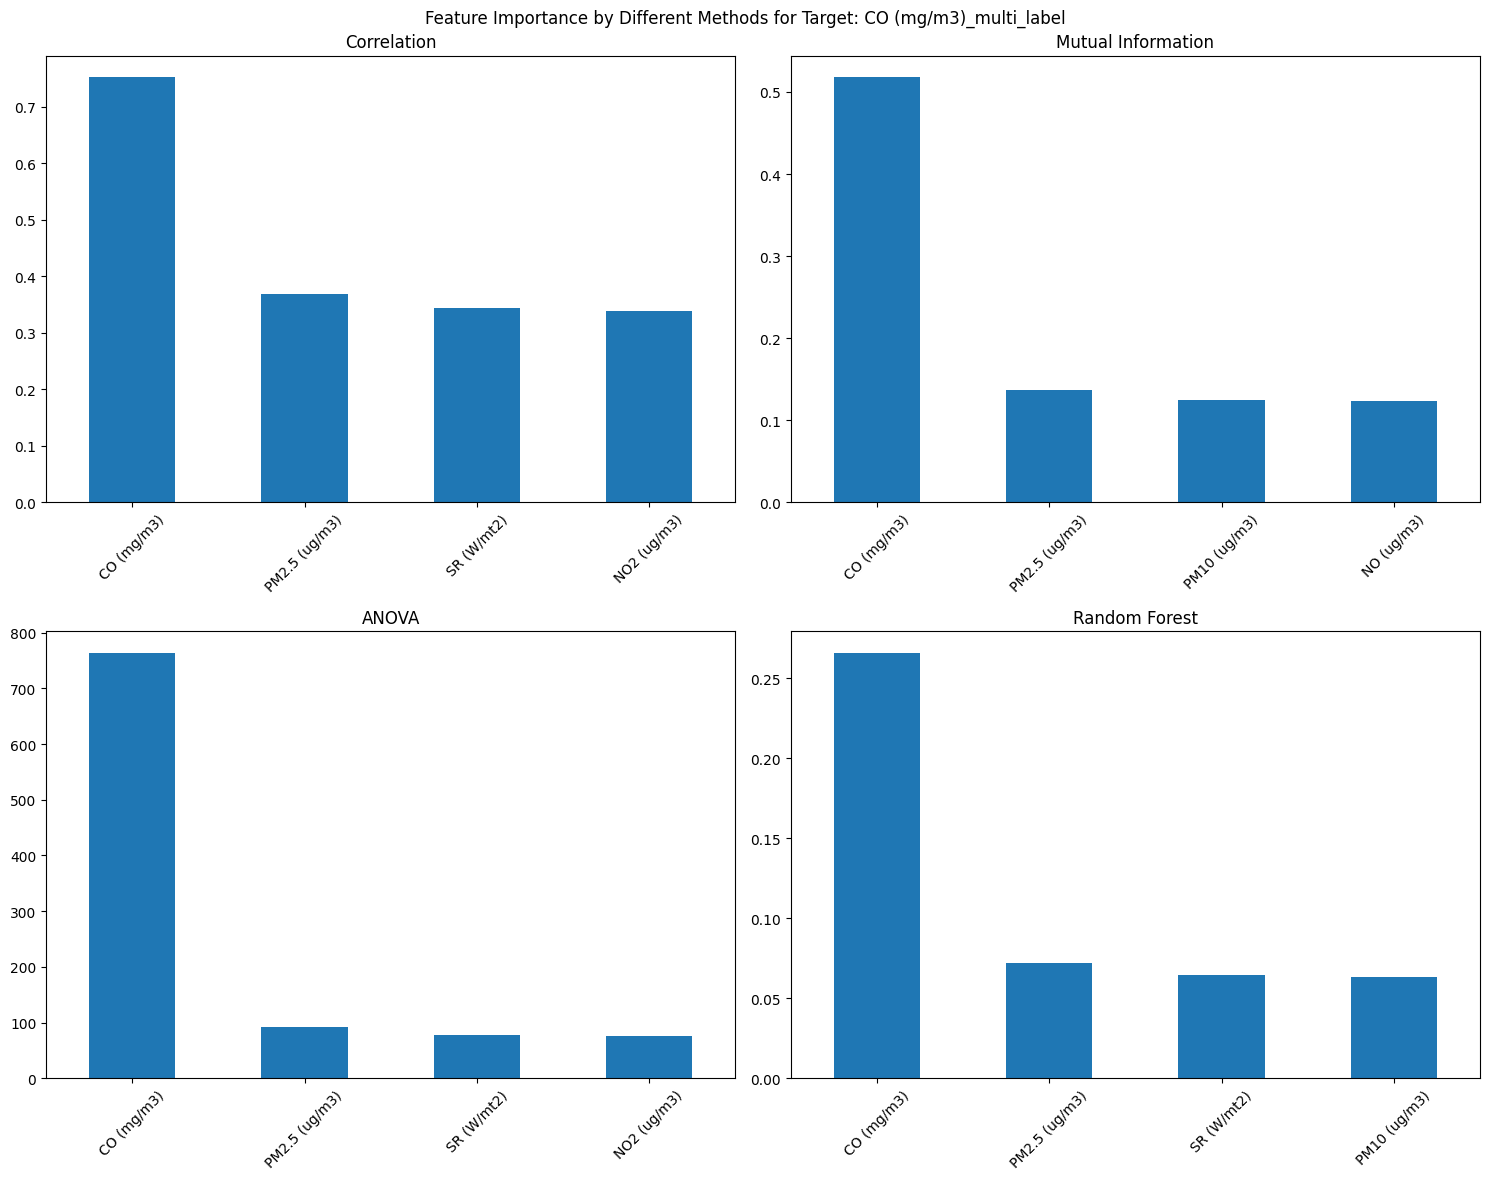

Features that appear in multiple methods:
SO2 (ug/m3)      4
RH (%)           3
NO2 (ug/m3)      3
Ozone (ug/m3)    2
Name: count, dtype: int64


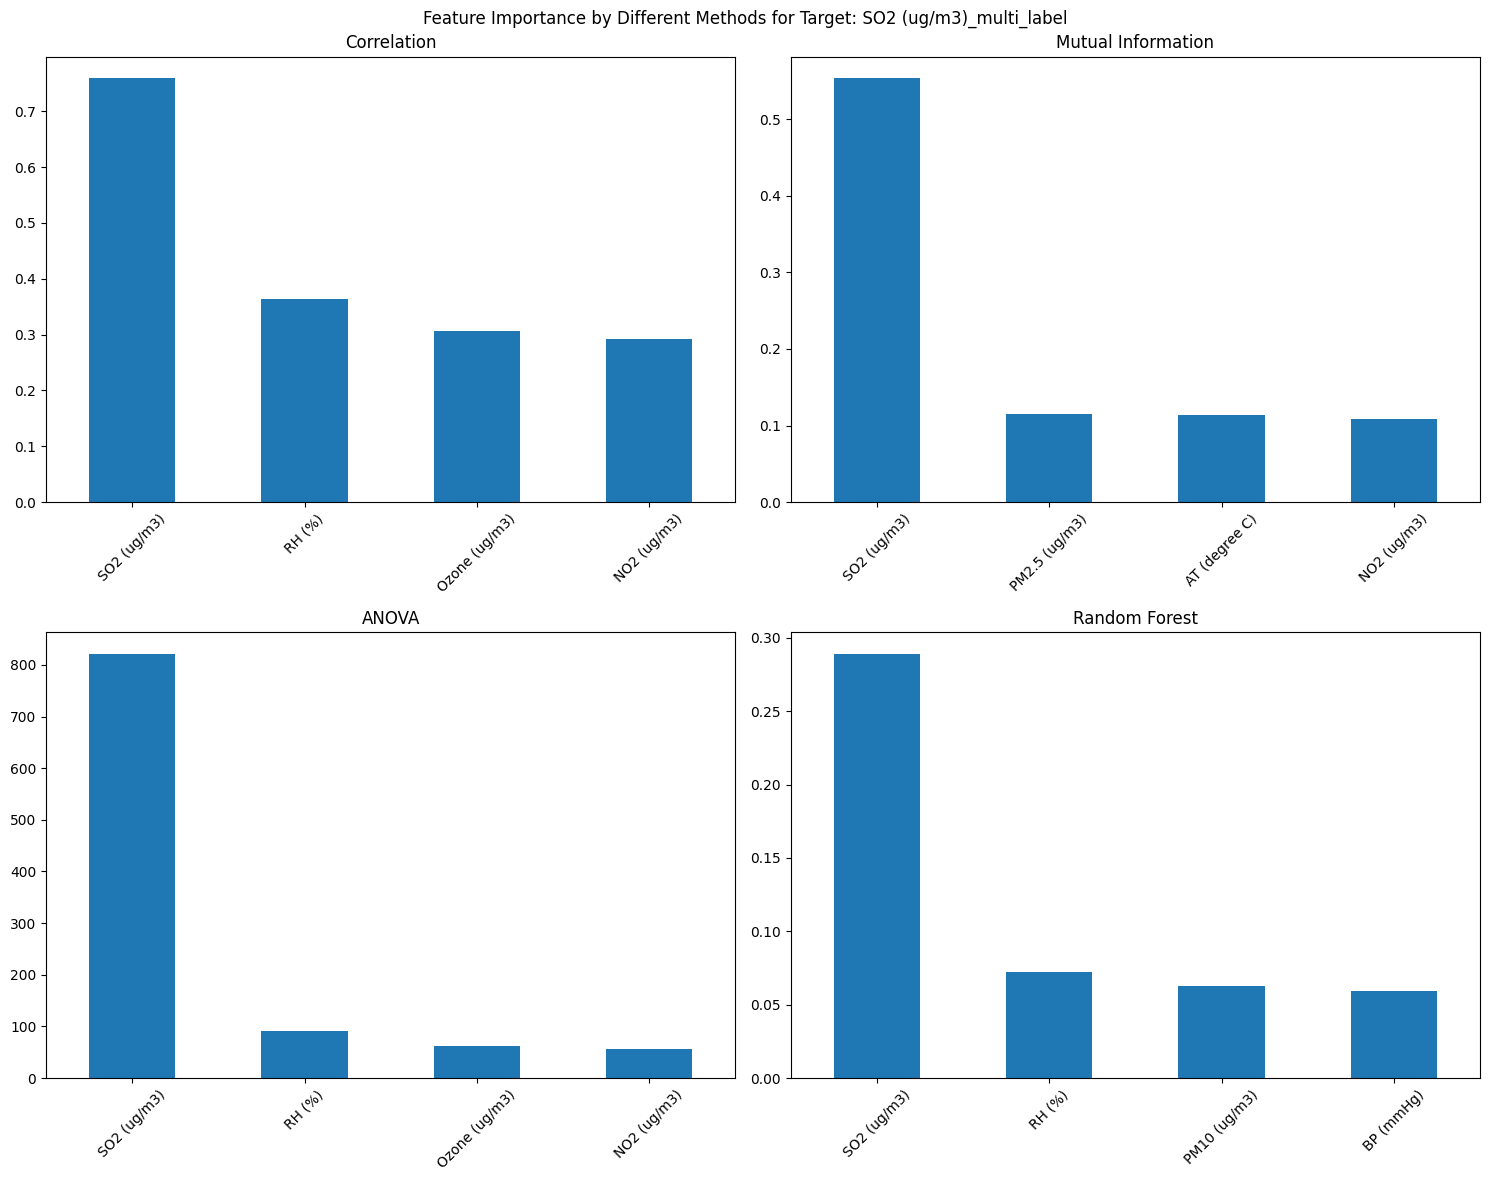

Features that appear in multiple methods:
PM10 (ug/m3)     4
PM2.5 (ug/m3)    4
NO2 (ug/m3)      4
NO (ug/m3)       3
Name: count, dtype: int64


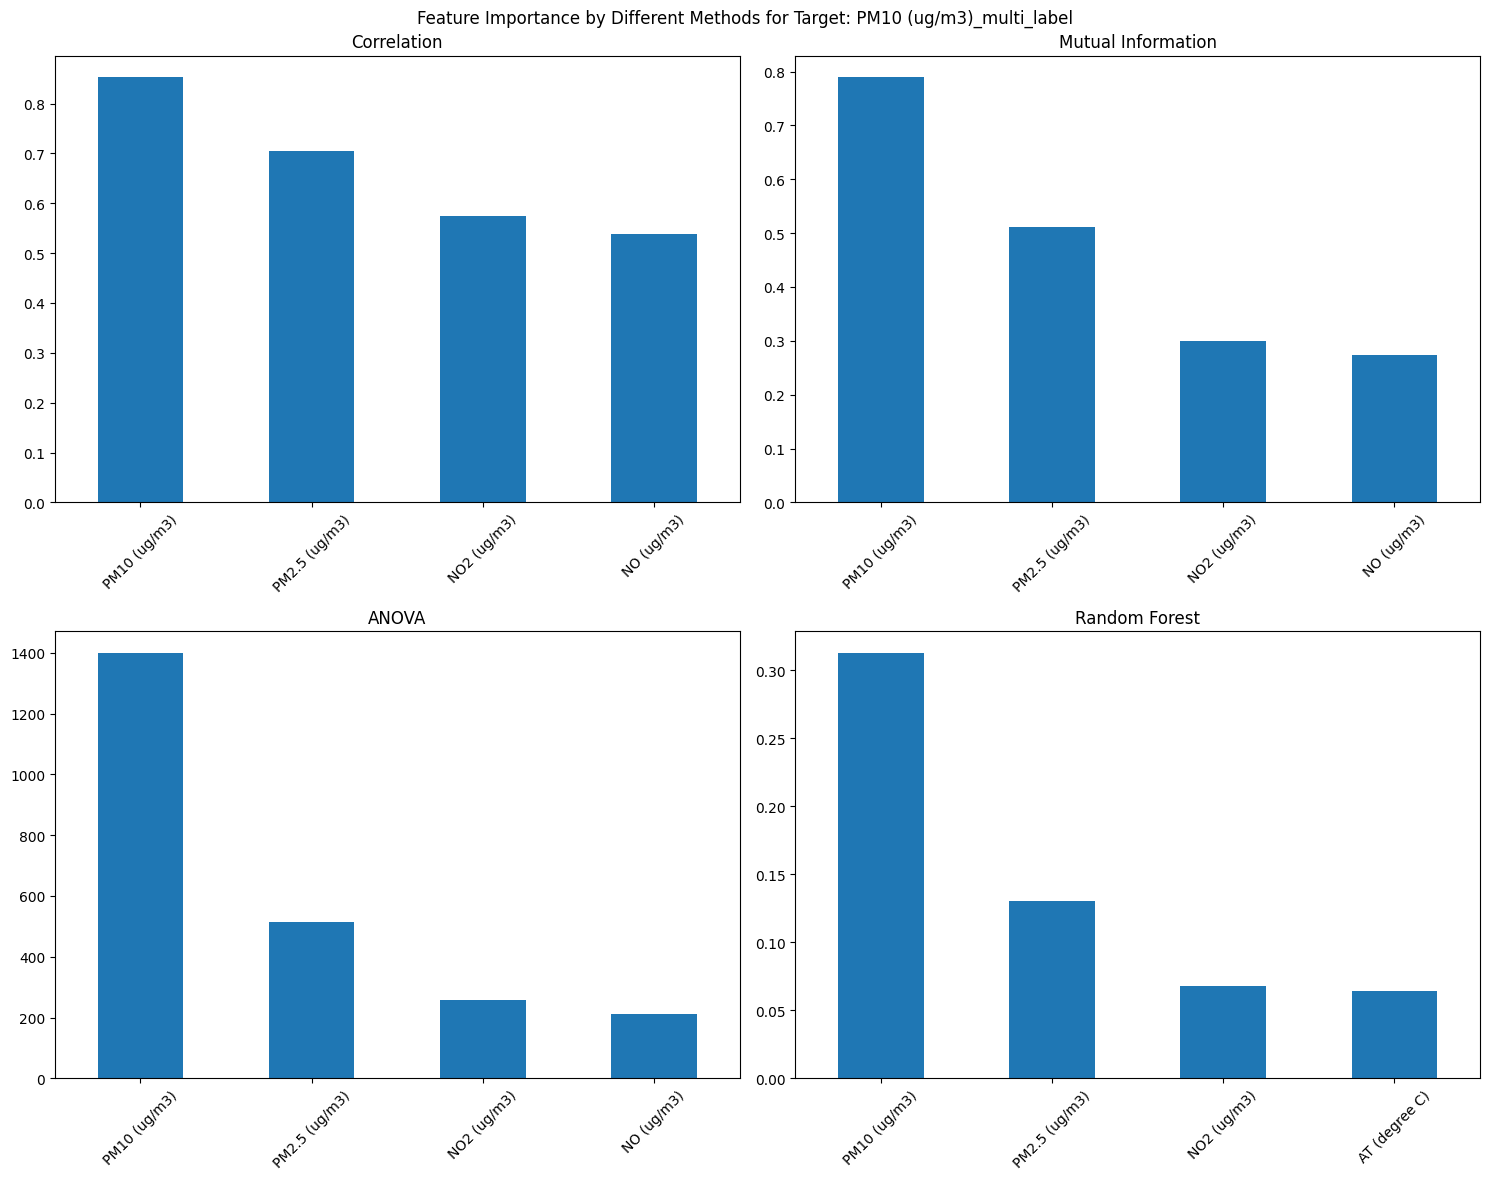

Features that appear in multiple methods:
PM2.5 (ug/m3)    4
AT (degree C)    4
PM10 (ug/m3)     4
BP (mmHg)        2
Name: count, dtype: int64


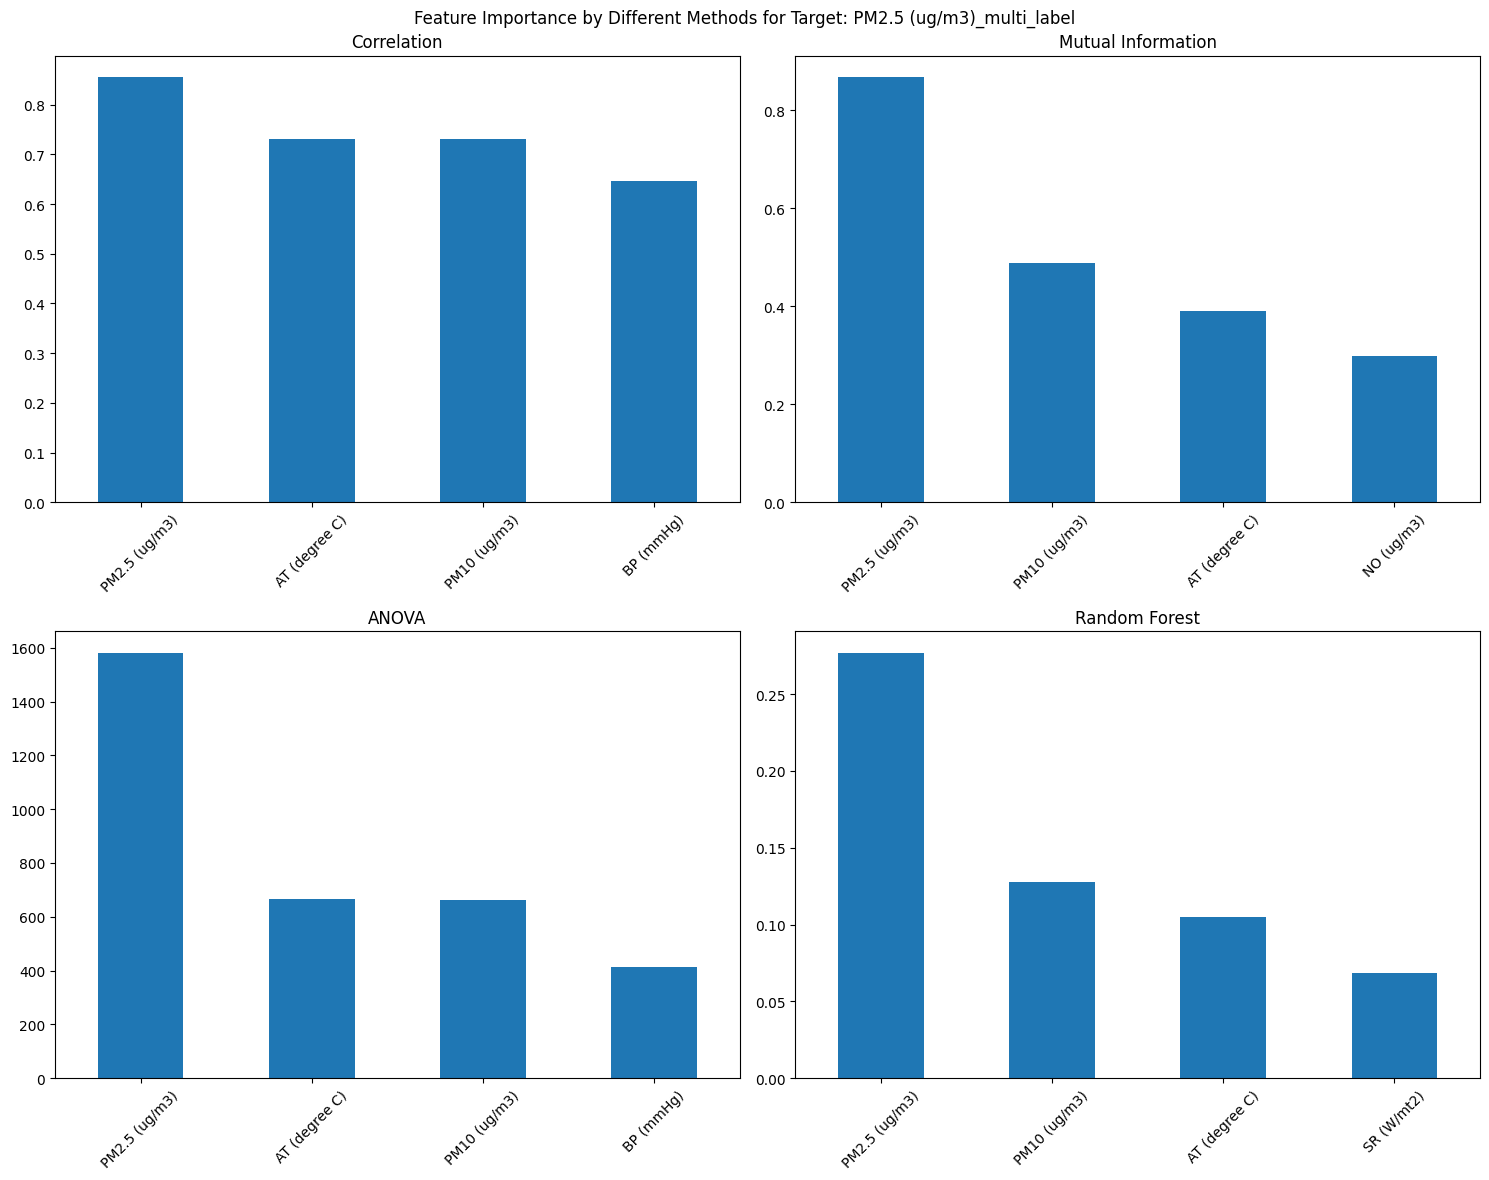

Features that appear in multiple methods:
NO (ug/m3)       4
NO2 (ug/m3)      4
PM10 (ug/m3)     4
PM2.5 (ug/m3)    4
Name: count, dtype: int64


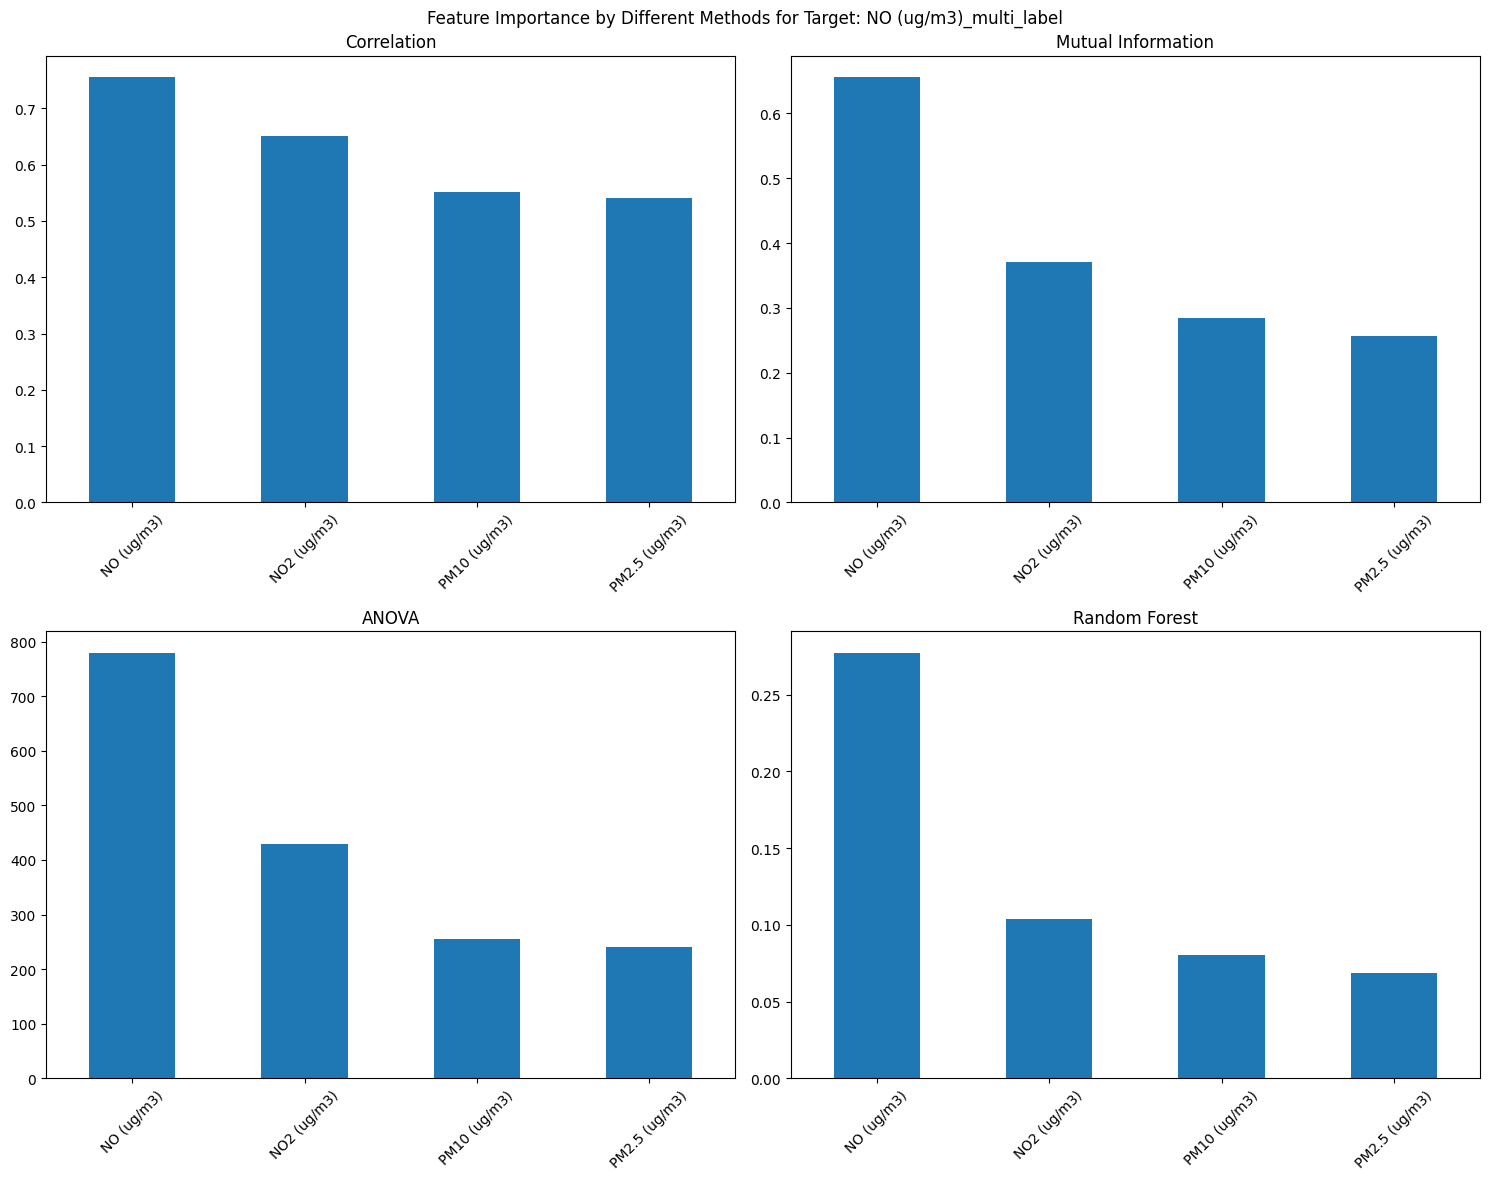

Features that appear in multiple methods:
NO2 (ug/m3)      4
NO (ug/m3)       4
PM10 (ug/m3)     4
BP (mmHg)        2
PM2.5 (ug/m3)    2
Name: count, dtype: int64


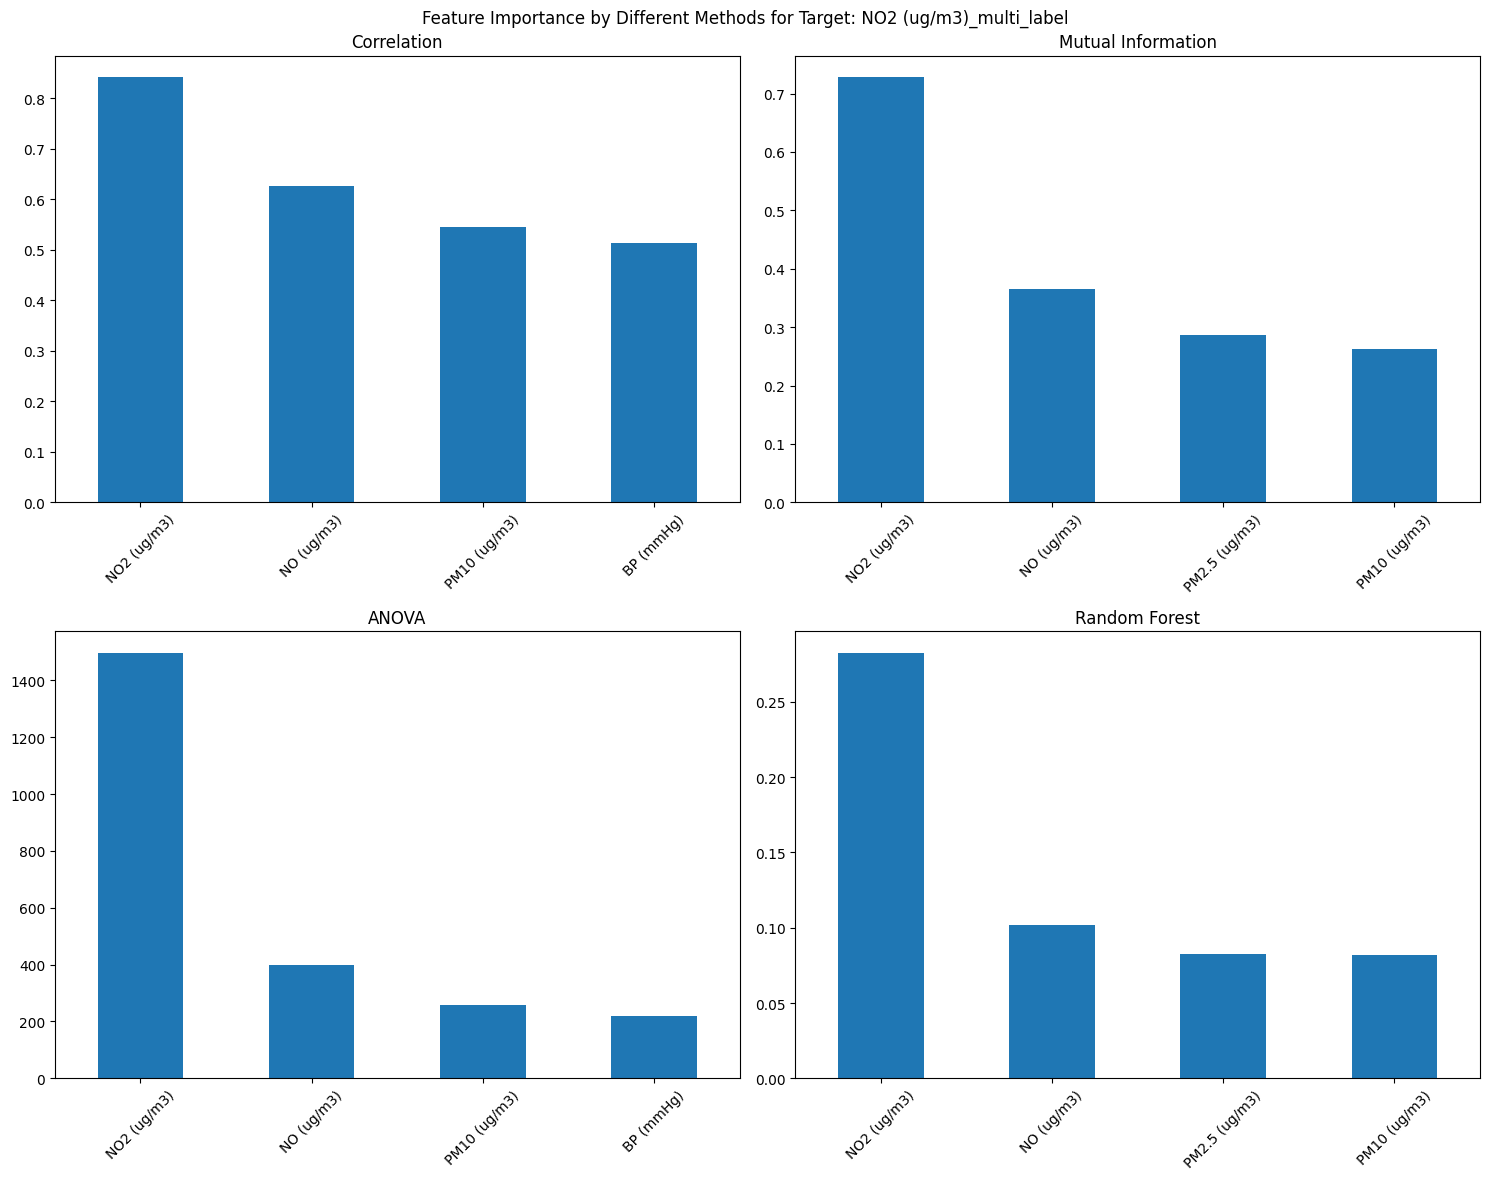

In [ ]:
selector_multi = {}
for key, value in df_balanced_multi_label.items():
  selector_multi[f'{key}'] = FeatureSelector(value, f'{key}_multi_label', n_features=4)

  # Ottieni i risultati
  scores_multi, feature_counts_multi = selector_multi[f'{key}'].compare_methods()

In [ ]:
for key, value in selector_multi.items():
    print(f'Valutazione per {key}')
    eval_results_multi = value.eval_feature_sets(type=1)
    plot_scores_table(eval_results_multi)
    plot_multi_class_results(eval_results_multi)

Output hidden; open in https://colab.research.google.com to view.

### Quarta prova
Andiamo ad utilizzare 5 feature, ma solamente un classificatore per ridurre i tempi di esecuzione. Analizzando le performance dai tentativi precedenti il Random Forest sembra essere il classificatore più promettente perché:

*   Mantiene performance elevate e stabili in tutte le configurazioni
*   Ha un buon bilanciamento delle metriche per ogni classe
*   È robusto rispetto al metodo di feature selection utilizzato
*   Mostra la minore variabilità nelle performance tra i diversi setup





Features that appear in multiple methods:
Ozone (ug/m3)    4
RH (%)           4
SR (W/mt2)       4
AT (degree C)    3
SO2 (ug/m3)      2
PM2.5 (ug/m3)    2
Name: count, dtype: int64


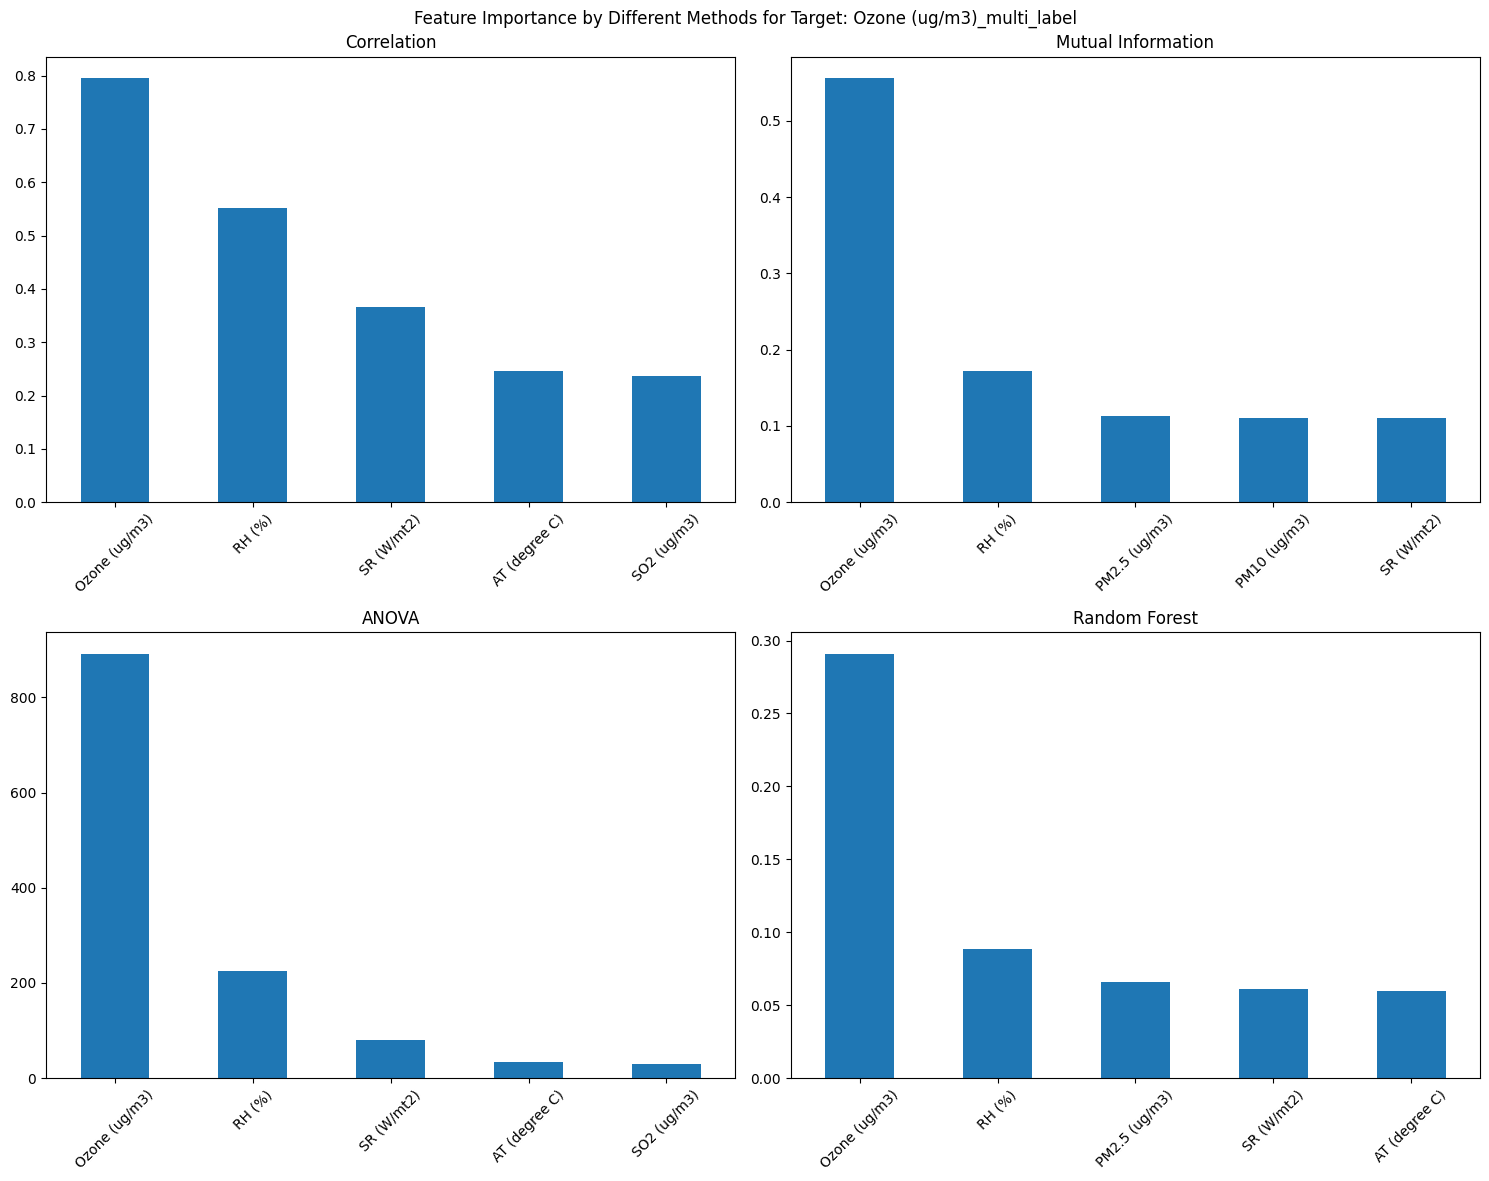

Features that appear in multiple methods:
CO (mg/m3)       4
PM2.5 (ug/m3)    4
NO2 (ug/m3)      4
SR (W/mt2)       3
NO (ug/m3)       3
PM10 (ug/m3)     2
Name: count, dtype: int64


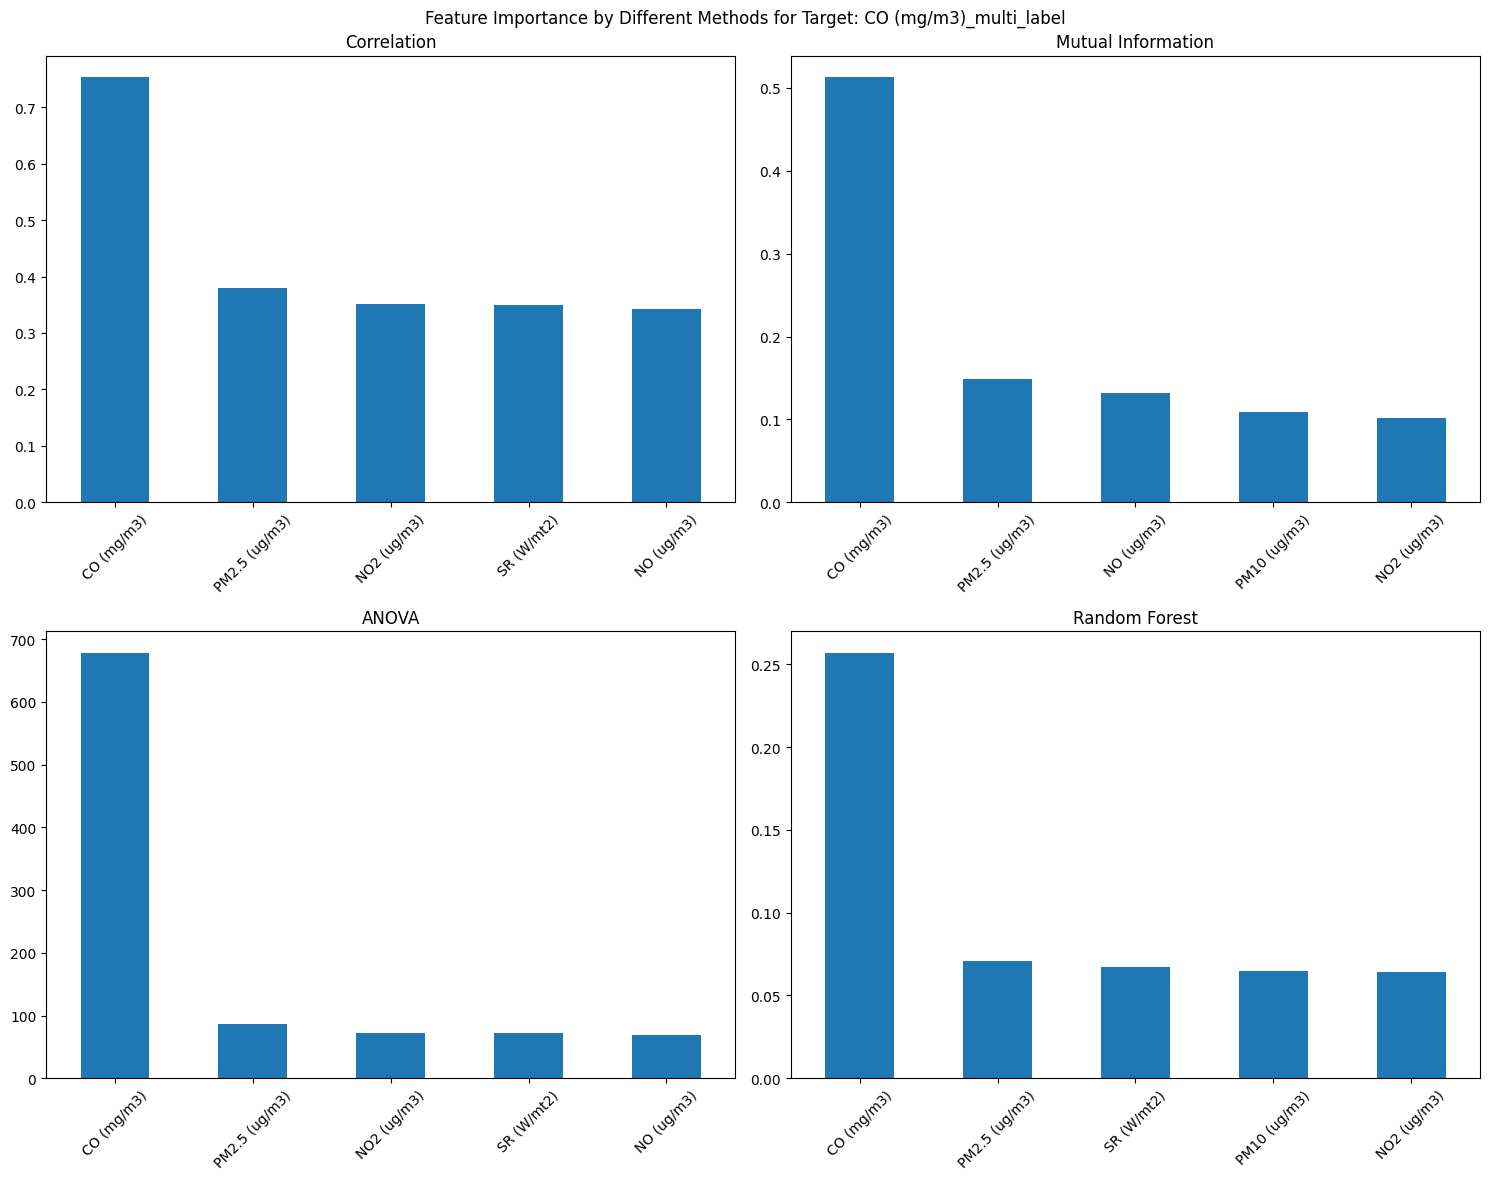

Features that appear in multiple methods:
SO2 (ug/m3)      4
RH (%)           3
PM10 (ug/m3)     3
Ozone (ug/m3)    3
NO2 (ug/m3)      3
AT (degree C)    2
Name: count, dtype: int64


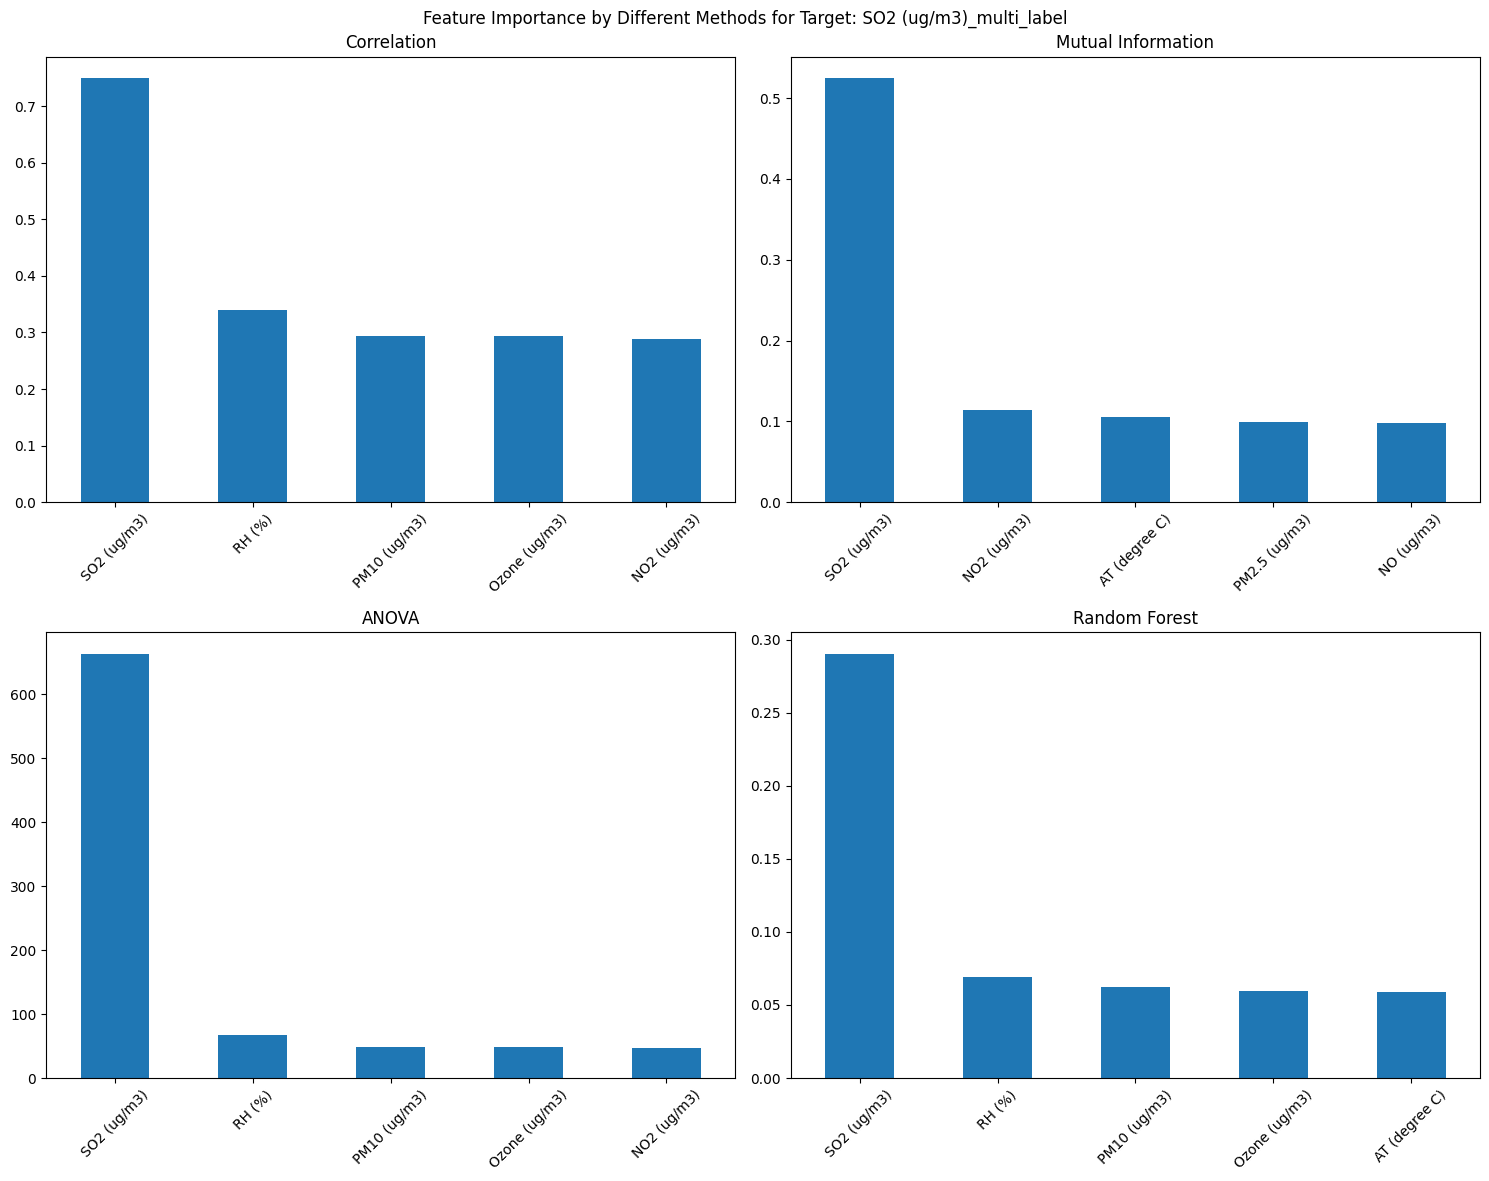

Features that appear in multiple methods:
PM10 (ug/m3)     4
PM2.5 (ug/m3)    4
NO2 (ug/m3)      4
NO (ug/m3)       4
AT (degree C)    4
Name: count, dtype: int64


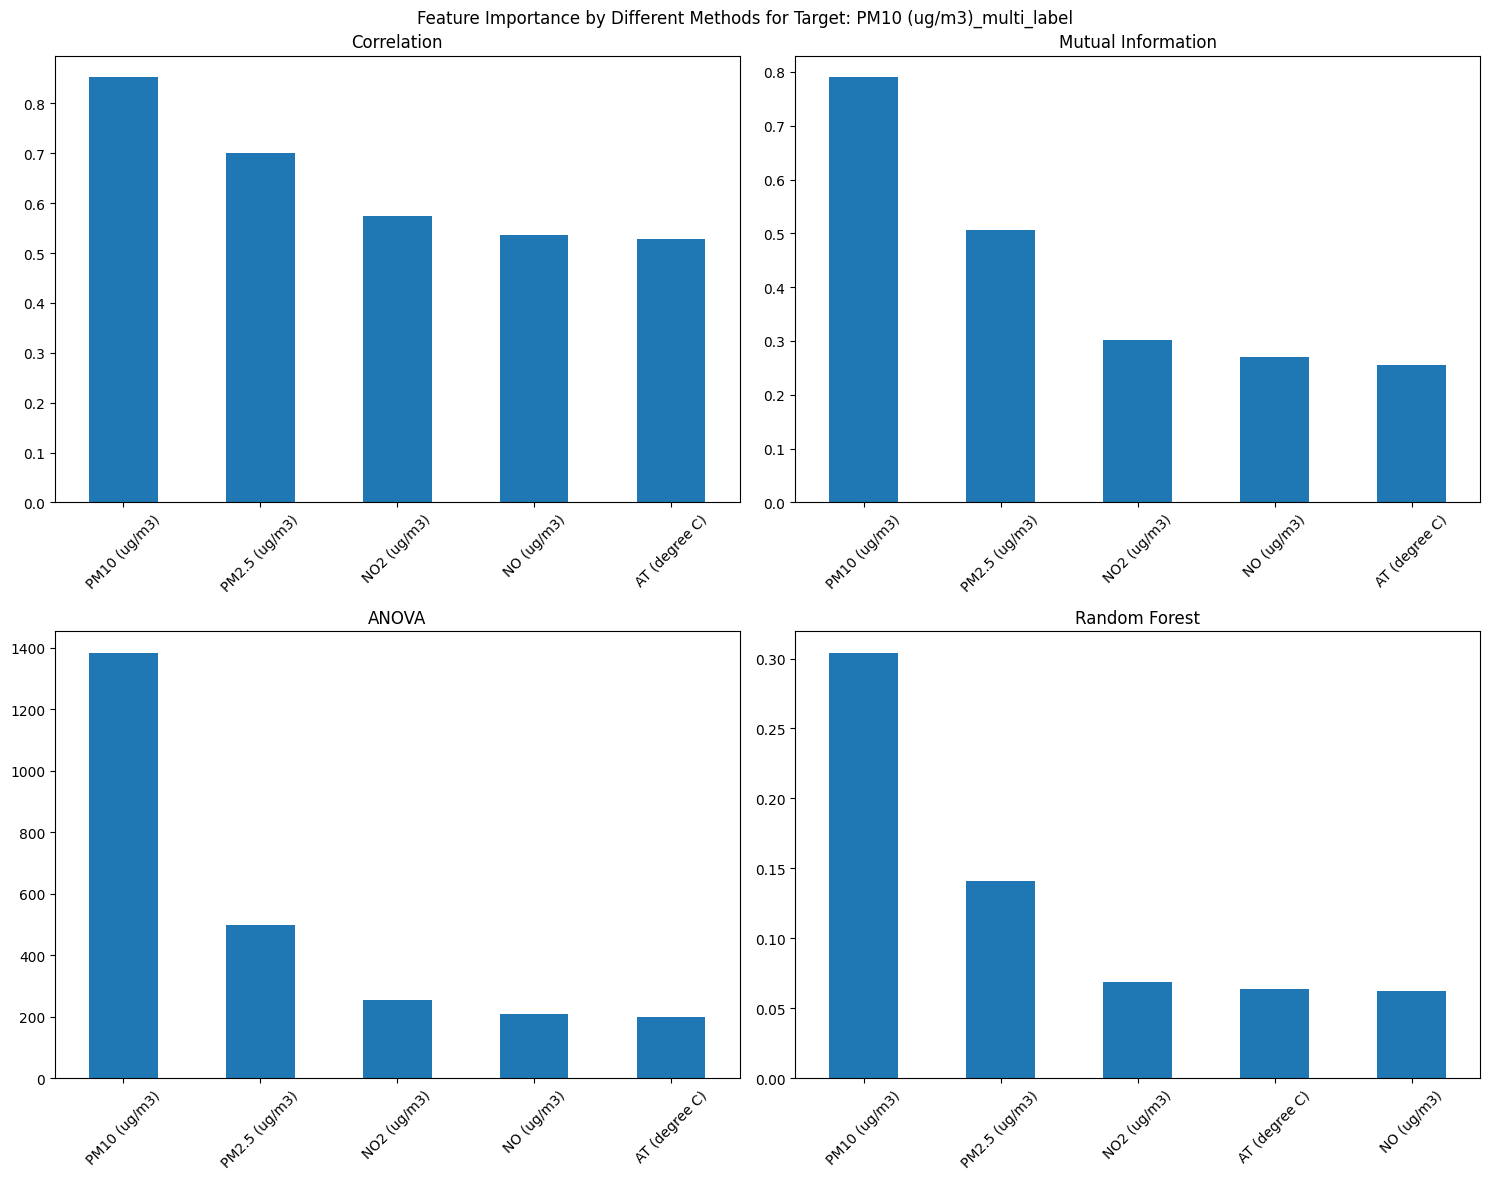

Features that appear in multiple methods:
PM2.5 (ug/m3)    4
PM10 (ug/m3)     4
AT (degree C)    4
NO2 (ug/m3)      4
BP (mmHg)        2
NO (ug/m3)       2
Name: count, dtype: int64


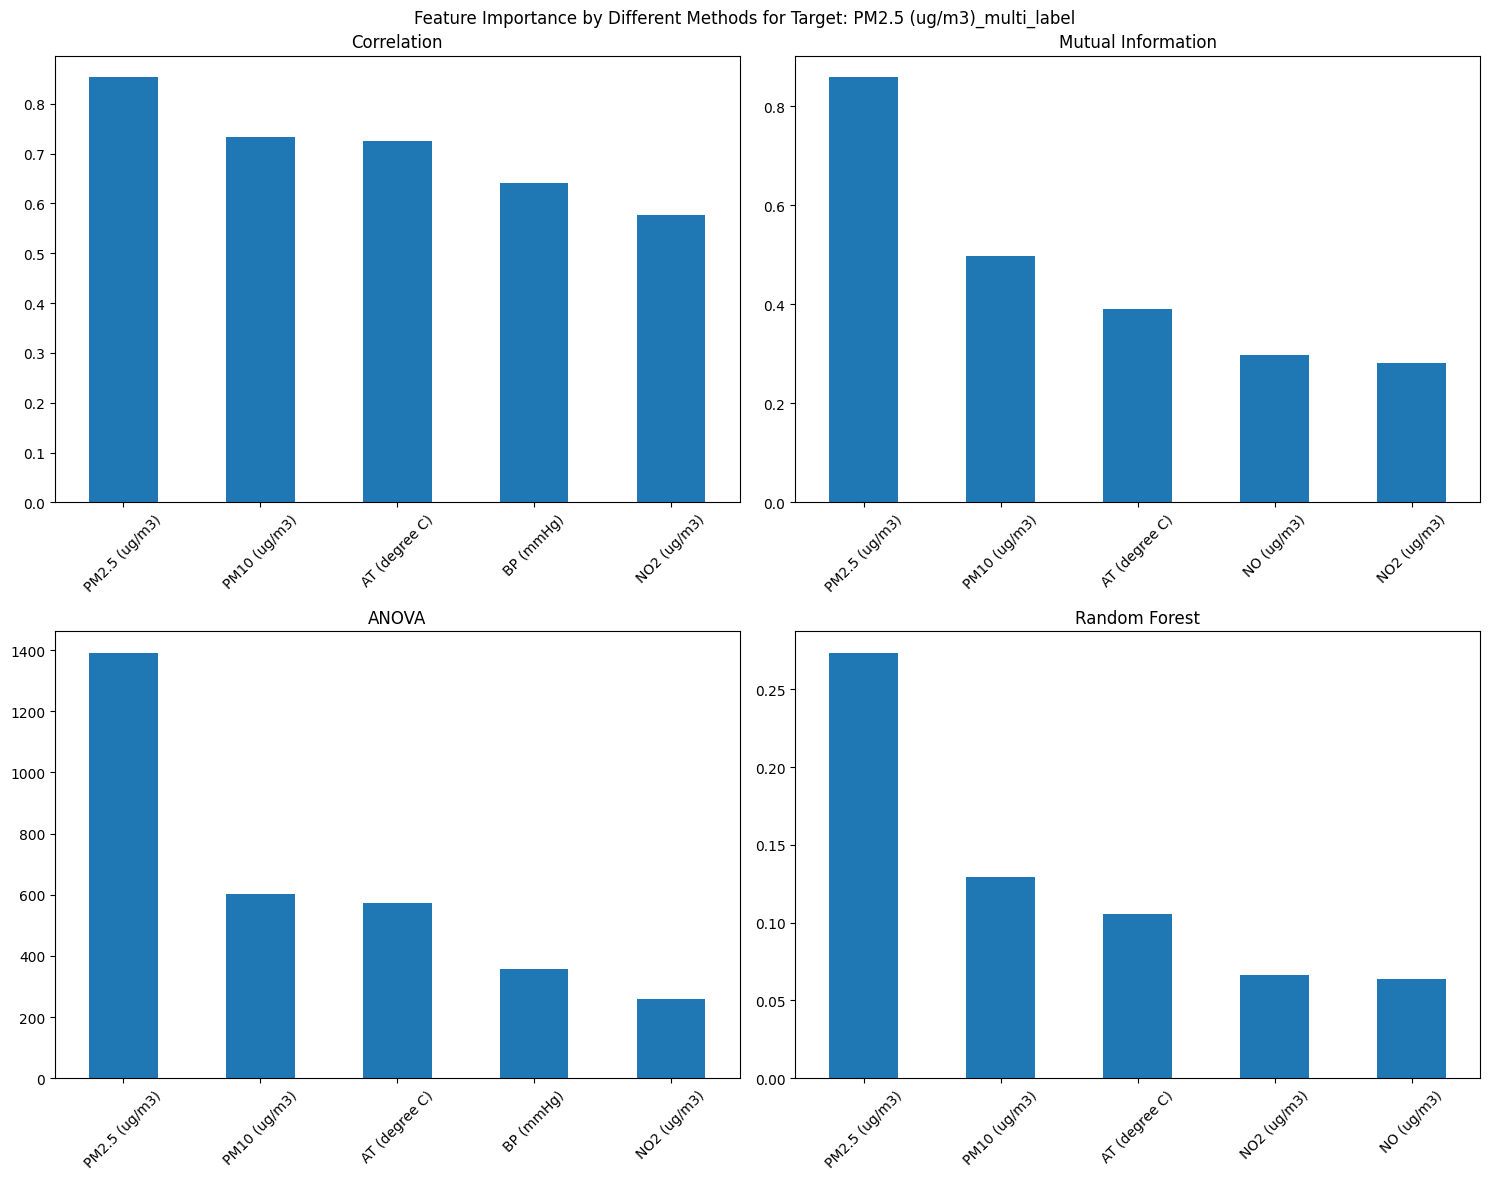

Features that appear in multiple methods:
NO (ug/m3)       4
NO2 (ug/m3)      4
PM10 (ug/m3)     4
PM2.5 (ug/m3)    4
BP (mmHg)        4
Name: count, dtype: int64


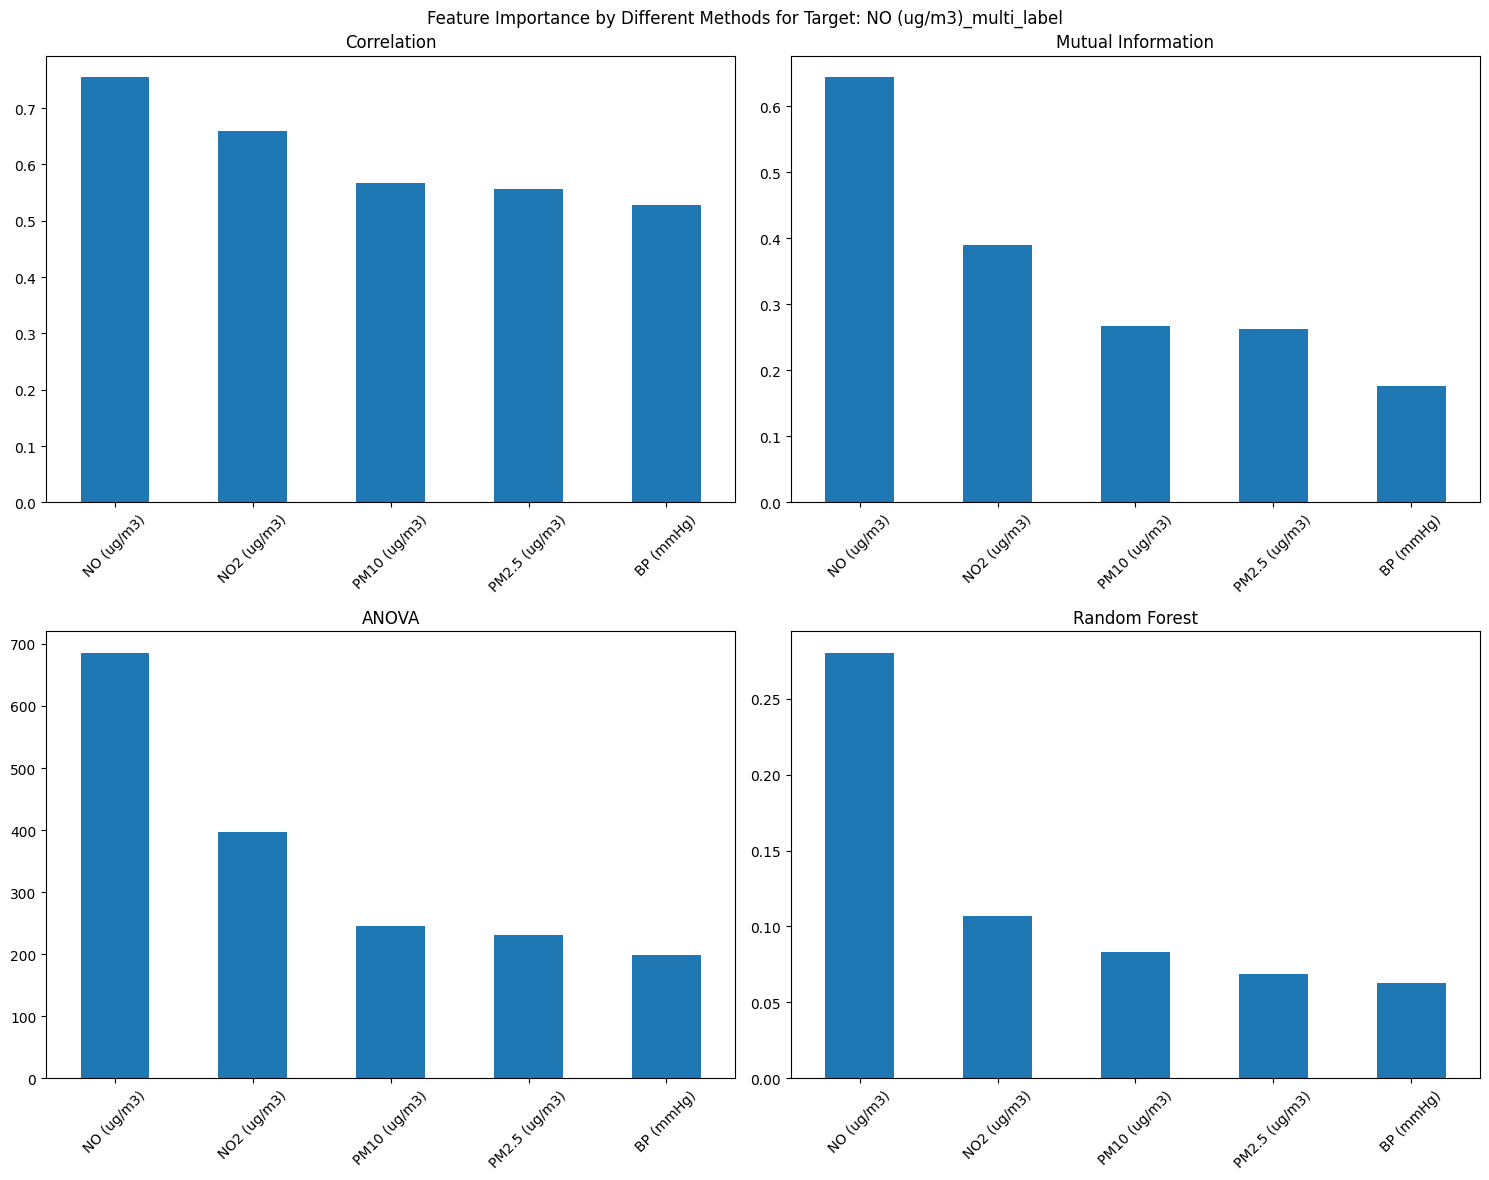

Features that appear in multiple methods:
NO2 (ug/m3)      4
NO (ug/m3)       4
PM10 (ug/m3)     4
PM2.5 (ug/m3)    4
BP (mmHg)        4
Name: count, dtype: int64


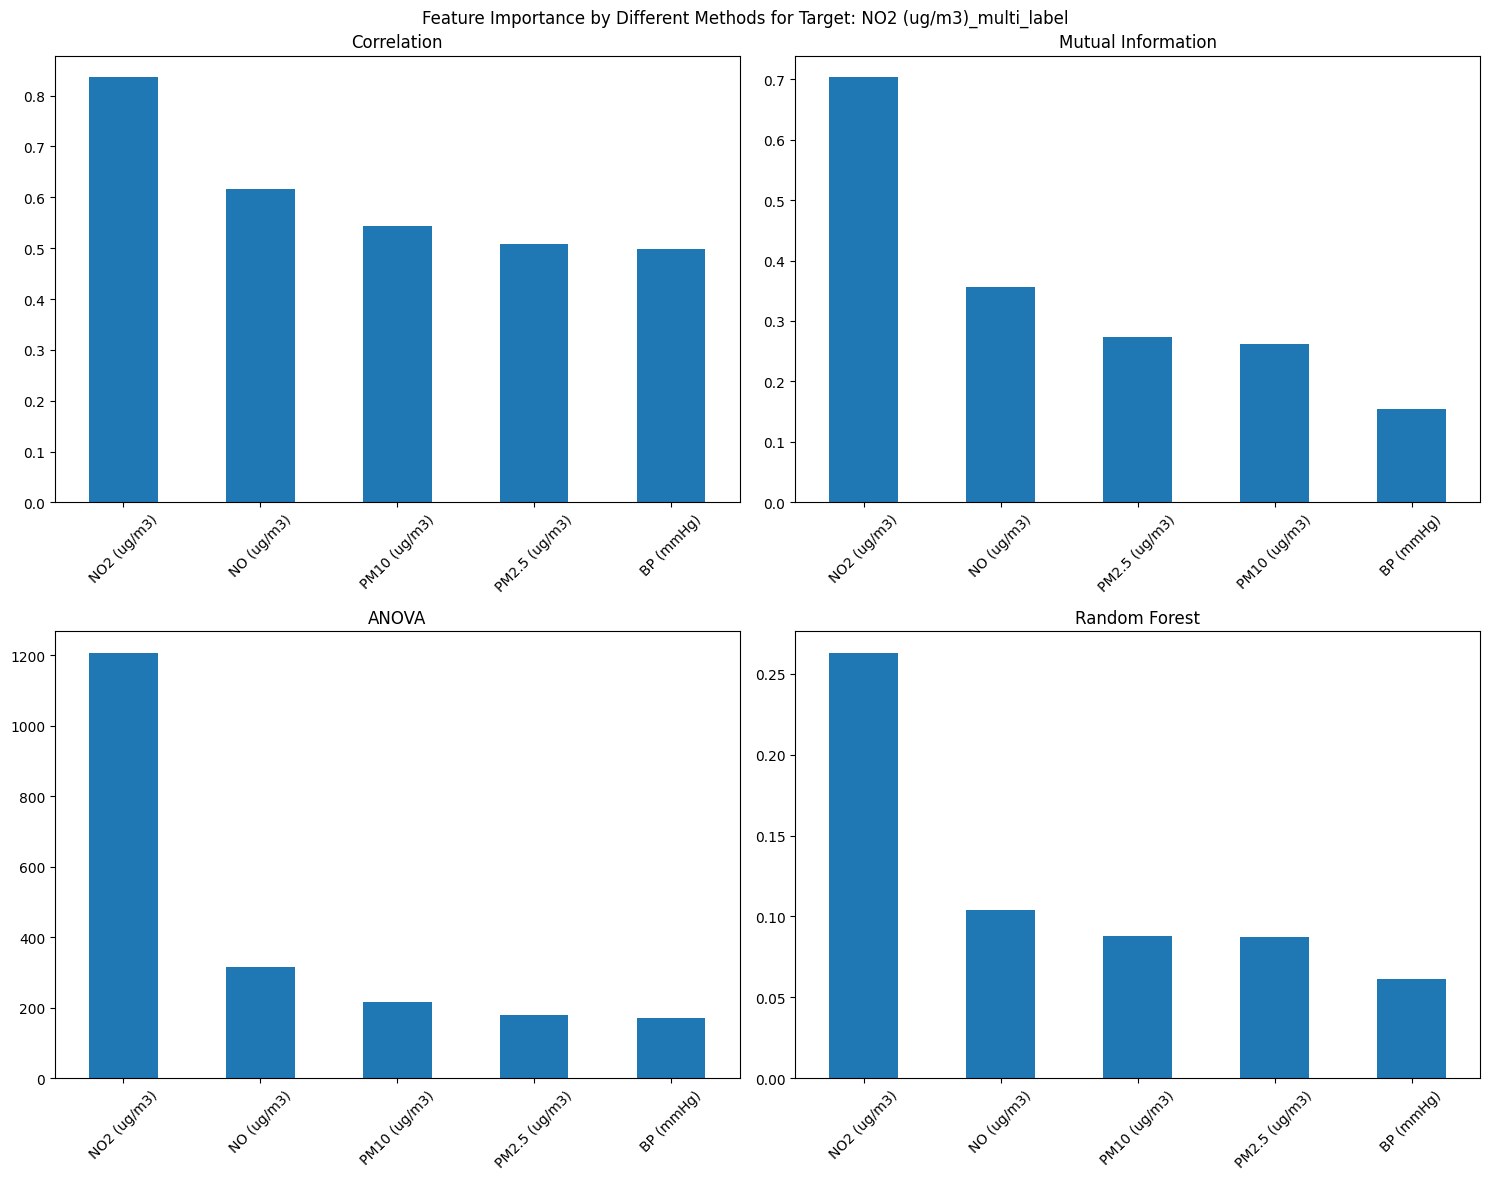

In [ ]:
selector_multi = {}
for key, value in df_multi_label.items():
  selector_multi[f'{key}'] = FeatureSelector(value, f'{key}_multi_label', n_features=5, classifier_names=['Random Forest'])

  # Ottieni i risultati
  scores_multi, feature_counts_multi = selector_multi[f'{key}'].compare_methods()

In [ ]:
for key, value in selector_multi.items():
    print(f'Valutazione per {key}')
    eval_results_multi = value.eval_feature_sets(type=1)
    plot_scores_table(eval_results_multi)
    plot_multi_class_results(eval_results_multi)

Output hidden; open in https://colab.research.google.com to view.

### Quinta prova
Sulla base dei risultati della prova precedente, andiamo a bilanciare il dataset e classificare nuovamente con 5 feature

In [ ]:
#Bilanciamento

# Crea un dizionario vuoto per contenere i dataframe bilanciati
df_balanced_multi_label = {}

for key, value in selector_multi.items():
    print(f'Valutazione sbilanciamento classi per dataframe con classi inquinamento su {key}')

    # Bilancia il dataframe
    df_balanced, method = balance_classes(value.df, f'{key}_multi_label', strategy='auto')  # 'auto' fa scegliere automaticamente il metodo di bilanciamento

    # Salva il dataframe bilanciato nel dizionario con la chiave corrispondente
    df_balanced_multi_label[key] = df_balanced

    # Stampa il metodo di bilanciamento utilizzato
    print(f"Metodo di bilanciamento utilizzato: {method}")

Valutazione sbilanciamento classi per dataframe con classi inquinamento su Ozone (ug/m3)
Distribuzione originale delle classi: {'Nullo': 440, 'Basso': 378, 'Medio': 369, 'Alto': 363}
Distribuzione nuova delle classi: {'Medio': 440, 'Nullo': 440, 'Basso': 440, 'Alto': 440}
Metodo di bilanciamento utilizzato: SMOTE
Valutazione sbilanciamento classi per dataframe con classi inquinamento su CO (mg/m3)
Distribuzione originale delle classi: {'Basso': 439, 'Alto': 413, 'Nullo': 403, 'Medio': 295}
Distribuzione nuova delle classi: {'Alto': 439, 'Basso': 439, 'Nullo': 439, 'Medio': 439}
Metodo di bilanciamento utilizzato: SMOTE
Valutazione sbilanciamento classi per dataframe con classi inquinamento su SO2 (ug/m3)
Distribuzione originale delle classi: {'Nullo': 451, 'Basso': 445, 'Medio': 372, 'Alto': 282}
Distribuzione nuova delle classi: {'Alto': 451, 'Basso': 451, 'Medio': 451, 'Nullo': 451}
Metodo di bilanciamento utilizzato: SMOTE
Valutazione sbilanciamento classi per dataframe con classi i

Features that appear in multiple methods:
Ozone (ug/m3)    4
RH (%)           4
SR (W/mt2)       4
AT (degree C)    2
SO2 (ug/m3)      2
PM2.5 (ug/m3)    2
PM10 (ug/m3)     2
Name: count, dtype: int64


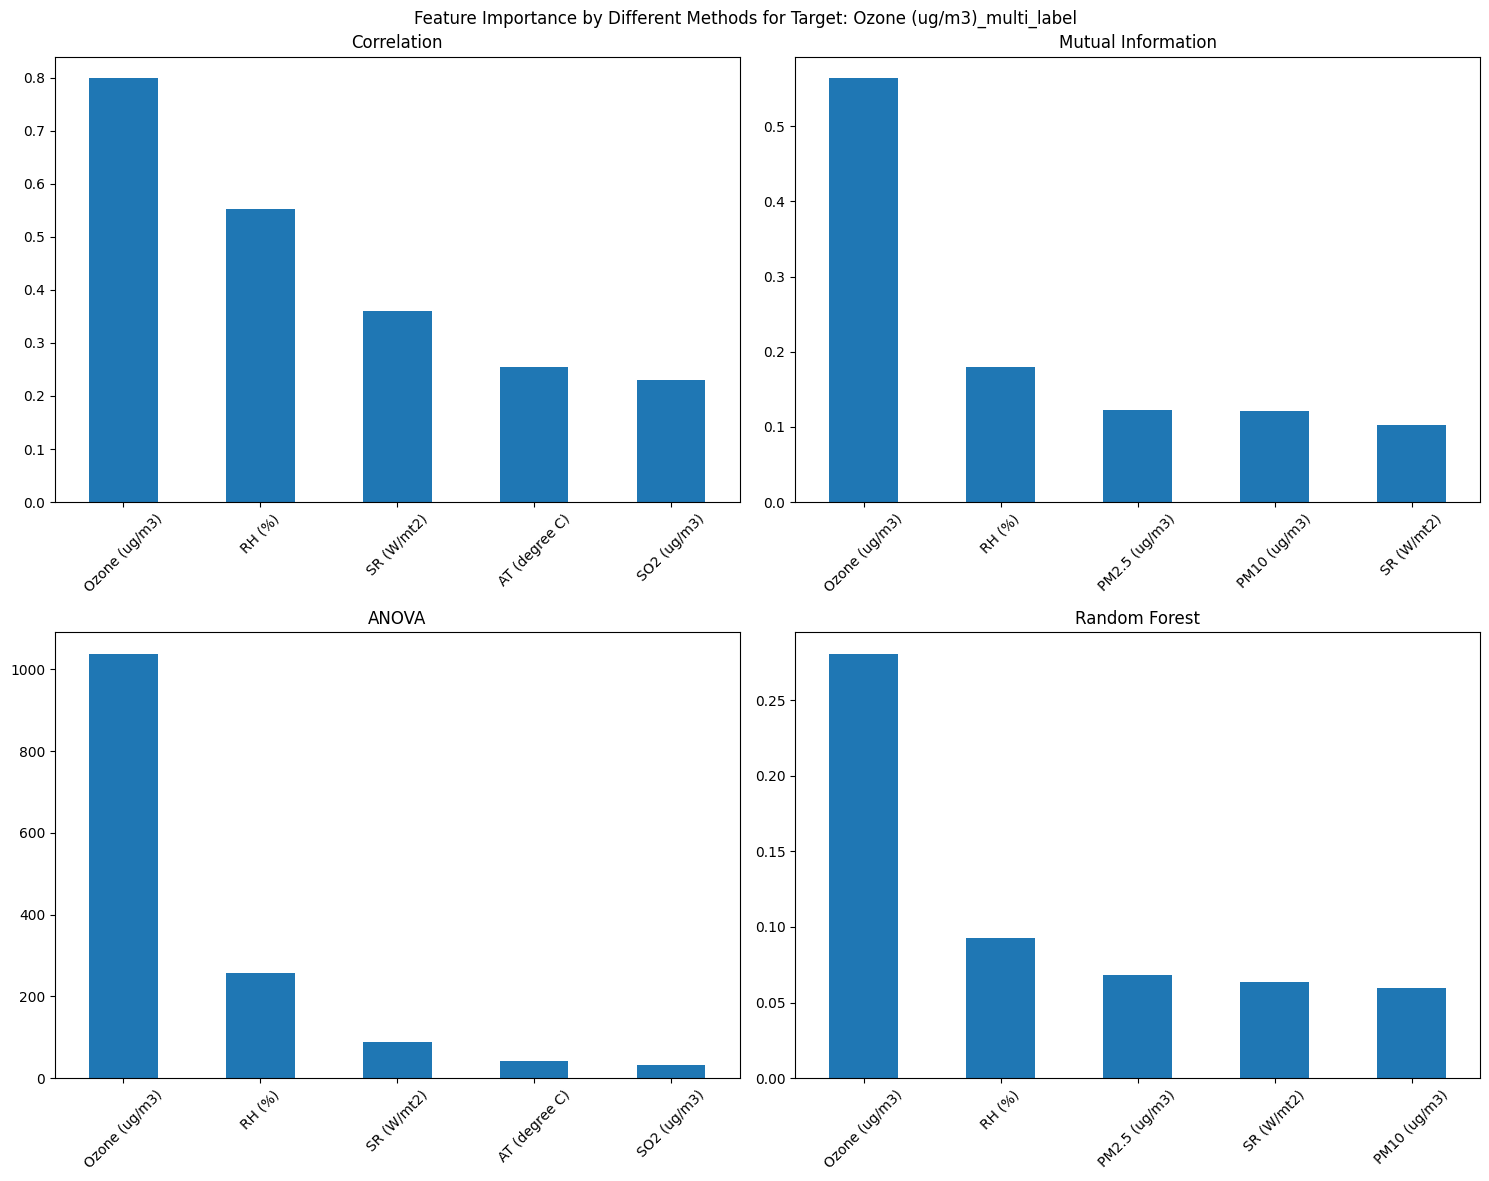

Features that appear in multiple methods:
CO (mg/m3)       4
PM2.5 (ug/m3)    4
NO2 (ug/m3)      3
NO (ug/m3)       3
SR (W/mt2)       3
PM10 (ug/m3)     2
Name: count, dtype: int64


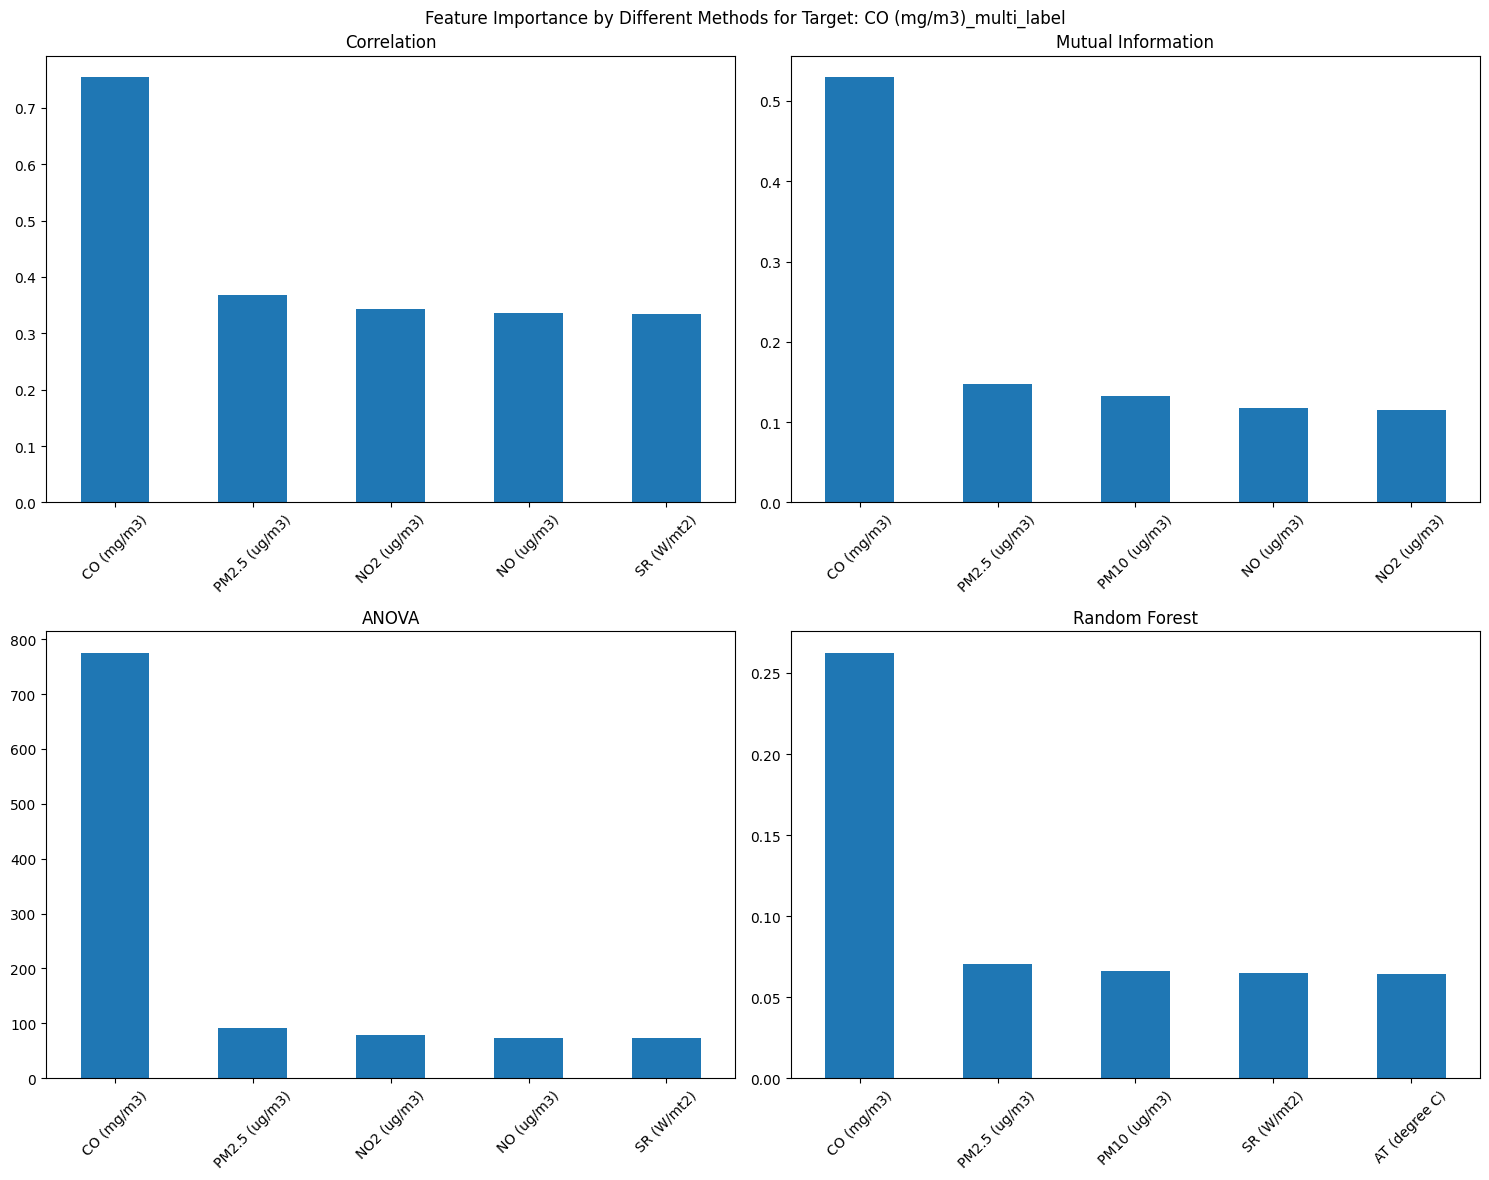

Features that appear in multiple methods:
SO2 (ug/m3)      4
RH (%)           3
Ozone (ug/m3)    3
PM10 (ug/m3)     3
NO2 (ug/m3)      3
AT (degree C)    2
Name: count, dtype: int64


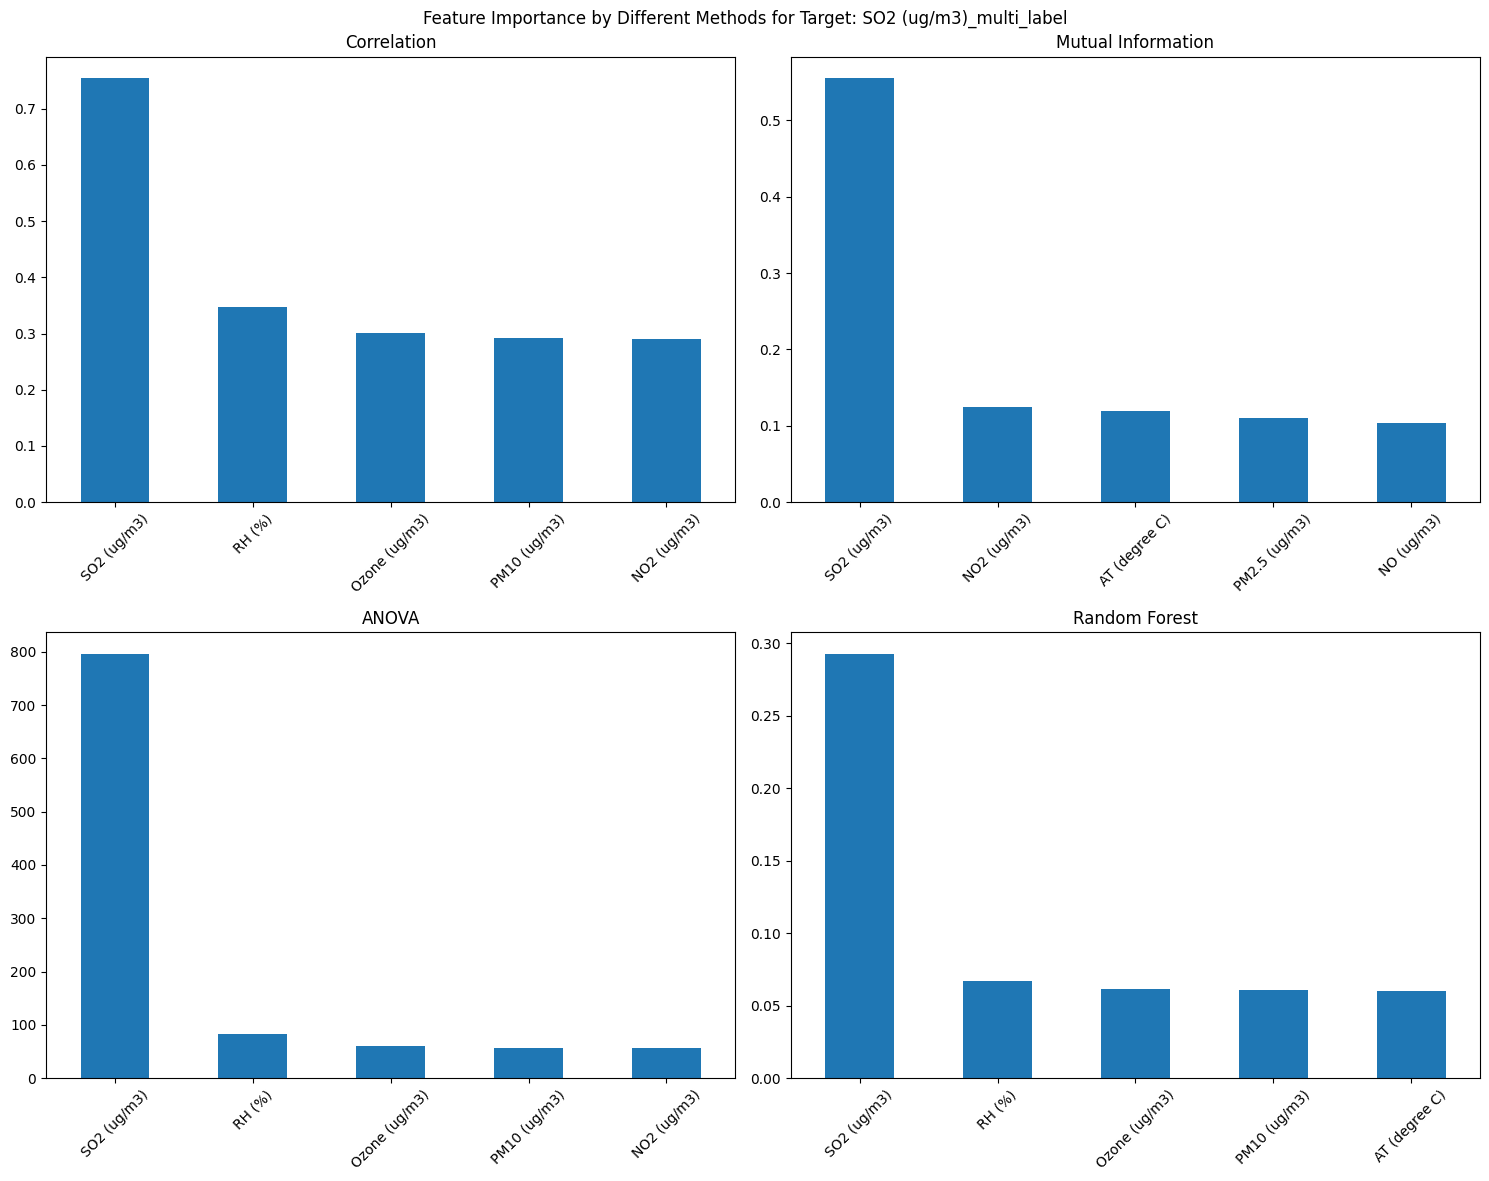

Features that appear in multiple methods:
PM10 (ug/m3)     4
PM2.5 (ug/m3)    4
NO2 (ug/m3)      4
NO (ug/m3)       4
AT (degree C)    4
Name: count, dtype: int64


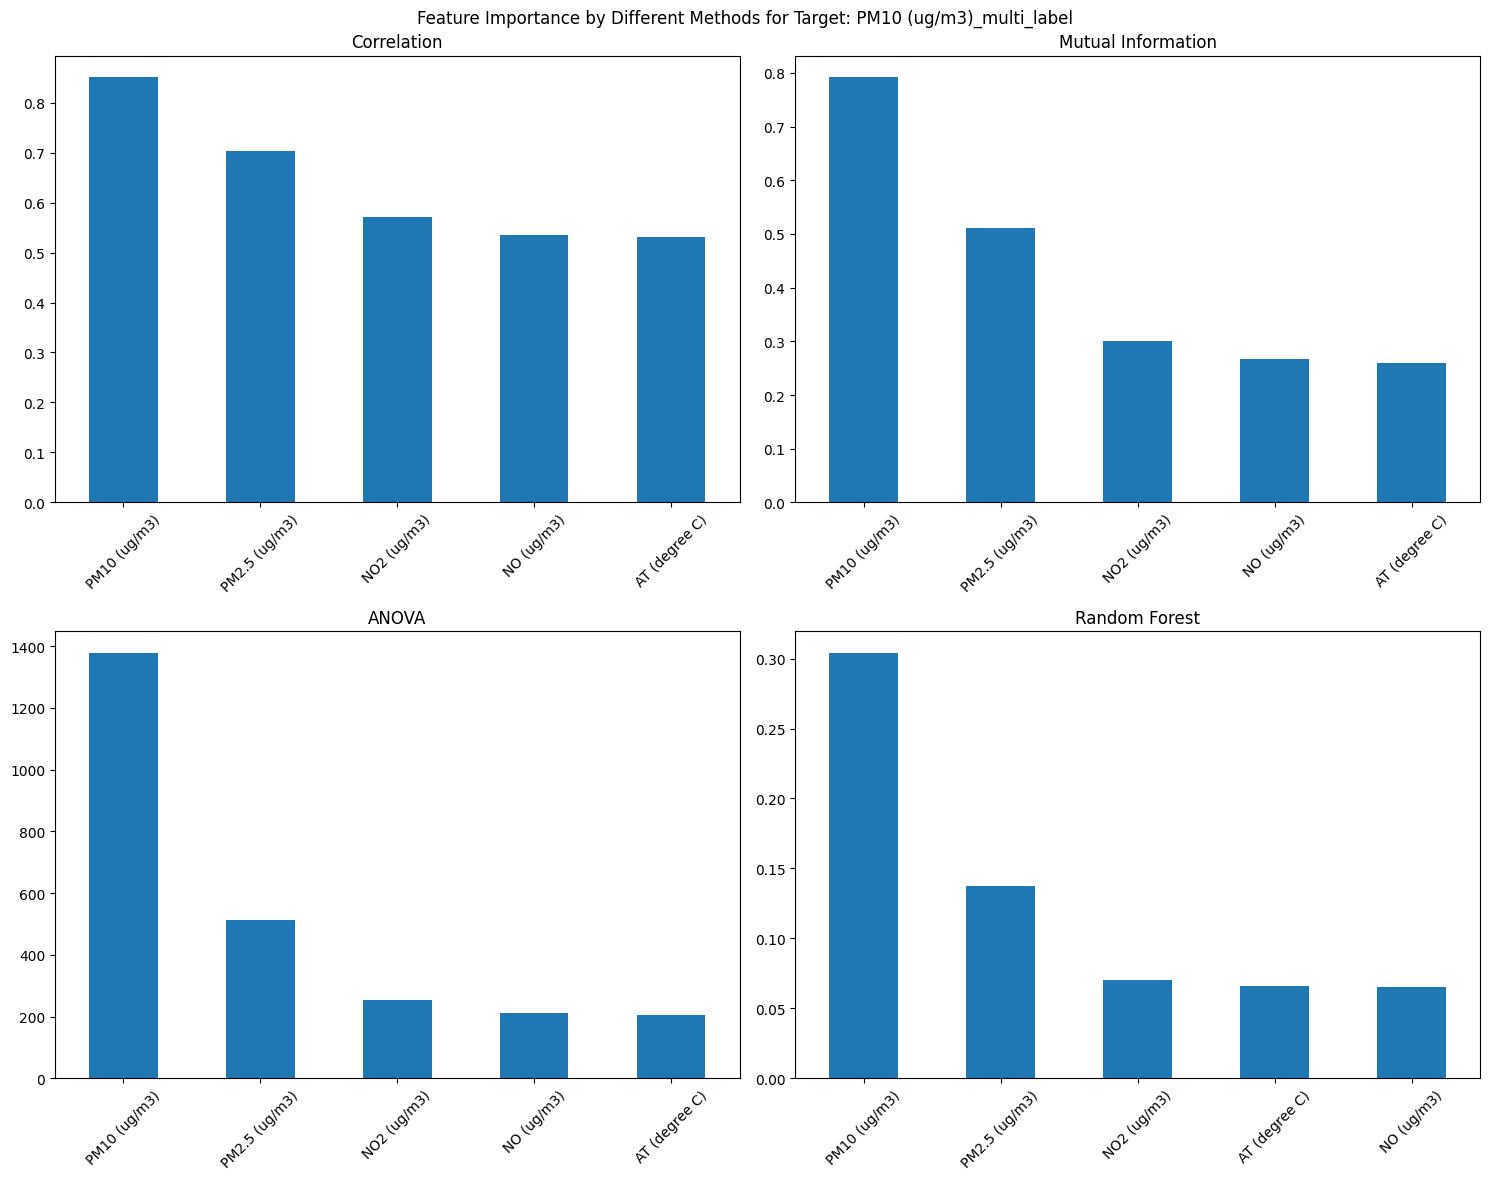

Features that appear in multiple methods:
PM2.5 (ug/m3)    4
AT (degree C)    4
PM10 (ug/m3)     4
SR (W/mt2)       3
BP (mmHg)        2
NO2 (ug/m3)      2
Name: count, dtype: int64


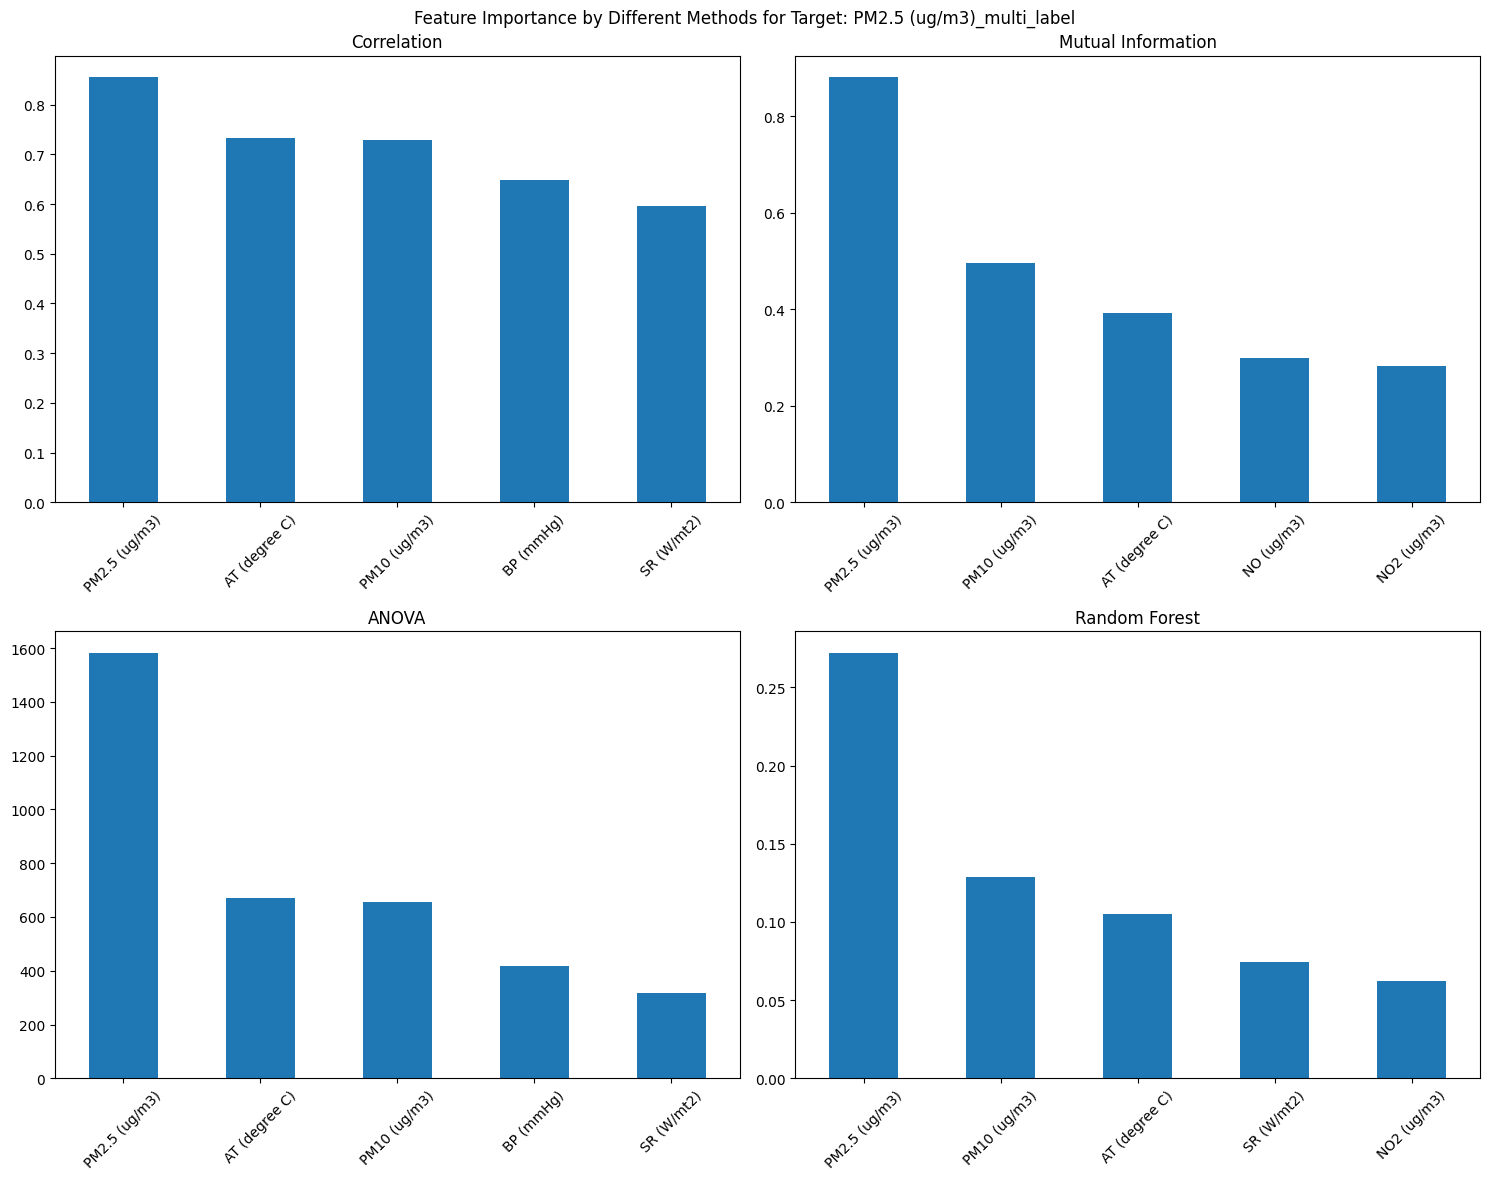

Features that appear in multiple methods:
NO (ug/m3)       4
NO2 (ug/m3)      4
PM10 (ug/m3)     4
PM2.5 (ug/m3)    4
BP (mmHg)        4
Name: count, dtype: int64


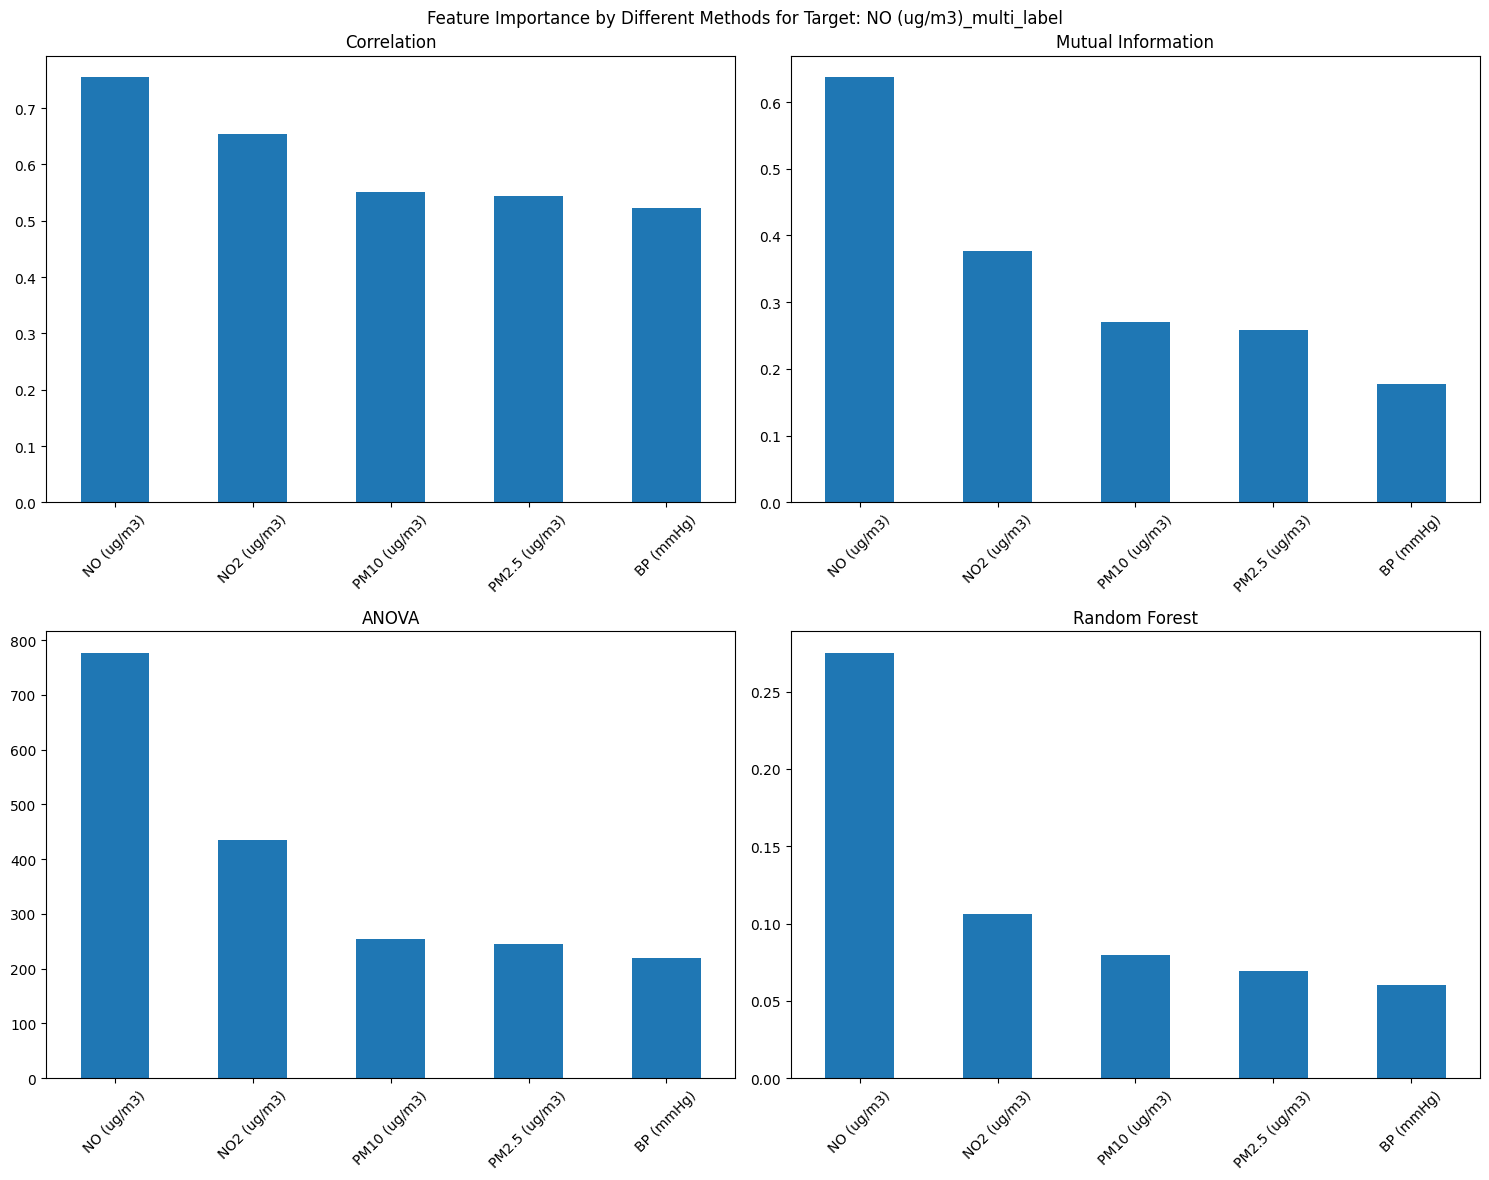

Features that appear in multiple methods:
NO2 (ug/m3)      4
NO (ug/m3)       4
PM10 (ug/m3)     4
BP (mmHg)        4
PM2.5 (ug/m3)    4
Name: count, dtype: int64


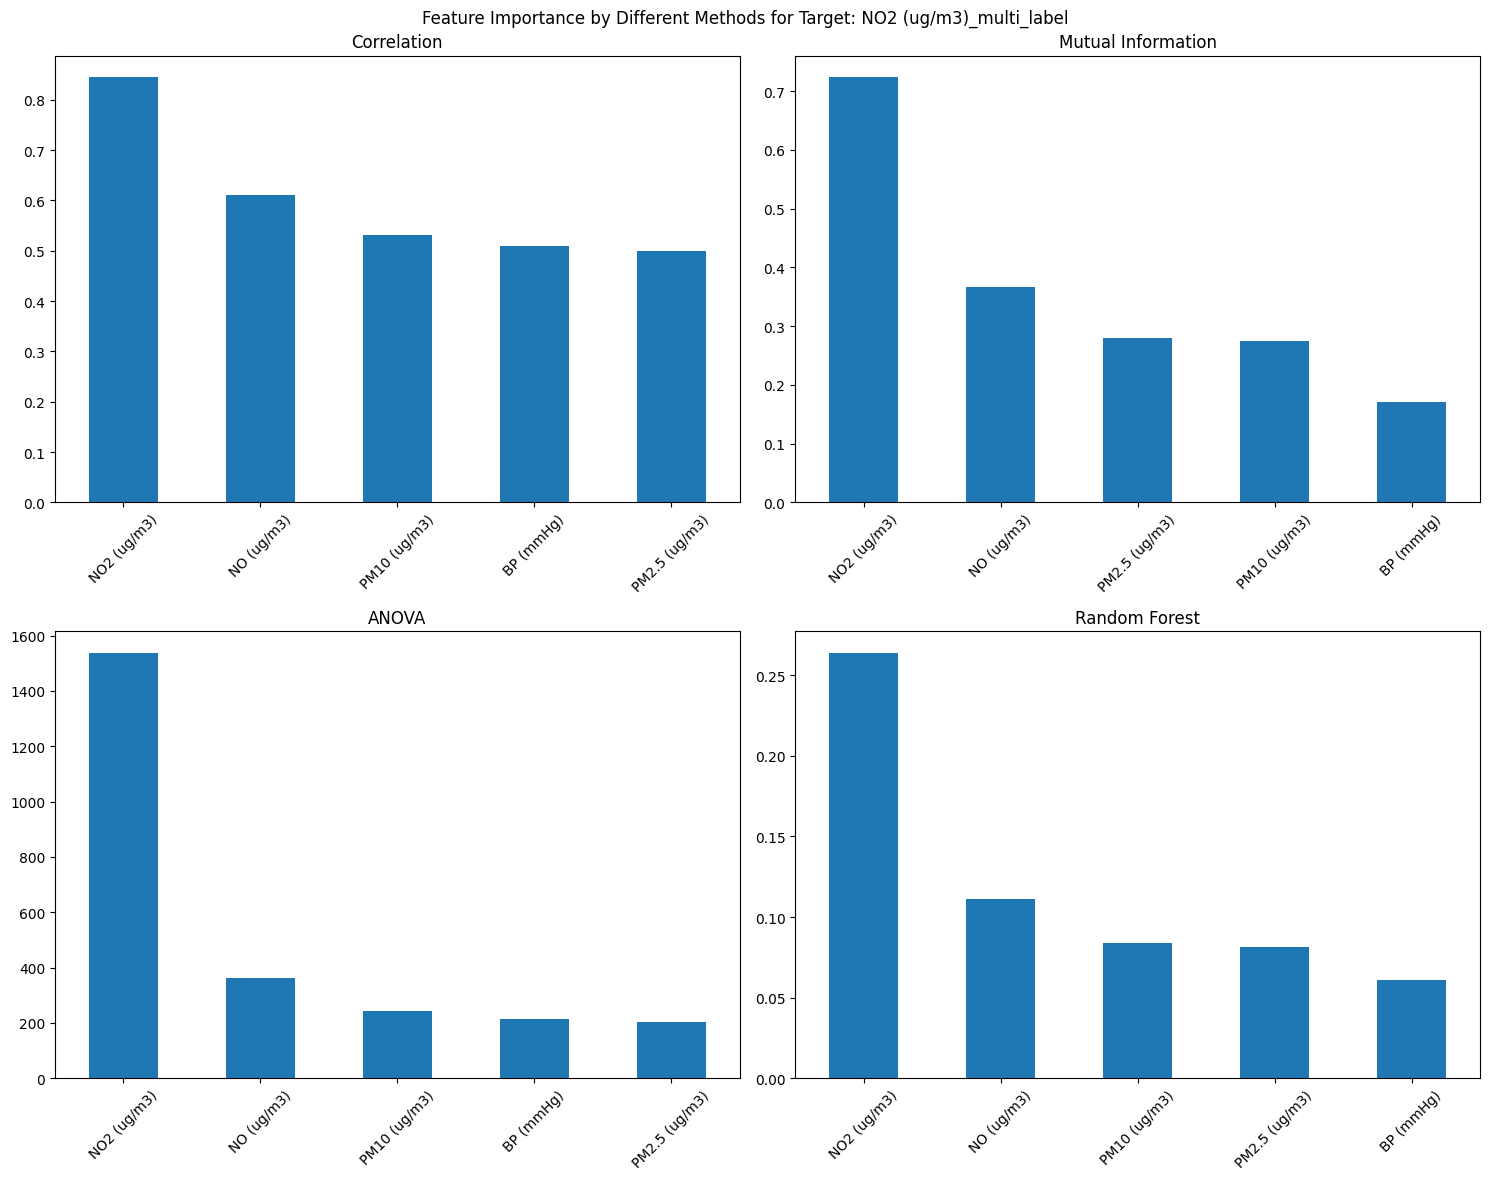

In [ ]:
selector_multi = {}
for key, value in df_balanced_multi_label.items():
  selector_multi[f'{key}'] = FeatureSelector(value, f'{key}_multi_label', n_features=5, classifier_names=['Random Forest'])

  # Ottieni i risultati
  scores_multi, feature_counts_multi = selector_multi[f'{key}'].compare_methods()

In [ ]:
for key, value in selector_multi.items():
    print(f'Valutazione per {key}')
    eval_results_multi = value.eval_feature_sets(type=1)
    plot_scores_table(eval_results_multi)
    plot_multi_class_results(eval_results_multi)

Output hidden; open in https://colab.research.google.com to view.